# Project Description

The goal of this project is to predict the median income of a Census Tract, and find suitable places to open 'Basic' and 'Premium' store based on median Income of each census tract.

This porject first Compares the clusters obtained by K-Means and BIRCH.

Next, the project tries different numbers of clusters, and for each cluster, the project uses Gradiant Boosting Regressor, Random Forrest, Linear Regression,Ridge Regression, Lasso Regression, KNN Regressor, Artificial Neural Network, and Decision Tree to make final prediction.

The project is capable of finding the overall optimal number of clusters and the optimal regressor model for each cluster within the optimal clusters, the criteria used is MSE.

# Getting Started

## Importing Packages and Setting Specifications

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score,  mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
pd.options.mode.chained_assignment = None
pd.set_option("display.max_columns",500,"display.max_rows",500)
plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.rc('font', size=24)          # controls default text sizes
plt.rc('axes', titlesize=24)     # fontsize of the axes title
plt.rc('axes', labelsize=24)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=24)    # fontsize of the tick labels
plt.rc('ytick', labelsize=24)    # fontsize of the tick labels
plt.rc('legend', fontsize=24)  
plt.rc('figure', titlesize=30)  # fontsize of the figure title

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

## Read Data into DataFrame

In [2]:
data = pd.read_csv('CensusCanada2016Training.csv')
data.describe()

Total Population  Total Households  \
count       5000.000000       5000.000000   
mean        4866.967400       1927.776200   
std         2491.841571        974.811432   
min            0.000000          0.000000   
25%         3289.750000       1333.750000   
50%         4655.000000       1825.000000   
75%         6233.750000       2428.250000   
max        30789.000000      15388.000000   

       Median Household Income (Current Year $)  \
count                               5000.000000   
mean                               77241.071536   
std                                33371.567357   
min                                    0.000000   
25%                                53040.835000   
50%                                76206.780000   
75%                                95438.495000   
max                               669559.560000   

       Total Households For Period Of Construction  \
count                                  5000.000000   
mean                                   1927.776200   
std                                     974.811432   
min                                       0.000000   
25%                                    1333.750000   
50%                                    1825.000000   
75%                                    2428.250000   
max                                   15388.000000   

       Total Households For Period Of Construction Built Before 1961  \
count                                        5000.000000               
mean                                          386.510600               
std                                           416.908471               
min                                             0.000000               
25%                                            47.000000               
50%                                           238.000000               
75%                                           613.000000               
max                                          2411.000000               

       Total Households For Period Of Construction Built Between 1961 And 1980  \
count                                        5000.000000                         
mean                                          555.437800                         
std                                           448.327845                         
min                                             0.000000                         
25%                                           192.000000                         
50%                                           470.000000                         
75%                                           830.000000                         
max                                          3547.000000                         

       Total Households For Period Of Construction Built Between 1981 And 190  \
count                                         5000.00000                        
mean                                           260.48240                        
std                                            257.86717                        
min                                              0.00000                        
25%                                             74.00000                        
50%                                            181.00000                        
75%                                            369.00000                        
max                                           1740.00000                        

       Total Households For Period Of Construction Built Between 1991 And 2000  \
count                                         5000.00000                         
mean                                           237.92820                         
std                                            265.43332                         
min                                              0.00000                         
25%                                             58.00000                         
50%                                         

## Find Correlated Variables to Drop

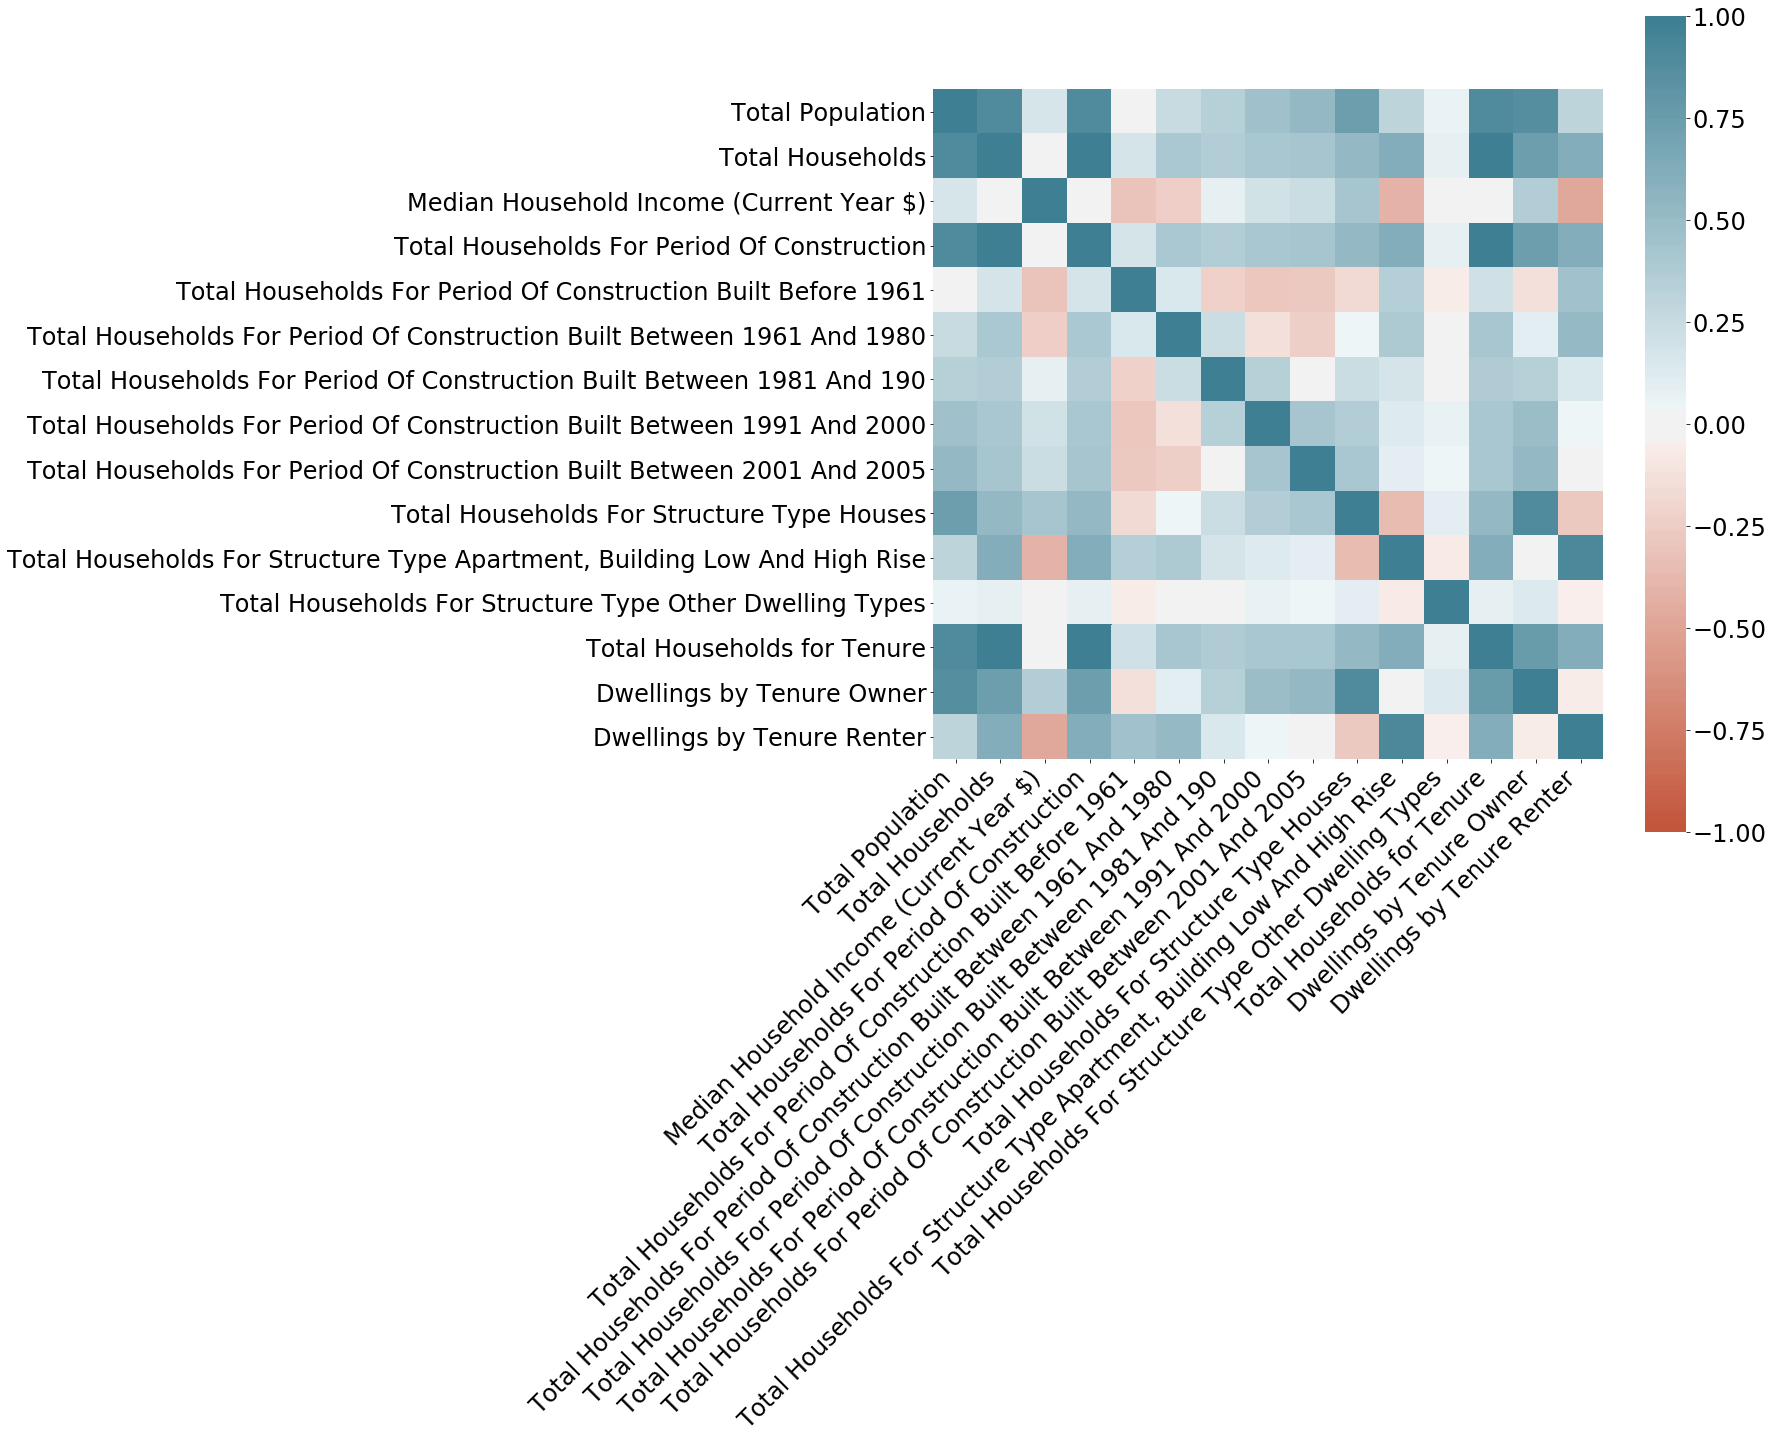

In [3]:
def corr_graph(corr_df):
    ax = sns.heatmap(
        corr_df, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )
corr_graph(data.corr())

## Define Data Prep Function

In [4]:
def prep_data(train, x_scale = None, test = False, drop_correlated = False):
    
    ## Drop unwanted columns
    column_names_to_drop = ['Total Households For Period Of Construction',
       'Total Households For Structure Type Other Dwelling Types',
       'Dwellings by Tenure Renter']
    
    ##These will be the numerators during out conversion to percentages
    col_households_numerator = [
       'Total Households For Period Of Construction Built Before 1961',
       'Total Households For Period Of Construction Built Between 1961 And 1980',
       'Total Households For Period Of Construction Built Between 1981 And 190',
       'Total Households For Period Of Construction Built Between 1991 And 2000',
       'Total Households For Period Of Construction Built Between 2001 And 2005',
       "Total Households For Structure Type Apartment, Building Low And High Rise",
       'Total Households For Structure Type Houses']
    
    ##Add correlated column name to drop
    if drop_correlated:
        column_to_drop =  "Total Households For Structure Type Apartment, Building Low And High Rise"
        column_names_to_drop.append(column_to_drop)
        col_households_numerator.remove(column_to_drop)
        
    ##Drop columns (correlated/no info)
    train.drop(columns = column_names_to_drop, inplace = True)
    
    ##Numerator of tenure
    col_tenure_numerator = 'Dwellings by Tenure Owner'
    
    ##Denominaters of percentages
    col_households_denom = 'Total Households'
    col_tenure_denom = 'Total Households for Tenure'
    col_pop = 'Total Population'
    
    ## If we are prepring the training set, then remove all observations with less than 25 households because the data quality for these observations is poor
    if test is False:
        train.drop(train.index[train[col_tenure_denom] <=25], inplace = True)
    
    ##Otherwise, retain all observations but replace 0's in the denominators with 1s to avoide dividing by 0
    else:
        train[col_tenure_denom] = train[col_tenure_denom].replace(0,1)
        train[col_households_denom] = train[col_households_denom].replace(0,1)
        
    ##Create percentages for thsoe with denominator households
    for column in col_households_numerator:
        train[column] = train[column] / train[col_households_denom]
    
    #Create percentages for tenure
    for column in [col_tenure_numerator]:
        train[column] = train[column] / train[col_tenure_denom]
    
    ##Create additional derived variables 
    train["PercentTenureHouseholds"] = train[col_tenure_denom] / train[col_households_denom]
    train["IndividualsPerHousehold"] = train[col_pop] / train[col_households_denom]
    
    ##Recode outliers with individiduals per household greater than 5 and over 100% households
    train["PercentTenureHouseholds"][train["PercentTenureHouseholds"] > 1] = 1
    train["IndividualsPerHousehold"][train["IndividualsPerHousehold"] > 5] = 5
    
    ##Drop denominators while retaining population because households, population, and tenure households are all highly correlated
    train.drop(columns = [col_households_denom]+[col_tenure_denom], inplace = True)
    
    ##Get numerical predictors
    X_cols_names = [name for name in train.columns if name != target_name]
    
    ##Scale numerical predictors
    if x_scale is None:
        x_scale = MinMaxScaler()
        train[X_cols_names] =  x_scale.fit_transform(train[X_cols_names])
    else:
        train[X_cols_names] =  x_scale.transform(train[X_cols_names])
    
    ##Scale target
    if test == False:
        y_scale = MinMaxScaler()
        train[target_name] = y_scale.fit_transform(train[[target_name]])
        return x_scale, y_scale


# Part 1: Find the Best Clusters based on Silhoutte

## K-Means

### Prep Data

In [5]:
train = data.copy()
target_name = 'Median Household Income (Current Year $)'

##Return scalers to use later
x_scale, y_scale = prep_data(train)

##Validate data is prepped
train.describe()

Total Population  Median Household Income (Current Year $)  \
count       4928.000000                               4928.000000   
mean           0.158664                                  0.094106   
std            0.079488                                  0.050482   
min            0.000000                                  0.000000   
25%            0.107208                                  0.056920   
50%            0.150586                                  0.092321   
75%            0.201782                                  0.121645   
max            1.000000                                  1.000000   

       Total Households For Period Of Construction Built Before 1961  \
count                                        4928.000000               
mean                                            0.233698               
std                                             0.238712               
min                                             0.000000               
25%                                             0.031781               
50%                                             0.148158               
75%                                             0.382097               
max                                             1.000000               

       Total Households For Period Of Construction Built Between 1961 And 1980  \
count                                        4928.000000                         
mean                                            0.313794                         
std                                             0.214220                         
min                                             0.000000                         
25%                                             0.156877                         
50%                                             0.286699                         
75%                                             0.440230                         
max                                             1.000000                         

       Total Households For Period Of Construction Built Between 1981 And 190  \
count                                        4928.000000                        
mean                                            0.154817                        
std                                             0.143787                        
min                                             0.000000                        
25%                                             0.060378                        
50%                                             0.115673                        
75%                                             0.197440                        
max                                             1.000000                        

       Total Households For Period Of Construction Built Between 1991 And 2000  \
count                                        4928.000000                         
mean                                            0.137946                         
std                                             0.141768                         
min                                             0.000000                         
25%                                             0.044845                         
50%                                             0.092832                         
75%                                             0.178204                         
max                                             1.000000                         

       Total Households For Period Of Construction Built Between 2001 And 2005  \
count                                        4928.000000                         
mean                                            0.077049                         
std                                             0.112557                         
min                                             0.000000                         
25%                                             0.013621                         
50%                                 

### Define K-Means Function that find optimal number of cluster

In [6]:
def clus(data,minn,maxx):
    """
    data: DataFrame
    minn: Int
    Maxx: Int
    Output: optimal Cluster and Higest Silhouette
    """
    range_n_clusters = list(range(minn,maxx+1))

    silouette_list=[]

    for n_clusters in range_n_clusters:

        # Fit clustering to each of the value of k
        clusterer = KMeans(n_clusters = n_clusters, random_state = 123)
        cluster_labels = clusterer.fit_predict(data)

        silouette_avg = silhouette_score(data, cluster_labels)

        #Print out average silouette scores for each cluster number
        print("for n_clusters = ", n_clusters, " The Average silhouette score is: ", silouette_avg)

        silouette_list.append(silouette_avg)

    sil_summary = pd.DataFrame({'K': range_n_clusters, 'Sillouette Score': silouette_list})

    sil_summary.plot(x = 'K', y = 'Sillouette Score', figsize=(10,10))
    
    return(sil_summary)

### Find Optimal Number of Cluster

for n_clusters =  2  The Average silhouette score is:  0.3909668997531481
for n_clusters =  3  The Average silhouette score is:  0.2613954098371258
for n_clusters =  4  The Average silhouette score is:  0.27156387483860717
for n_clusters =  5  The Average silhouette score is:  0.24110622692312567
for n_clusters =  6  The Average silhouette score is:  0.23436248138034096
for n_clusters =  7  The Average silhouette score is:  0.22144458087682764
for n_clusters =  8  The Average silhouette score is:  0.22306923769528925
for n_clusters =  9  The Average silhouette score is:  0.22567622826636838
for n_clusters =  10  The Average silhouette score is:  0.23416668727066683


K  Sillouette Score
0   2          0.390967
1   3          0.261395
2   4          0.271564
3   5          0.241106
4   6          0.234362
5   7          0.221445
6   8          0.223069
7   9          0.225676
8  10          0.234167

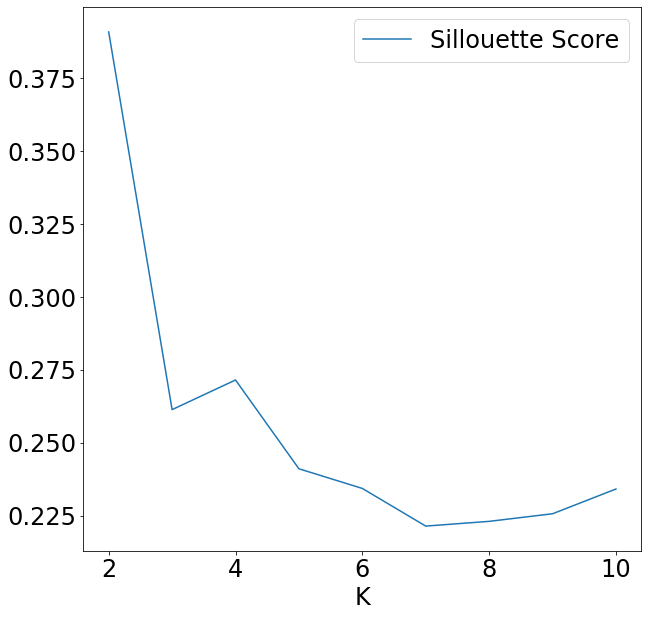

In [7]:
clus(train,2,10)

### Cluster with Optimal Number of Cluster

In [8]:
# Looks like cluster number of 2 is best. Clustering is then done with this
clusterer = KMeans(2, random_state = 123)
cluster_labels = clusterer.fit_predict(train)

### Scale Back

In [9]:
target_name = 'Median Household Income (Current Year $)'
X_cols_names = [name for name in train.columns if name != target_name]

train[target_name]=y_scale.inverse_transform(train[[target_name]])
train[X_cols_names]=x_scale.inverse_transform(train[X_cols_names])
train.head(10)

Total Population  Median Household Income (Current Year $)  \
0            4051.0                                  68242.12   
1            2329.0                                  88172.37   
2            5276.0                                 103853.38   
3            5967.0                                  82796.63   
4            4236.0                                  91648.22   
5            3939.0                                 301209.74   
6            4923.0                                  44841.42   
7            4032.0                                  78821.71   
8            6488.0                                  52939.18   
9            5542.0                                 189620.73   

   Total Households For Period Of Construction Built Before 1961  \
0                                           0.224150               
1                                           0.903509               
2                                           0.001449               
3                                           0.060372               
4                                           0.000000               
5                                           0.535741               
6                                           0.209520               
7                                           0.274675               
8                                           0.143498               
9                                           0.008662               

   Total Households For Period Of Construction Built Between 1961 And 1980  \
0                                           0.138099                         
1                                           0.068226                         
2                                           0.293095                         
3                                           0.769405                         
4                                           0.004933                         
5                                           0.091046                         
6                                           0.474369                         
7                                           0.237013                         
8                                           0.571921                         
9                                           0.361405                         

   Total Households For Period Of Construction Built Between 1981 And 190  \
0                                           0.036780                        
1                                           0.014620                        
2                                           0.273781                        
3                                           0.112574                        
4                                           0.089500                        
5                                           0.063205                        
6                                           0.095606                        
7                                           0.216883                        
8                                           0.149707                        
9                                           0.098171                        

   Total Households For Period Of Construction Built Between 1991 And 2000  \
0                                           0.126301                         
1                                           0.002924                         
2                                           0.314341                         
3                                           0.035860                         
4                                           0.661029                         
5                                           0.104590                         
6                                           0.090724                         
7                                           0.179870                         
8                                           0.085547                         
9                                           0.14437

### Put Predicted Cluster into Original DataFrame

In [10]:
# Label each entry with cluster label
train['Cluster'] = cluster_labels
train['Cluster'].value_counts()

0    3151
1    1777
Name: Cluster, dtype: int64

### Summary Stats of Each Cluster

In [11]:
funs={'min','mean','median', 'max','std'}
summary = train.groupby(['Cluster'], as_index = False).agg({
       'Total Population': funs, 
       'Median Household Income (Current Year $)': funs,
       'Total Households For Period Of Construction Built Before 1961': funs,
       'Total Households For Period Of Construction Built Between 1961 And 1980': funs,
       'Total Households For Period Of Construction Built Between 1981 And 190': funs,
       'Total Households For Period Of Construction Built Between 1991 And 2000': funs,
       'Total Households For Period Of Construction Built Between 2001 And 2005': funs,
       'Total Households For Structure Type Houses': funs,
       'Total Households For Structure Type Apartment, Building Low And High Rise' : funs,
       'Dwellings by Tenure Owner': funs,
       'PercentTenureHouseholds': funs,
       'IndividualsPerHousehold': funs,
        })
summary.transpose()

0  \
Cluster                                                         0.000000   
Total Population                                   std       2587.794643   
                                                   median    4836.000000   
                                                   max      30789.000000   
                                                   mean      5140.632180   
                                                   min         60.000000   
Median Household Income (Current Year $)           std      30569.579900   
                                                   median   88155.970000   
                                                   max     669559.560000   
                                                   mean     90816.288274   
                                                   min      34461.090000   
Total Households For Period Of Construction Bui... std          0.206788   
                                                   median       0.075082   
                                                   max          0.954651   
                                                   mean         0.162198   
                                                   min          0.000000   
Total Households For Period Of Construction Bui... std          0.220755   
                                                   median       0.256015   
                                                   max          0.948235   
                                                   mean         0.288050   
                                                   min          0.000000   
Total Households For Period Of Construction Bui... std          0.146220   
                                                   median       0.116851   
                                                   max          0.892185   
                                                   mean         0.155105   
                                                   min          0.000000   
Total Households For Period Of Construction Bui... std          0.142446   
                                                   median       0.104423   
                                                   max          0.891108   
                                                   mean         0.144789   
                                                   min          0.000000   
Total Households For Period Of Construction Bui... std          0.111652   
                                                   median       0.043478   
                                                   max          0.862573   
                                                   mean         0.082041   
                                                   min          0.000000   
Total Households For Structure Type Houses         std          0.137872   
                                                   median       0.838132   
                                                   max          1.000000   
                                                   mean         0.817268   
                                                   min          0.075188   
Total Households For Structure Type Apartment, ... std          0.135905   
                                                   median       0.148057   
                                                   max          0.600821   
                                                   mean         0.170095   
                                                   min          0.000000   
Dwellings by Tenure Owner                          std          0.124780   
                                                   median       0.827403   
                                                   max          1.000000   
                                                   mean         0.802935   
                                                   min          0.000000   
PercentTenureHouseholds                            std          0.031057   
                                           

### Getting Ready for Graph

In [12]:
numerical_variables_plot = [target_name] + X_cols_names

cluster_1 = train[train['Cluster']==0]
cluster_2 = train[train['Cluster']==1]

### Compare single Feature Across Clusters

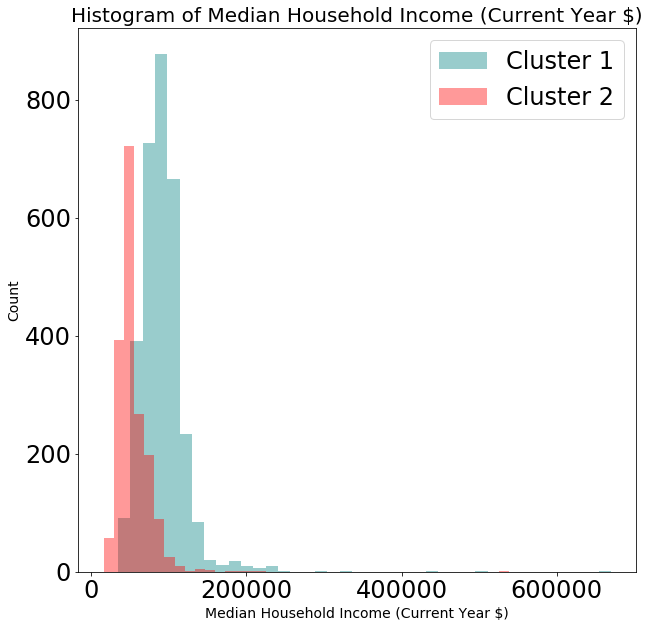

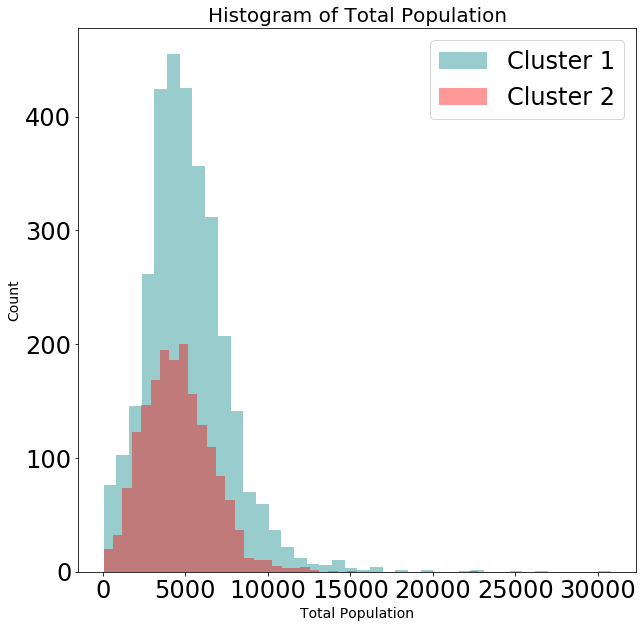

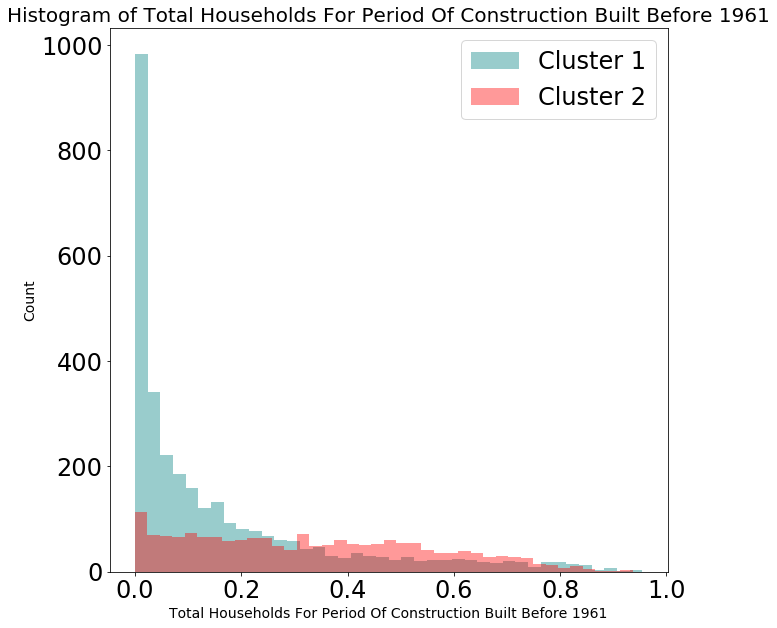

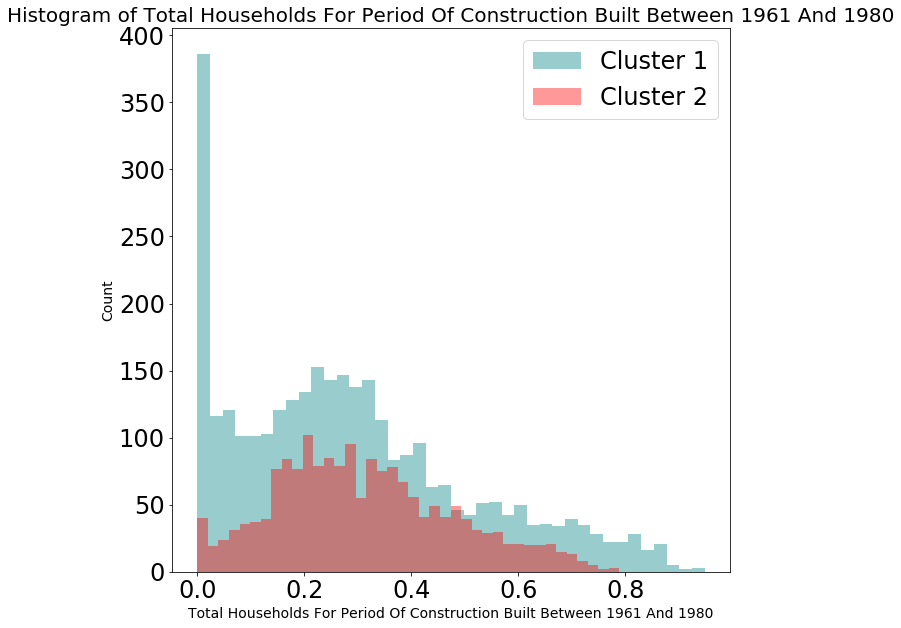

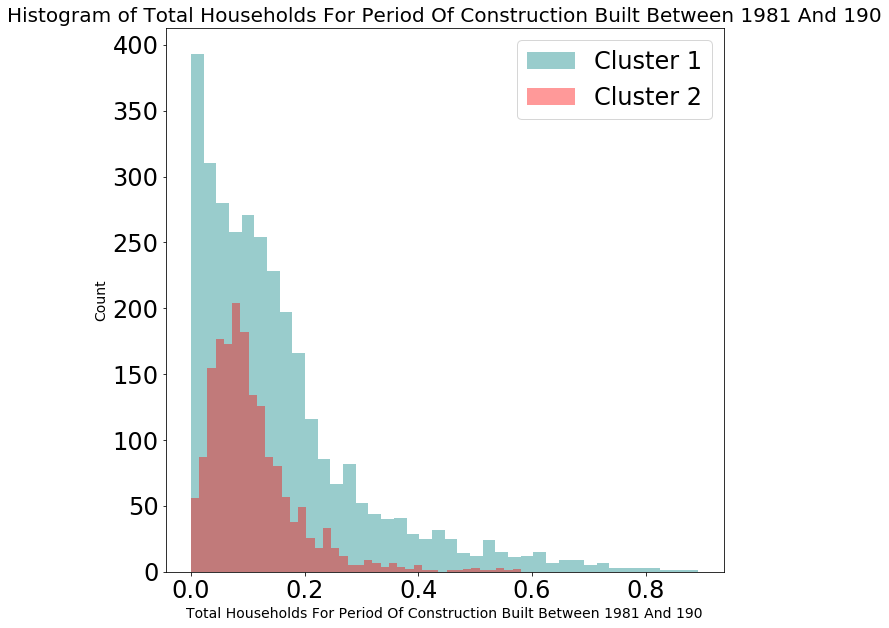

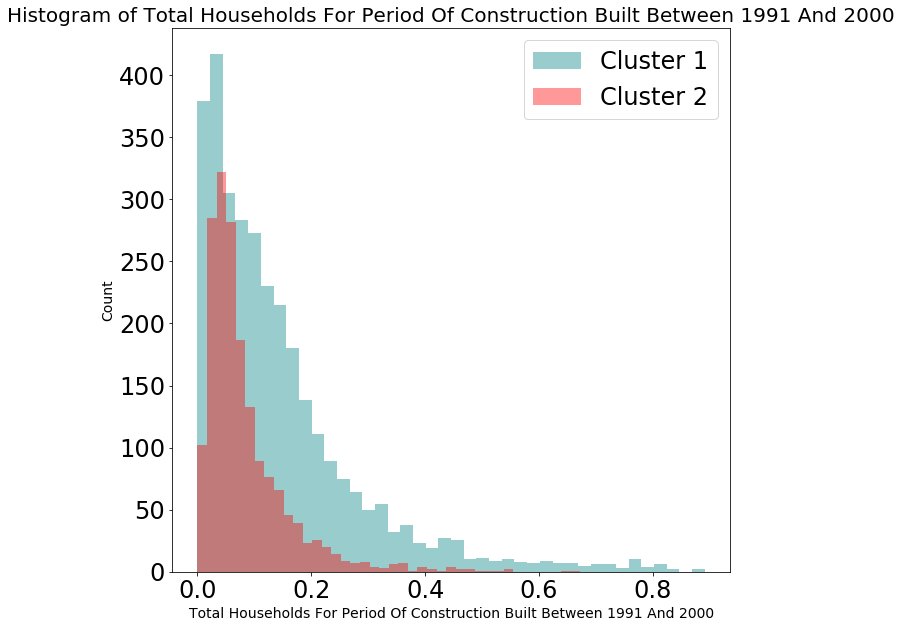

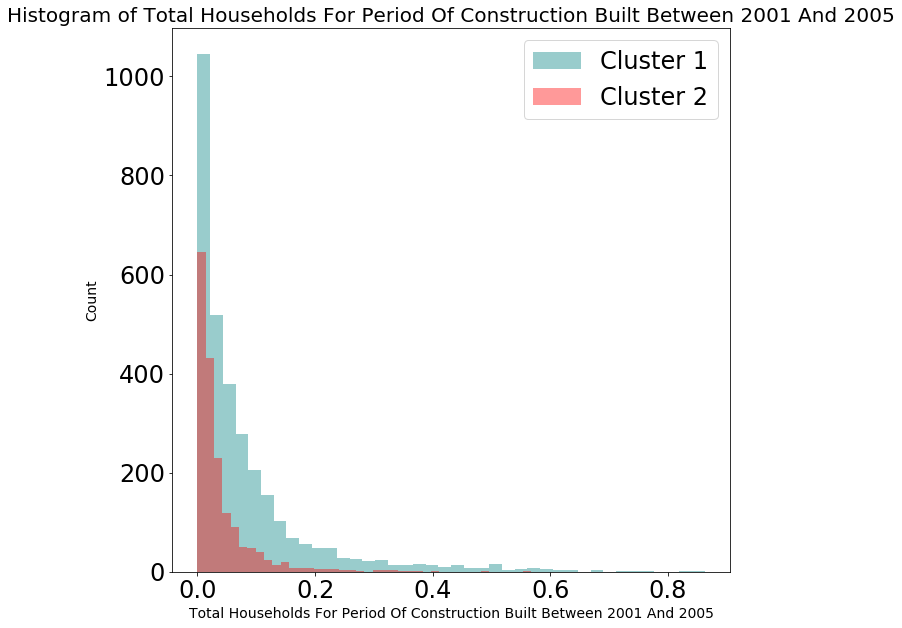

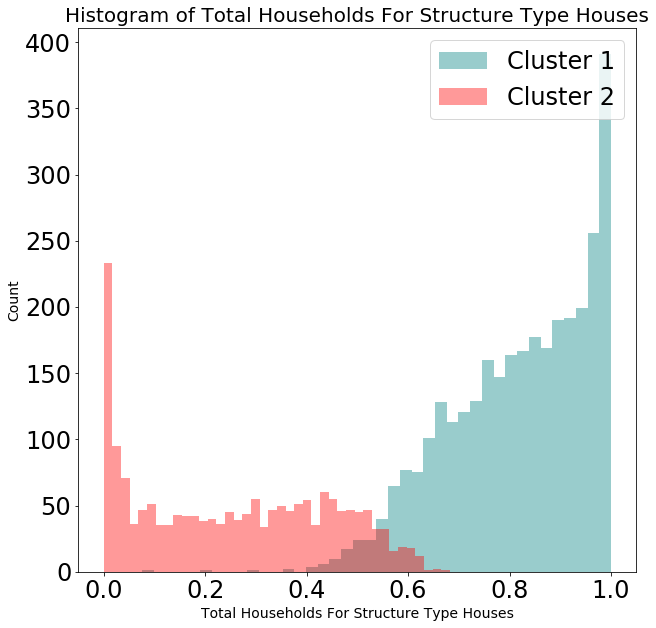

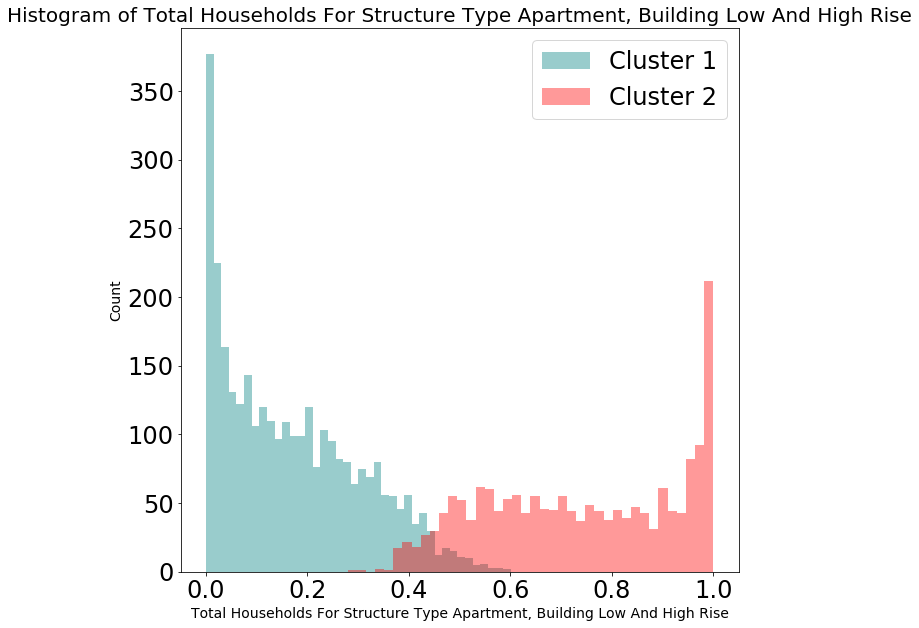

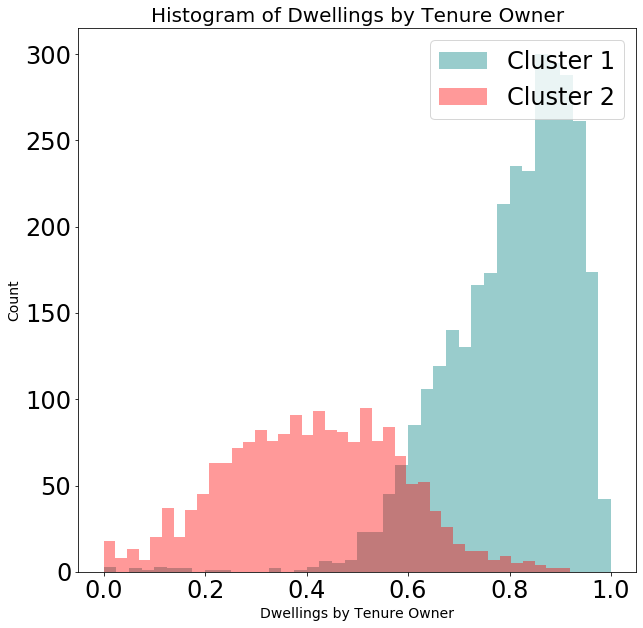

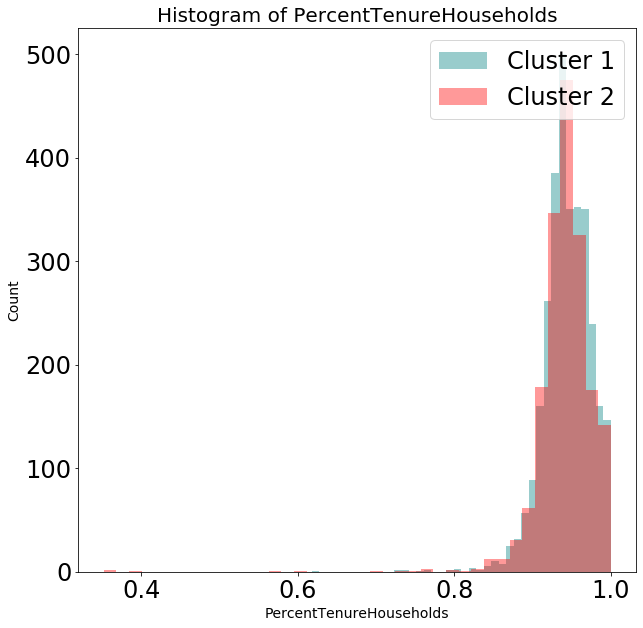

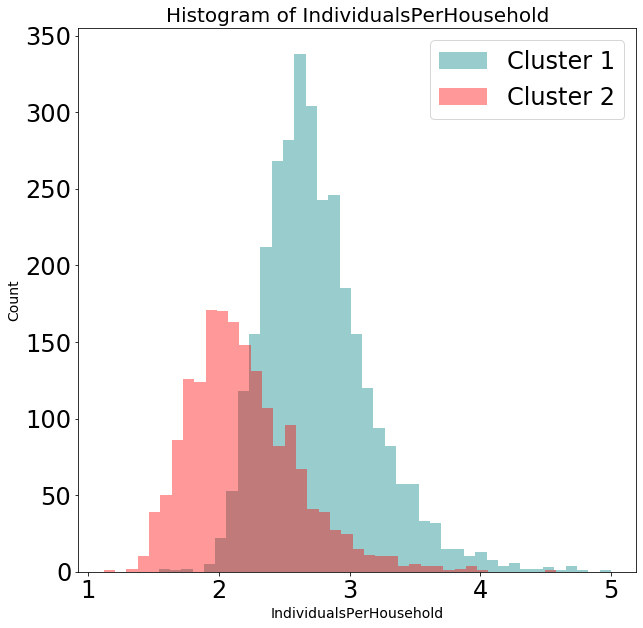

In [13]:
for i in range(len(numerical_variables_plot)):
    plt.figure(figsize = (10,10))
    plt.title("Histogram of " + str(numerical_variables_plot[i]), fontsize = 20)
    plt.hist(cluster_1[numerical_variables_plot[i]], bins=40, color = 'teal', alpha=.4, label = 'Cluster 1')
    plt.hist(cluster_2[numerical_variables_plot[i]], bins=40, color = 'red', alpha=.4, label = 'Cluster 2')
    plt.legend(loc='upper right')
    plt.xlabel(str(numerical_variables_plot[i]),fontsize = 14)
    plt.ylabel("Count",fontsize = 14)
    plt.show()

### Scatter Plots with 2 Features and Cluster as Color

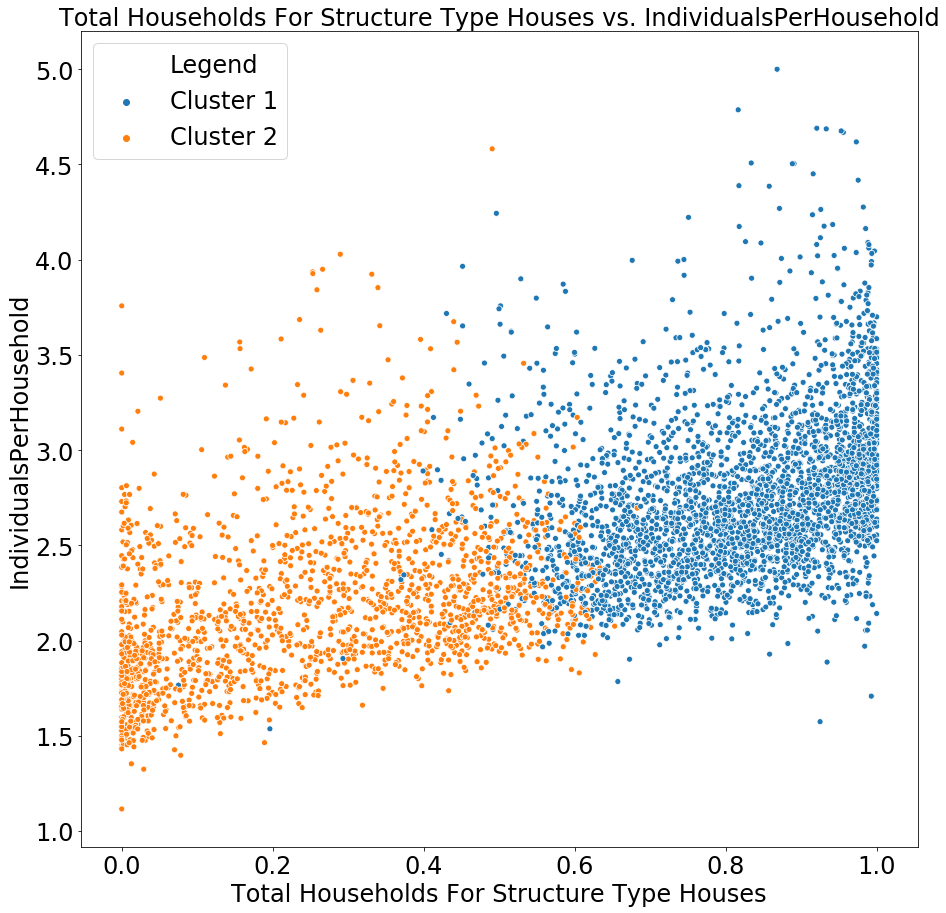

In [14]:
plt.title(str(numerical_variables_plot[7]) + ' vs. ' + str(numerical_variables_plot[11]))
g = sns.scatterplot(x = train[numerical_variables_plot[7]], y = train[numerical_variables_plot[11]], hue = train['Cluster'])
legend = g.legend_
legend.get_texts()[0].set_text('Legend')
labels=['Cluster 1', 'Cluster 2']
# Set legend labels
for i, label in enumerate(labels):
    # i+1 because i=0 is the title, and i starts at 0
    legend.get_texts()[i+1].set_text(label) 
plt.show()

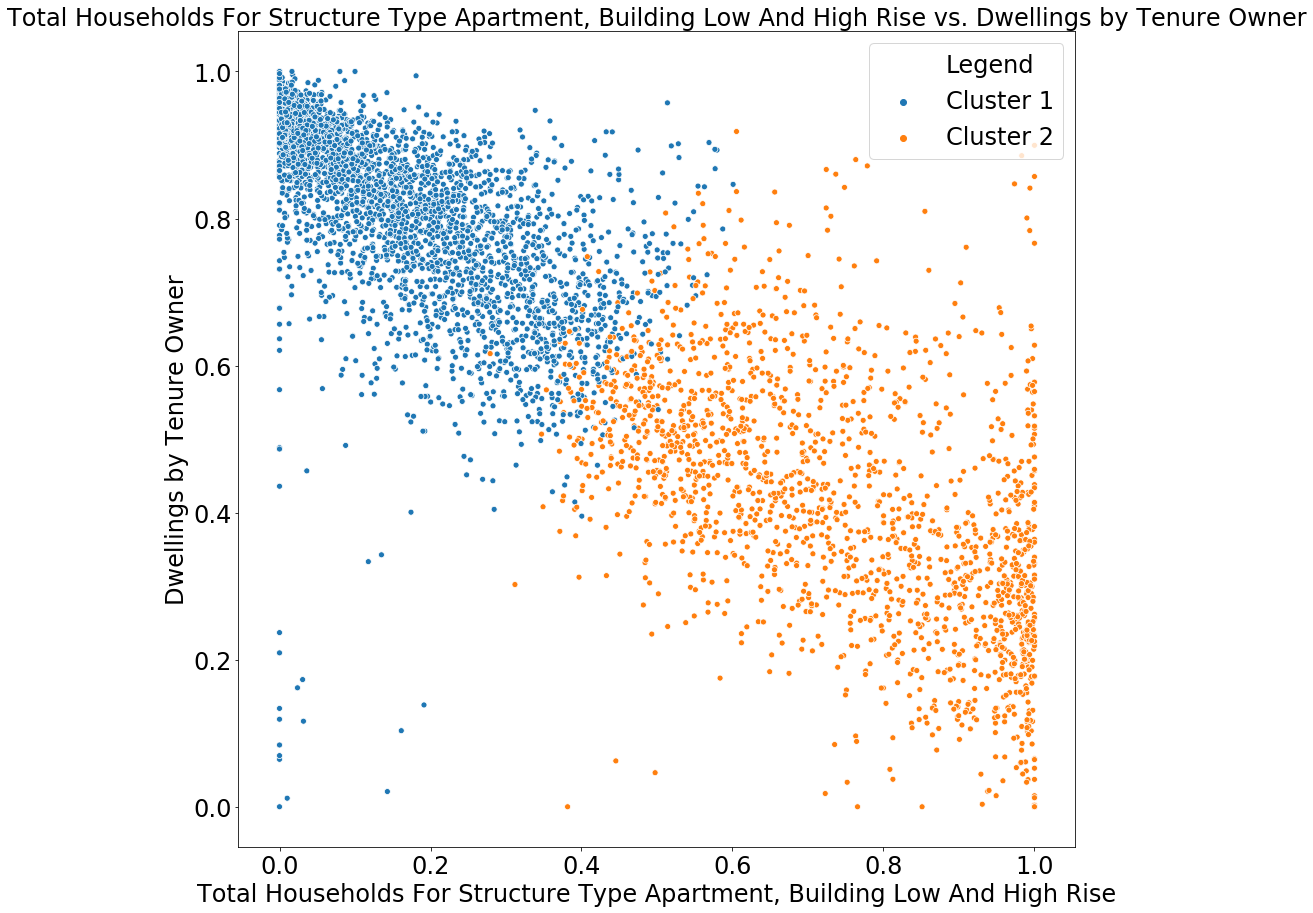

In [15]:
plt.title(str(numerical_variables_plot[8]) + ' vs. ' + str(numerical_variables_plot[9]))
g = sns.scatterplot(x = train[numerical_variables_plot[8]], y = train[numerical_variables_plot[9]], hue = train['Cluster'])
legend = g.legend_
legend.get_texts()[0].set_text('Legend')
labels=['Cluster 1', 'Cluster 2']
# Set legend labels
for i, label in enumerate(labels):
    # i+1 because i=0 is the title, and i starts at 0
    legend.get_texts()[i+1].set_text(label) 
plt.show()

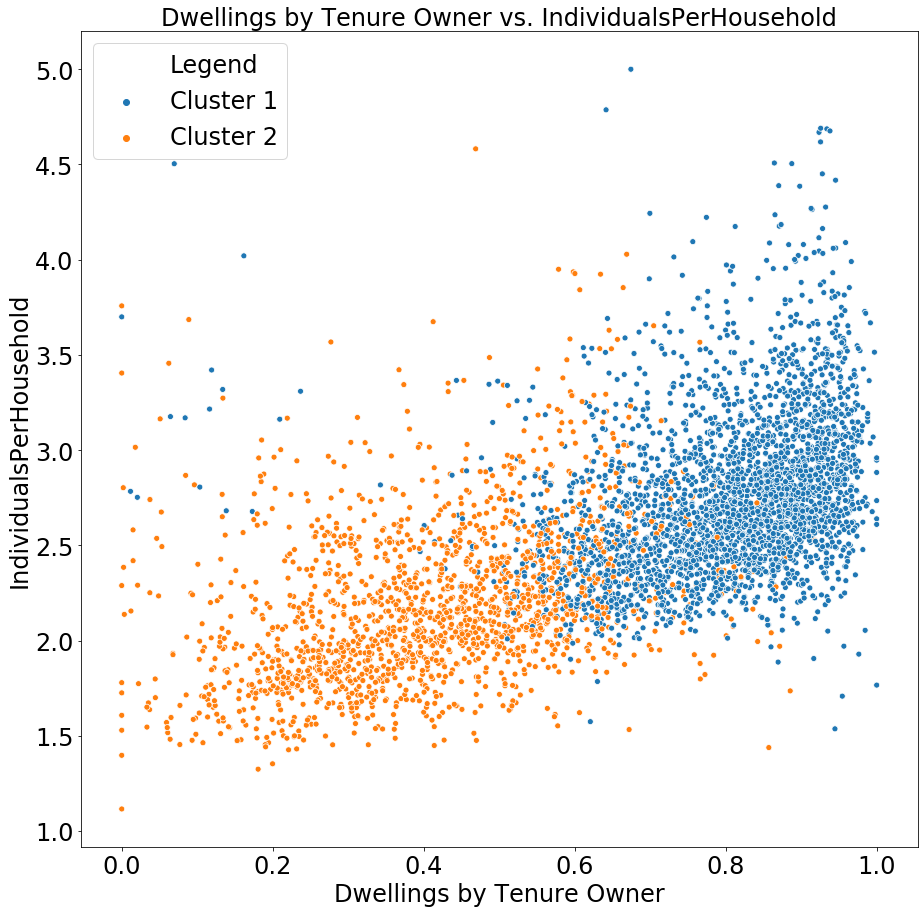

In [16]:
plt.title(str(numerical_variables_plot[9]) + ' vs. ' + str(numerical_variables_plot[11]))
g = sns.scatterplot(x = train[numerical_variables_plot[9]], y = train[numerical_variables_plot[11]], hue = train['Cluster'])
legend = g.legend_
legend.get_texts()[0].set_text('Legend')
labels=['Cluster 1', 'Cluster 2']
# Set legend labels
for i, label in enumerate(labels):
    # i+1 because i=0 is the title, and i starts at 0
    legend.get_texts()[i+1].set_text(label) 
plt.show()

## BIRCH

### Prep Data for BIRCH

In [17]:
train = data.copy()
x_scale, y_scale = prep_data(train)

thresholds = [0.4, 0.45, 0.5, 0.55]
branching_factors = [2,3,4,5]
n_clusters = list(range(2,11))

### Define BIRCH Function

In [18]:
def tune_birch(train, thresholds, branching_factors):
    '''
    train: DF
    thresholds: float
    branching_factors: float
    returns: optimal parameters
    '''
    sillouete_birch = []
    for threshold in thresholds:
        for branching_factor in branching_factors:
            for n_clusterss in n_clusters:
                brc = Birch(threshold = threshold, branching_factor = branching_factor, n_clusters = n_clusterss)
                brc_labels = brc.fit_predict(train)
                if len(np.unique(brc_labels)) == 1:
                    continue
                silouette_avg = silhouette_score(train, brc_labels)
                print("for threshold = ", threshold, "and branching factor = ", branching_factor, "and number of clusters = ", n_clusterss, " The Average silhouette score is: ", silouette_avg)
                sillouete_birch.append(silouette_avg)
                if silouette_avg >= max(sillouete_birch):
                    best_param = [branching_factor, threshold, n_clusterss]
    return best_param, sillouete_birch

### Find Best BIRCH Parameters

In [19]:
results=tune_birch(train, thresholds, branching_factors)

for threshold =  0.4 and branching factor =  2 and number of clusters =  2  The Average silhouette score is:  0.3857699056004526
for threshold =  0.4 and branching factor =  2 and number of clusters =  3  The Average silhouette score is:  0.3506823396675245
for threshold =  0.4 and branching factor =  2 and number of clusters =  4  The Average silhouette score is:  0.26181566606724155
for threshold =  0.4 and branching factor =  2 and number of clusters =  5  The Average silhouette score is:  0.22068695116112805
for threshold =  0.4 and branching factor =  2 and number of clusters =  6  The Average silhouette score is:  0.19740337986741843
for threshold =  0.4 and branching factor =  2 and number of clusters =  7  The Average silhouette score is:  0.19722994313365574
for threshold =  0.4 and branching factor =  2 and number of clusters =  8  The Average silhouette score is:  0.19015016140253152
for threshold =  0.4 and branching factor =  2 and number of clusters =  9  The Average silh

C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (5) by Birch is less than (6). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.45 and branching factor =  2 and number of clusters =  6  The Average silhouette score is:  0.2259238043853787


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (5) by Birch is less than (7). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.45 and branching factor =  2 and number of clusters =  7  The Average silhouette score is:  0.2259238043853787


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (5) by Birch is less than (8). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.45 and branching factor =  2 and number of clusters =  8  The Average silhouette score is:  0.2259238043853787


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (5) by Birch is less than (9). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.45 and branching factor =  2 and number of clusters =  9  The Average silhouette score is:  0.2259238043853787


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (5) by Birch is less than (10). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.45 and branching factor =  2 and number of clusters =  10  The Average silhouette score is:  0.2259238043853787
for threshold =  0.45 and branching factor =  3 and number of clusters =  2  The Average silhouette score is:  0.39204514684651953
for threshold =  0.45 and branching factor =  3 and number of clusters =  3  The Average silhouette score is:  0.2594799963705552
for threshold =  0.45 and branching factor =  3 and number of clusters =  4  The Average silhouette score is:  0.2671856840732179
for threshold =  0.45 and branching factor =  3 and number of clusters =  5  The Average silhouette score is:  0.2230608496560166


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (5) by Birch is less than (6). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.45 and branching factor =  3 and number of clusters =  6  The Average silhouette score is:  0.2230608496560166


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (5) by Birch is less than (7). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.45 and branching factor =  3 and number of clusters =  7  The Average silhouette score is:  0.2230608496560166


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (5) by Birch is less than (8). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.45 and branching factor =  3 and number of clusters =  8  The Average silhouette score is:  0.2230608496560166


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (5) by Birch is less than (9). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.45 and branching factor =  3 and number of clusters =  9  The Average silhouette score is:  0.2230608496560166


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (5) by Birch is less than (10). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.45 and branching factor =  3 and number of clusters =  10  The Average silhouette score is:  0.2230608496560166
for threshold =  0.45 and branching factor =  4 and number of clusters =  2  The Average silhouette score is:  0.39204514684651953
for threshold =  0.45 and branching factor =  4 and number of clusters =  3  The Average silhouette score is:  0.2594799963705552
for threshold =  0.45 and branching factor =  4 and number of clusters =  4  The Average silhouette score is:  0.2671856840732179
for threshold =  0.45 and branching factor =  4 and number of clusters =  5  The Average silhouette score is:  0.2230608496560166


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (5) by Birch is less than (6). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.45 and branching factor =  4 and number of clusters =  6  The Average silhouette score is:  0.2230608496560166


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (5) by Birch is less than (7). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.45 and branching factor =  4 and number of clusters =  7  The Average silhouette score is:  0.2230608496560166


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (5) by Birch is less than (8). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.45 and branching factor =  4 and number of clusters =  8  The Average silhouette score is:  0.2230608496560166


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (5) by Birch is less than (9). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.45 and branching factor =  4 and number of clusters =  9  The Average silhouette score is:  0.2230608496560166


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (5) by Birch is less than (10). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.45 and branching factor =  4 and number of clusters =  10  The Average silhouette score is:  0.2230608496560166
for threshold =  0.45 and branching factor =  5 and number of clusters =  2  The Average silhouette score is:  0.3915681826801019
for threshold =  0.45 and branching factor =  5 and number of clusters =  3  The Average silhouette score is:  0.2583115600248521
for threshold =  0.45 and branching factor =  5 and number of clusters =  4  The Average silhouette score is:  0.2712038548266131
for threshold =  0.45 and branching factor =  5 and number of clusters =  5  The Average silhouette score is:  0.22999232892842722


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (5) by Birch is less than (6). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.45 and branching factor =  5 and number of clusters =  6  The Average silhouette score is:  0.22999232892842722


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (5) by Birch is less than (7). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.45 and branching factor =  5 and number of clusters =  7  The Average silhouette score is:  0.22999232892842722


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (5) by Birch is less than (8). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.45 and branching factor =  5 and number of clusters =  8  The Average silhouette score is:  0.22999232892842722


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (5) by Birch is less than (9). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.45 and branching factor =  5 and number of clusters =  9  The Average silhouette score is:  0.22999232892842722


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (5) by Birch is less than (10). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.45 and branching factor =  5 and number of clusters =  10  The Average silhouette score is:  0.22999232892842722
for threshold =  0.5 and branching factor =  2 and number of clusters =  2  The Average silhouette score is:  0.3863252766964109
for threshold =  0.5 and branching factor =  2 and number of clusters =  3  The Average silhouette score is:  0.25812169813165603
for threshold =  0.5 and branching factor =  2 and number of clusters =  4  The Average silhouette score is:  0.21022917728722504


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (4) by Birch is less than (5). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.5 and branching factor =  2 and number of clusters =  5  The Average silhouette score is:  0.21022917728722504


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (4) by Birch is less than (6). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.5 and branching factor =  2 and number of clusters =  6  The Average silhouette score is:  0.21022917728722504


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (4) by Birch is less than (7). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.5 and branching factor =  2 and number of clusters =  7  The Average silhouette score is:  0.21022917728722504


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (4) by Birch is less than (8). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.5 and branching factor =  2 and number of clusters =  8  The Average silhouette score is:  0.21022917728722504


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (4) by Birch is less than (9). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.5 and branching factor =  2 and number of clusters =  9  The Average silhouette score is:  0.21022917728722504


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (4) by Birch is less than (10). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.5 and branching factor =  2 and number of clusters =  10  The Average silhouette score is:  0.21022917728722504
for threshold =  0.5 and branching factor =  3 and number of clusters =  2  The Average silhouette score is:  0.385227790167466
for threshold =  0.5 and branching factor =  3 and number of clusters =  3  The Average silhouette score is:  0.24705910461837682
for threshold =  0.5 and branching factor =  3 and number of clusters =  4  The Average silhouette score is:  0.20654445534639335


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (4) by Birch is less than (5). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.5 and branching factor =  3 and number of clusters =  5  The Average silhouette score is:  0.20654445534639335


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (4) by Birch is less than (6). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.5 and branching factor =  3 and number of clusters =  6  The Average silhouette score is:  0.20654445534639335


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (4) by Birch is less than (7). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.5 and branching factor =  3 and number of clusters =  7  The Average silhouette score is:  0.20654445534639335


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (4) by Birch is less than (8). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.5 and branching factor =  3 and number of clusters =  8  The Average silhouette score is:  0.20654445534639335


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (4) by Birch is less than (9). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.5 and branching factor =  3 and number of clusters =  9  The Average silhouette score is:  0.20654445534639335


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (4) by Birch is less than (10). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.5 and branching factor =  3 and number of clusters =  10  The Average silhouette score is:  0.20654445534639335
for threshold =  0.5 and branching factor =  4 and number of clusters =  2  The Average silhouette score is:  0.3482642764745499
for threshold =  0.5 and branching factor =  4 and number of clusters =  3  The Average silhouette score is:  0.2651645407270672
for threshold =  0.5 and branching factor =  4 and number of clusters =  4  The Average silhouette score is:  0.25808048950040735


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (4) by Birch is less than (5). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.5 and branching factor =  4 and number of clusters =  5  The Average silhouette score is:  0.25808048950040735


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (4) by Birch is less than (6). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.5 and branching factor =  4 and number of clusters =  6  The Average silhouette score is:  0.25808048950040735


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (4) by Birch is less than (7). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.5 and branching factor =  4 and number of clusters =  7  The Average silhouette score is:  0.25808048950040735


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (4) by Birch is less than (8). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.5 and branching factor =  4 and number of clusters =  8  The Average silhouette score is:  0.25808048950040735


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (4) by Birch is less than (9). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.5 and branching factor =  4 and number of clusters =  9  The Average silhouette score is:  0.25808048950040735


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (4) by Birch is less than (10). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.5 and branching factor =  4 and number of clusters =  10  The Average silhouette score is:  0.25808048950040735
for threshold =  0.5 and branching factor =  5 and number of clusters =  2  The Average silhouette score is:  0.3482642764745499
for threshold =  0.5 and branching factor =  5 and number of clusters =  3  The Average silhouette score is:  0.2651645407270672
for threshold =  0.5 and branching factor =  5 and number of clusters =  4  The Average silhouette score is:  0.25808048950040735


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (4) by Birch is less than (5). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.5 and branching factor =  5 and number of clusters =  5  The Average silhouette score is:  0.25808048950040735


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (4) by Birch is less than (6). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.5 and branching factor =  5 and number of clusters =  6  The Average silhouette score is:  0.25808048950040735


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (4) by Birch is less than (7). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.5 and branching factor =  5 and number of clusters =  7  The Average silhouette score is:  0.25808048950040735


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (4) by Birch is less than (8). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.5 and branching factor =  5 and number of clusters =  8  The Average silhouette score is:  0.25808048950040735


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (4) by Birch is less than (9). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.5 and branching factor =  5 and number of clusters =  9  The Average silhouette score is:  0.25808048950040735


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (4) by Birch is less than (10). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.5 and branching factor =  5 and number of clusters =  10  The Average silhouette score is:  0.25808048950040735
for threshold =  0.55 and branching factor =  2 and number of clusters =  2  The Average silhouette score is:  0.39120508548896604


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (3). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.55 and branching factor =  2 and number of clusters =  3  The Average silhouette score is:  0.39120508548896604


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (4). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.55 and branching factor =  2 and number of clusters =  4  The Average silhouette score is:  0.39120508548896604


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (5). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.55 and branching factor =  2 and number of clusters =  5  The Average silhouette score is:  0.39120508548896604


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (6). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.55 and branching factor =  2 and number of clusters =  6  The Average silhouette score is:  0.39120508548896604


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (7). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.55 and branching factor =  2 and number of clusters =  7  The Average silhouette score is:  0.39120508548896604


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (8). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.55 and branching factor =  2 and number of clusters =  8  The Average silhouette score is:  0.39120508548896604


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (9). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.55 and branching factor =  2 and number of clusters =  9  The Average silhouette score is:  0.39120508548896604


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (10). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.55 and branching factor =  2 and number of clusters =  10  The Average silhouette score is:  0.39120508548896604
for threshold =  0.55 and branching factor =  3 and number of clusters =  2  The Average silhouette score is:  0.39120508548896604


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (3). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.55 and branching factor =  3 and number of clusters =  3  The Average silhouette score is:  0.39120508548896604


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (4). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.55 and branching factor =  3 and number of clusters =  4  The Average silhouette score is:  0.39120508548896604


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (5). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.55 and branching factor =  3 and number of clusters =  5  The Average silhouette score is:  0.39120508548896604


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (6). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.55 and branching factor =  3 and number of clusters =  6  The Average silhouette score is:  0.39120508548896604


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (7). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.55 and branching factor =  3 and number of clusters =  7  The Average silhouette score is:  0.39120508548896604


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (8). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.55 and branching factor =  3 and number of clusters =  8  The Average silhouette score is:  0.39120508548896604


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (9). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.55 and branching factor =  3 and number of clusters =  9  The Average silhouette score is:  0.39120508548896604


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (10). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.55 and branching factor =  3 and number of clusters =  10  The Average silhouette score is:  0.39120508548896604
for threshold =  0.55 and branching factor =  4 and number of clusters =  2  The Average silhouette score is:  0.39120508548896604


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (3). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.55 and branching factor =  4 and number of clusters =  3  The Average silhouette score is:  0.39120508548896604


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (4). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.55 and branching factor =  4 and number of clusters =  4  The Average silhouette score is:  0.39120508548896604


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (5). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.55 and branching factor =  4 and number of clusters =  5  The Average silhouette score is:  0.39120508548896604


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (6). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.55 and branching factor =  4 and number of clusters =  6  The Average silhouette score is:  0.39120508548896604


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (7). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.55 and branching factor =  4 and number of clusters =  7  The Average silhouette score is:  0.39120508548896604


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (8). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.55 and branching factor =  4 and number of clusters =  8  The Average silhouette score is:  0.39120508548896604


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (9). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.55 and branching factor =  4 and number of clusters =  9  The Average silhouette score is:  0.39120508548896604


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (10). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.55 and branching factor =  4 and number of clusters =  10  The Average silhouette score is:  0.39120508548896604
for threshold =  0.55 and branching factor =  5 and number of clusters =  2  The Average silhouette score is:  0.39120508548896604


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (3). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.55 and branching factor =  5 and number of clusters =  3  The Average silhouette score is:  0.39120508548896604


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (4). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.55 and branching factor =  5 and number of clusters =  4  The Average silhouette score is:  0.39120508548896604


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (5). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.55 and branching factor =  5 and number of clusters =  5  The Average silhouette score is:  0.39120508548896604


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (6). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.55 and branching factor =  5 and number of clusters =  6  The Average silhouette score is:  0.39120508548896604


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (7). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.55 and branching factor =  5 and number of clusters =  7  The Average silhouette score is:  0.39120508548896604


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (8). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.55 and branching factor =  5 and number of clusters =  8  The Average silhouette score is:  0.39120508548896604


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (9). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.55 and branching factor =  5 and number of clusters =  9  The Average silhouette score is:  0.39120508548896604


C:\Users\ZL\Anaconda3\envs\MISC\lib\site-packages\sklearn\cluster\_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (10). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


for threshold =  0.55 and branching factor =  5 and number of clusters =  10  The Average silhouette score is:  0.39120508548896604


In [20]:
results[0]

[4, 0.45, 2]

### Make predictions and scale back

In [21]:
#looks like threshold =  0.45 and branching factor =  4 and clusters =2 is best
brc = Birch(threshold = 0.45, branching_factor = 4, n_clusters = 2)
brc_labels = brc.fit_predict(train)        

#transform again back to real values
train[target_name]=y_scale.inverse_transform(train[[target_name]])
train[X_cols_names]=x_scale.inverse_transform(train[X_cols_names])
train.head(10)

train['Bir_Cluster'] = brc_labels
train['Bir_Cluster'].value_counts()

0    3301
1    1627
Name: Bir_Cluster, dtype: int64

### Summary stats

In [22]:
funs={'min','mean','median', 'max','std'}
bir_summary = train.groupby(['Bir_Cluster'], as_index = False).agg({
       'Total Population': funs, 
       'Median Household Income (Current Year $)': funs,
       'Total Households For Period Of Construction Built Before 1961': funs,
       'Total Households For Period Of Construction Built Between 1961 And 1980': funs,
       'Total Households For Period Of Construction Built Between 1981 And 190': funs,
       'Total Households For Period Of Construction Built Between 1991 And 2000': funs,
       'Total Households For Period Of Construction Built Between 2001 And 2005': funs,
       'Total Households For Structure Type Houses': funs,
       'Total Households For Structure Type Apartment, Building Low And High Rise' : funs,
       'Dwellings by Tenure Owner': funs,
       'PercentTenureHouseholds': funs,
       'IndividualsPerHousehold': funs,
        })

 ### Visualize cluster characteristics on a single feature each time

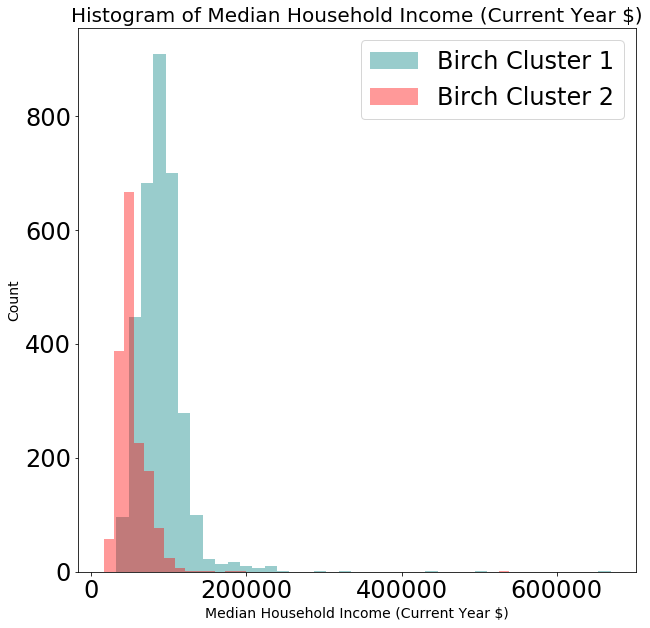

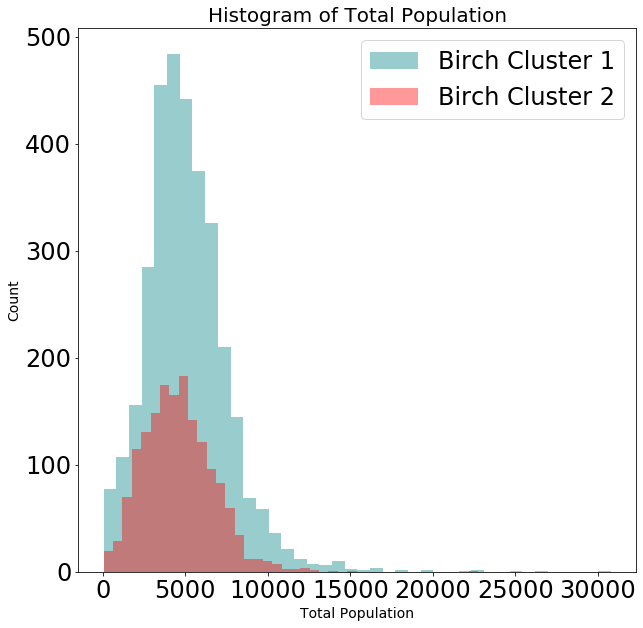

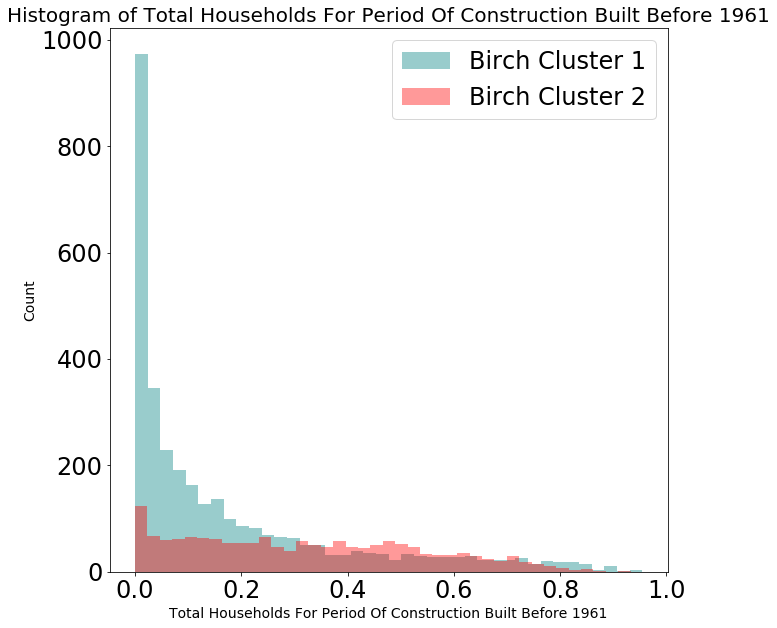

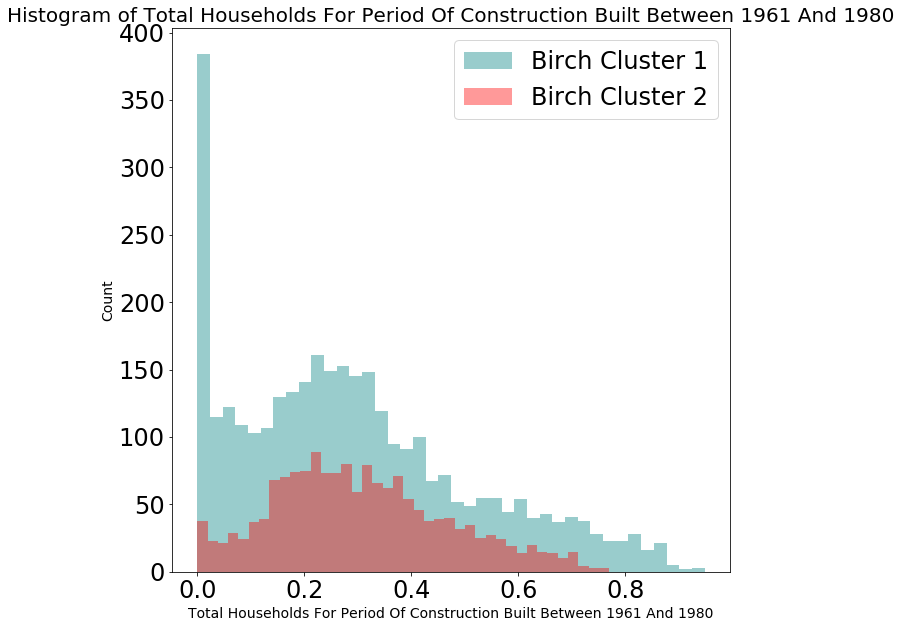

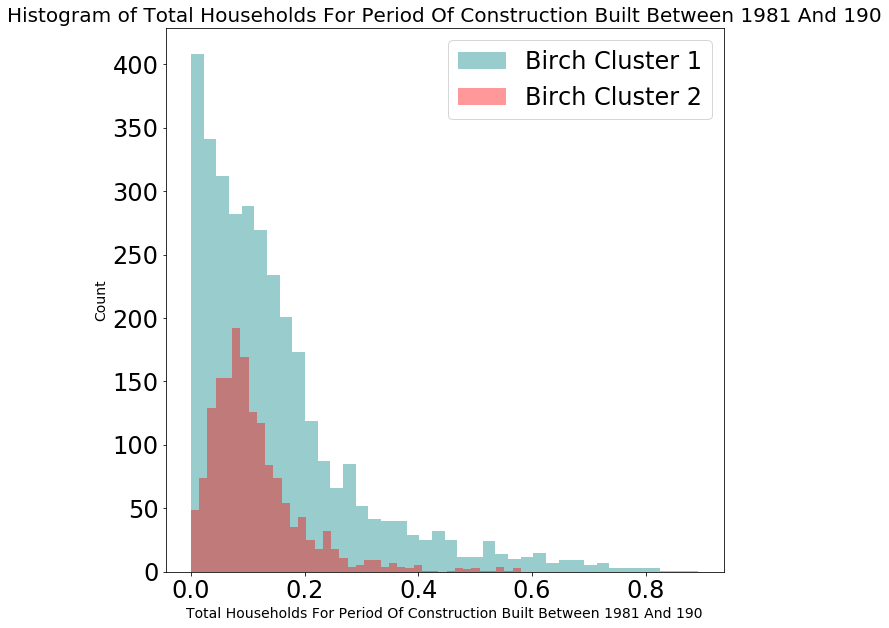

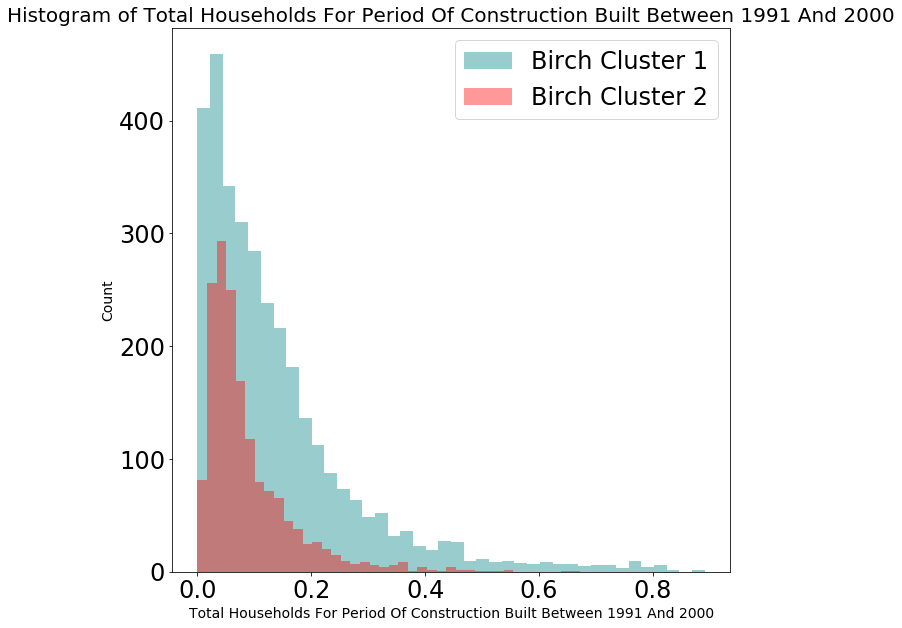

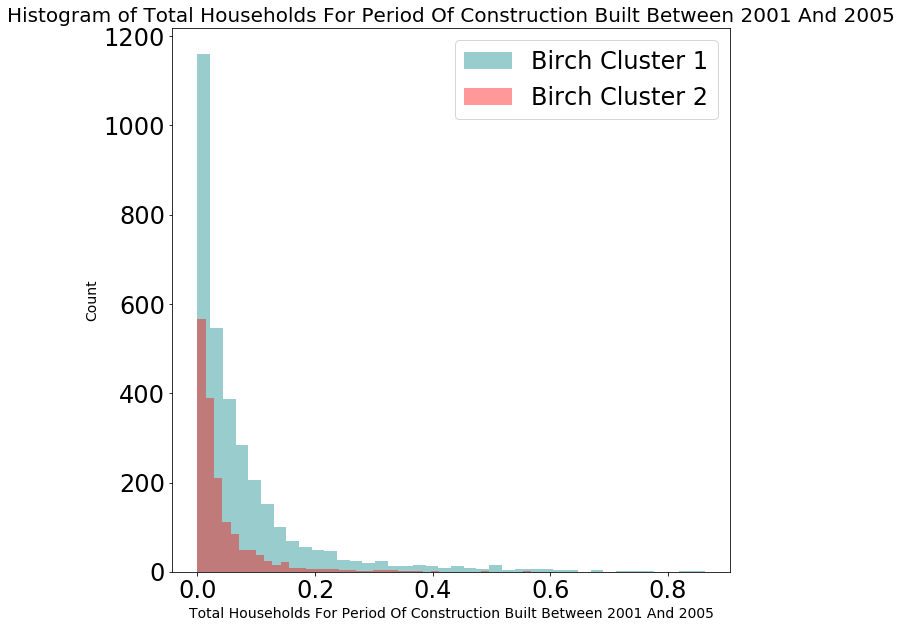

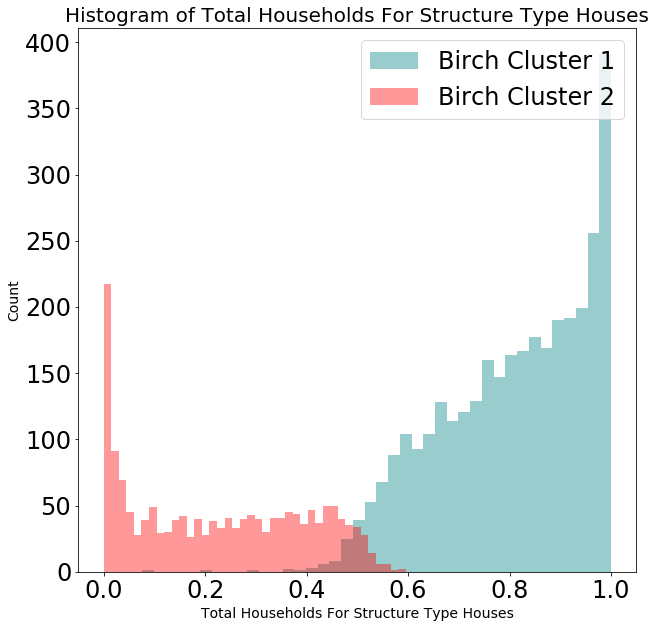

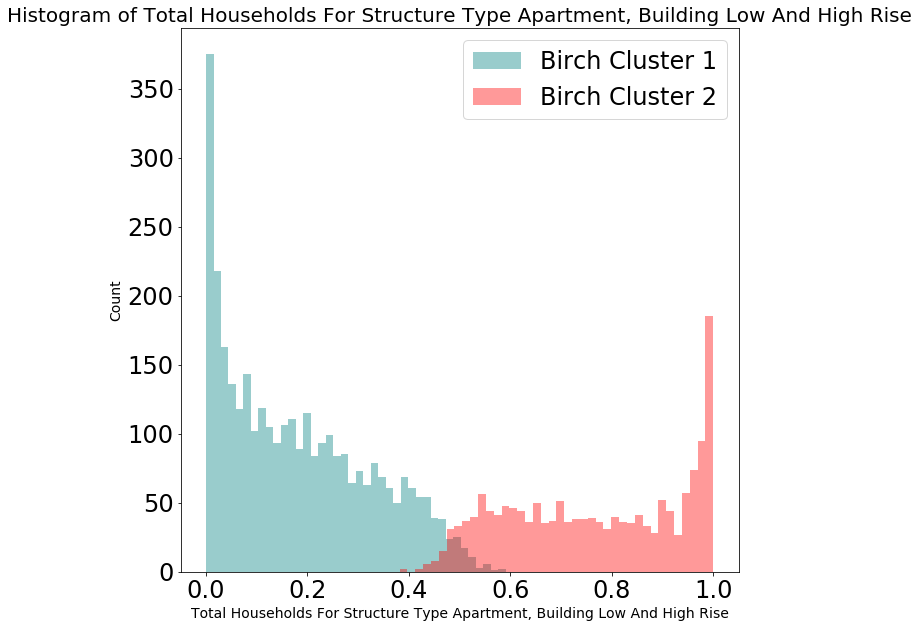

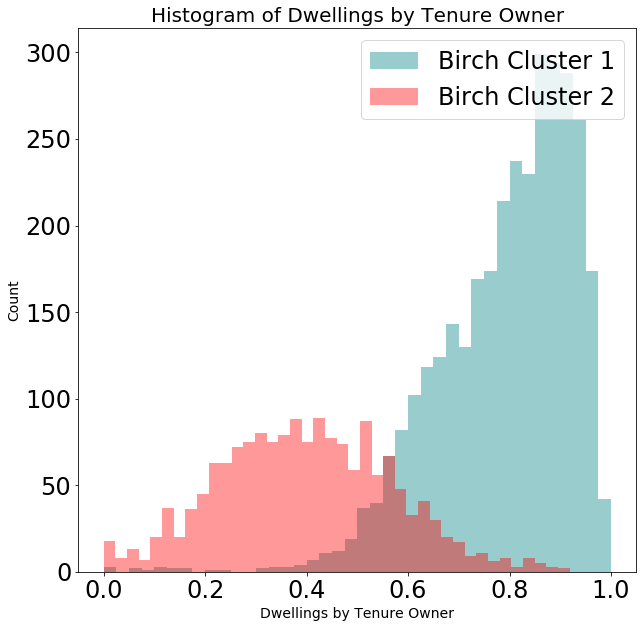

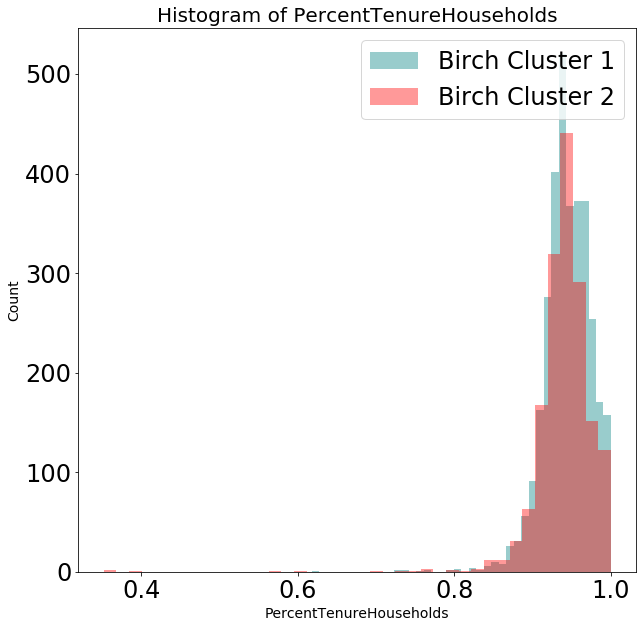

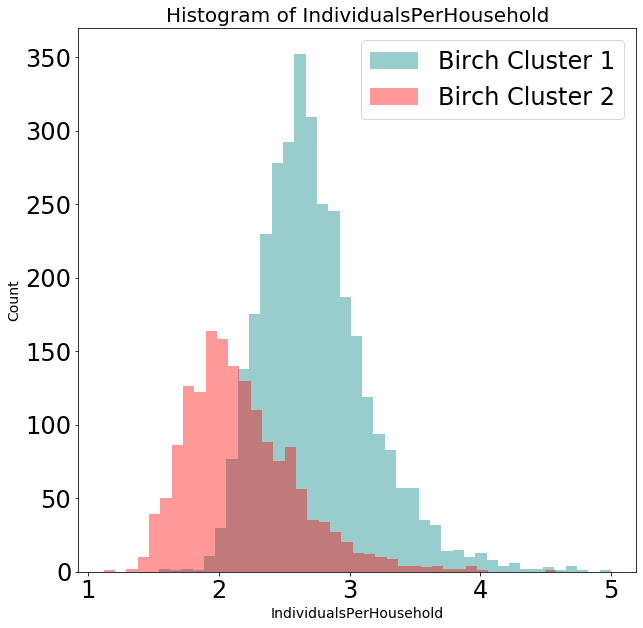

In [23]:
bir_cluster_1 = train[train['Bir_Cluster']==0]
bir_cluster_2 = train[train['Bir_Cluster']==1]

for i in range(len(numerical_variables_plot)):
    plt.figure(figsize = (10,10))
    plt.title("Histogram of " + str(numerical_variables_plot[i]), fontsize = 20)
    plt.hist(bir_cluster_1[numerical_variables_plot[i]], bins=40, color = 'teal', alpha=.4, label = 'Birch Cluster 1')
    plt.hist(bir_cluster_2[numerical_variables_plot[i]], bins=40, color = 'red', alpha=.4, label = 'Birch Cluster 2')
    plt.legend(loc='upper right')
    plt.xlabel(str(numerical_variables_plot[i]),fontsize = 14)
    plt.ylabel("Count",fontsize = 14)
    plt.show()

## Comparing clusters obtained through K-Means and BIRCH

### Compare summary Stats

In [24]:
pd.concat([summary.transpose(), bir_summary.transpose().rename(columns={0: "bir_0", 1: "bir_1"})], axis=1, sort=True)

0  \
Bir_Cluster                                                          NaN   
Cluster                                                         0.000000   
Dwellings by Tenure Owner                          max          1.000000   
                                                   mean         0.802935   
                                                   median       0.827403   
                                                   min          0.000000   
                                                   std          0.124780   
IndividualsPerHousehold                            max          5.000000   
                                                   mean         2.758873   
                                                   median       2.695406   
                                                   min          1.537383   
                                                   std          0.413491   
Median Household Income (Current Year $)           max     669559.560000   
                                                   mean     90816.288274   
                                                   median   88155.970000   
                                                   min      34461.090000   
                                                   std      30569.579900   
PercentTenureHouseholds                            max          1.000000   
                                                   mean         0.943559   
                                                   median       0.943262   
                                                   min          0.617647   
                                                   std          0.031057   
Total Households For Period Of Construction Bui... max          0.954651   
                                                   mean         0.162198   
                                                   median       0.075082   
                                                   min          0.000000   
                                                   std          0.206788   
Total Households For Period Of Construction Bui... max          0.948235   
                                                   mean         0.288050   
                                                   median       0.256015   
                                                   min          0.000000   
                                                   std          0.220755   
Total Households For Period Of Construction Bui... max          0.892185   
                                                   mean         0.155105   
                                                   median       0.116851   
                                                   min          0.000000   
                                                   std          0.146220   
Total Households For Period Of Construction Bui... max          0.891108   
                                                   mean         0.144789   
                                                   median       0.104423   
                                                   min          0.000000   
                                                   std          0.142446   
Total Households For Period Of Construction Bui... max          0.862573   
                                                   mean         0.082041   
                                                   median       0.043478   
                                                   min          0.000000   
                                                   std          0.111652   
Total Households For Structure Type Apartment, ... max          0.600821   
                                                   mean         0.170095   
                                                   median       0.148057   
                                                   min          0.000000   
                                                   std          0.135905   
Total Households For Structure Type Houses 

 K-Means and BIRCH give similar clusters

# Part 2: Find Best number of clusters and corresponding Regressing Models based on MSE

For Different number of clusters, try different regressing algorithm for each cluster, find the overall best approach with lowest MSE

In [25]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

## Prep data

In [26]:
##Create copy
clean = data.copy()

##Prep data without correlated featre
x_scale, y_scale = prep_data(clean, drop_correlated = True)

##Set predictors names to distinguish from target
predictors = [p for p in clean.columns if p != target_name]

##Train test split
train, validate = train_test_split(clean, test_size = .25, random_state =10)

## Initiate Storage

In [27]:
num_clusters_list = range(1,11)

##Store weighted average MSE for number of clusters
cluster_mse = []

##Store all MSEs
mse_store = []

##Store best models
all_best_models = []

##Store best model names
all_best_names = []

## Find best number of Clusters, and best Regressing models for each cluster

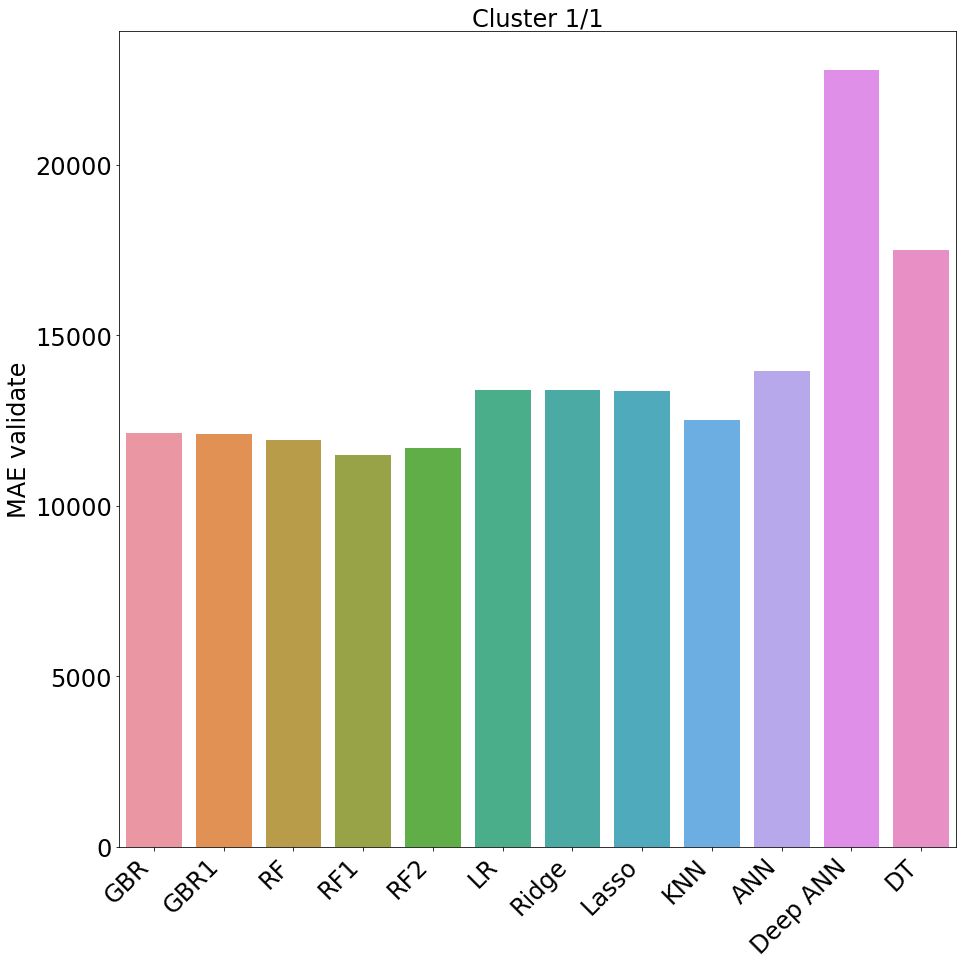

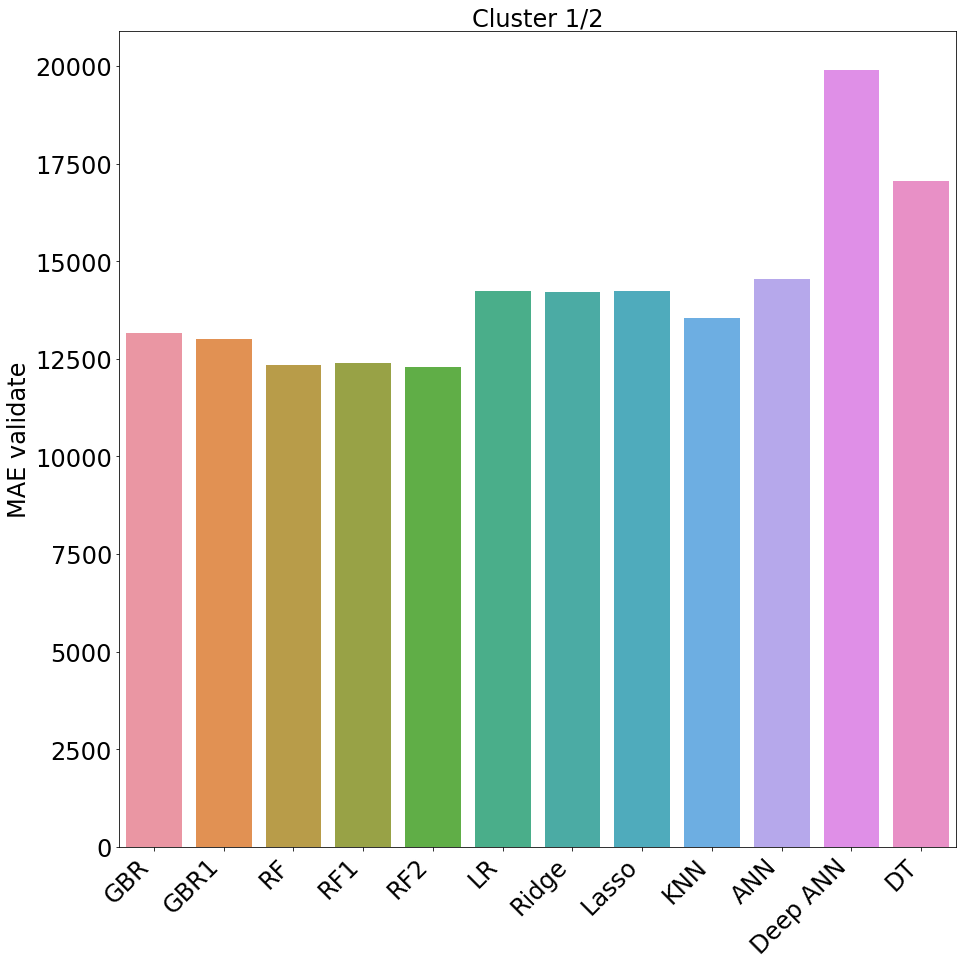

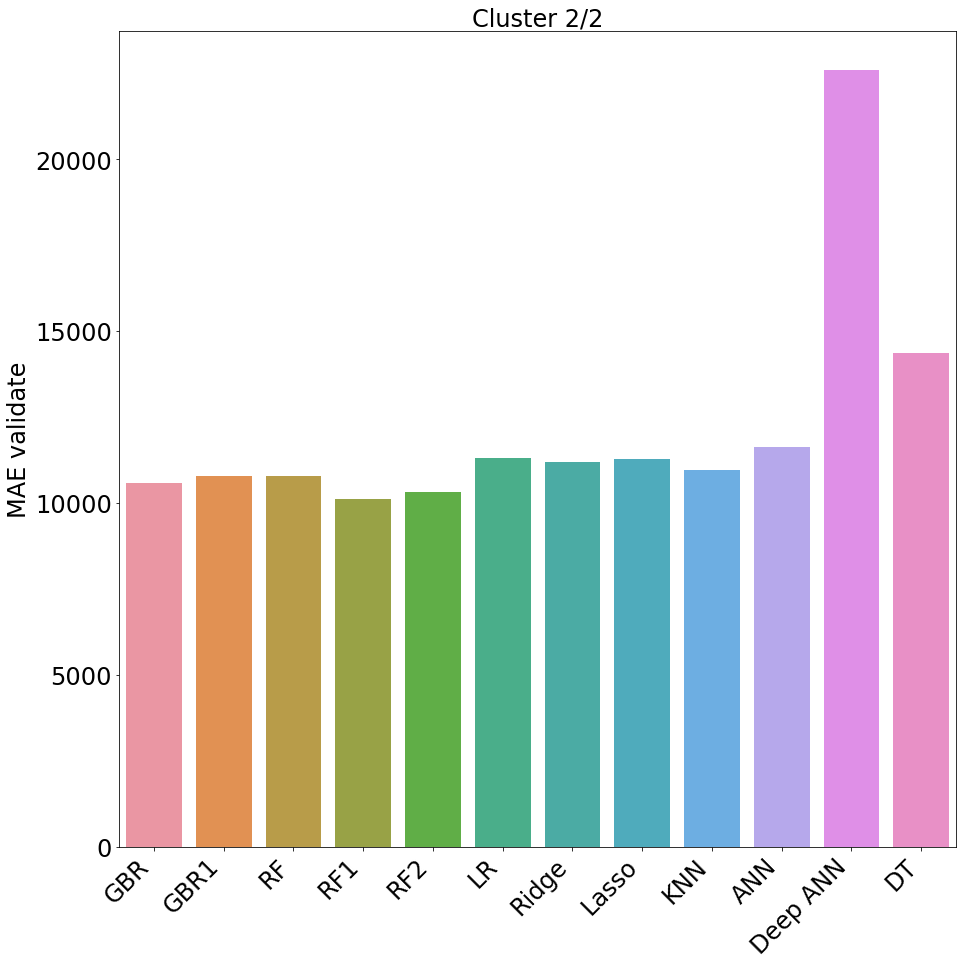

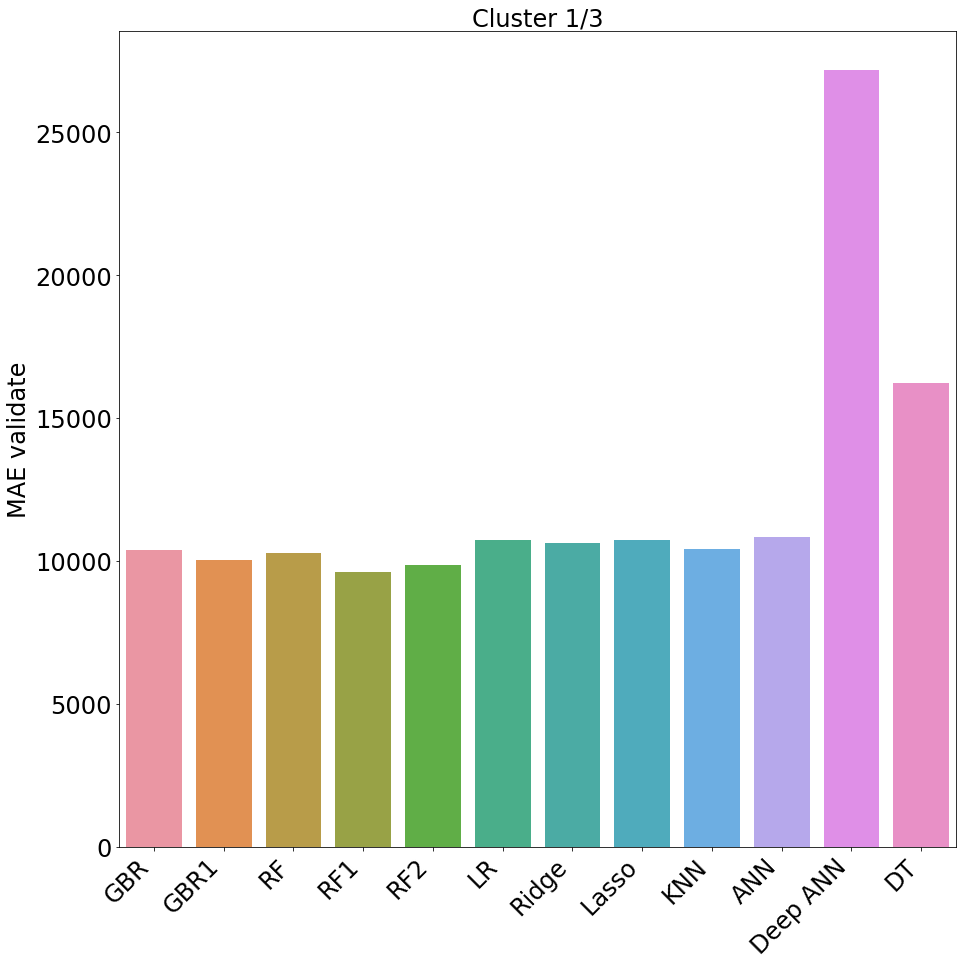

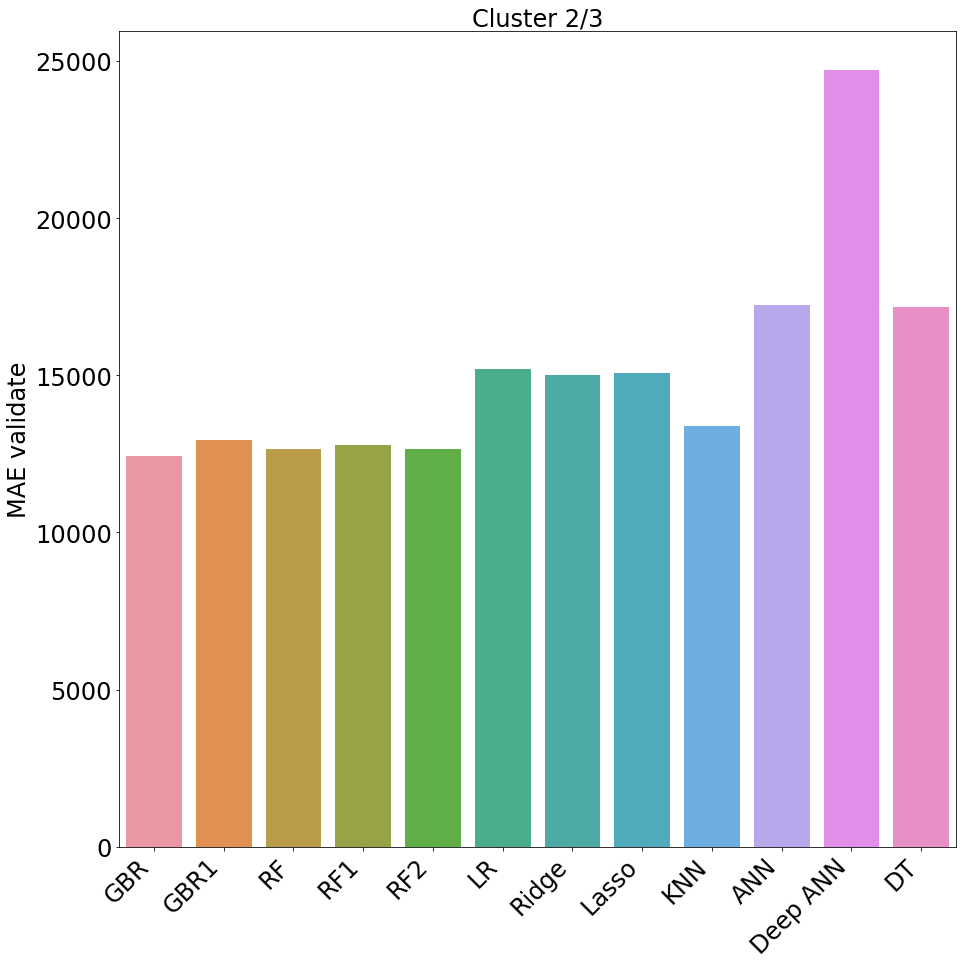

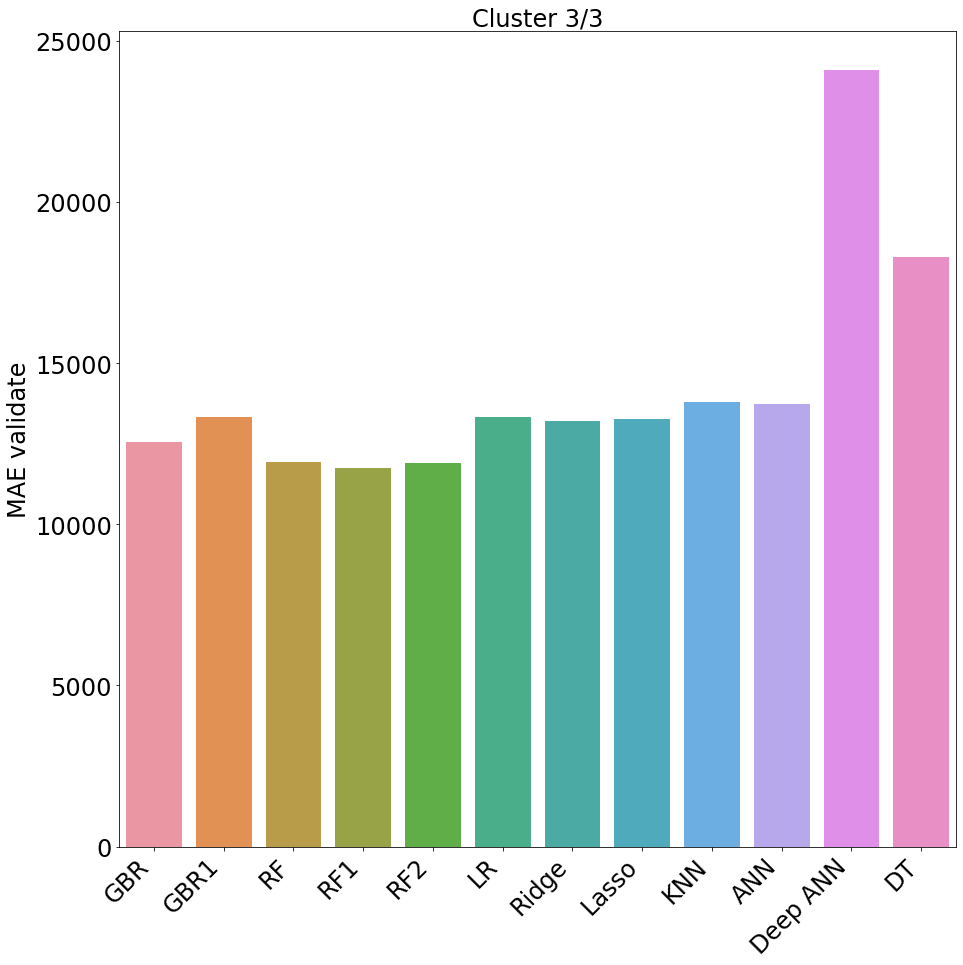

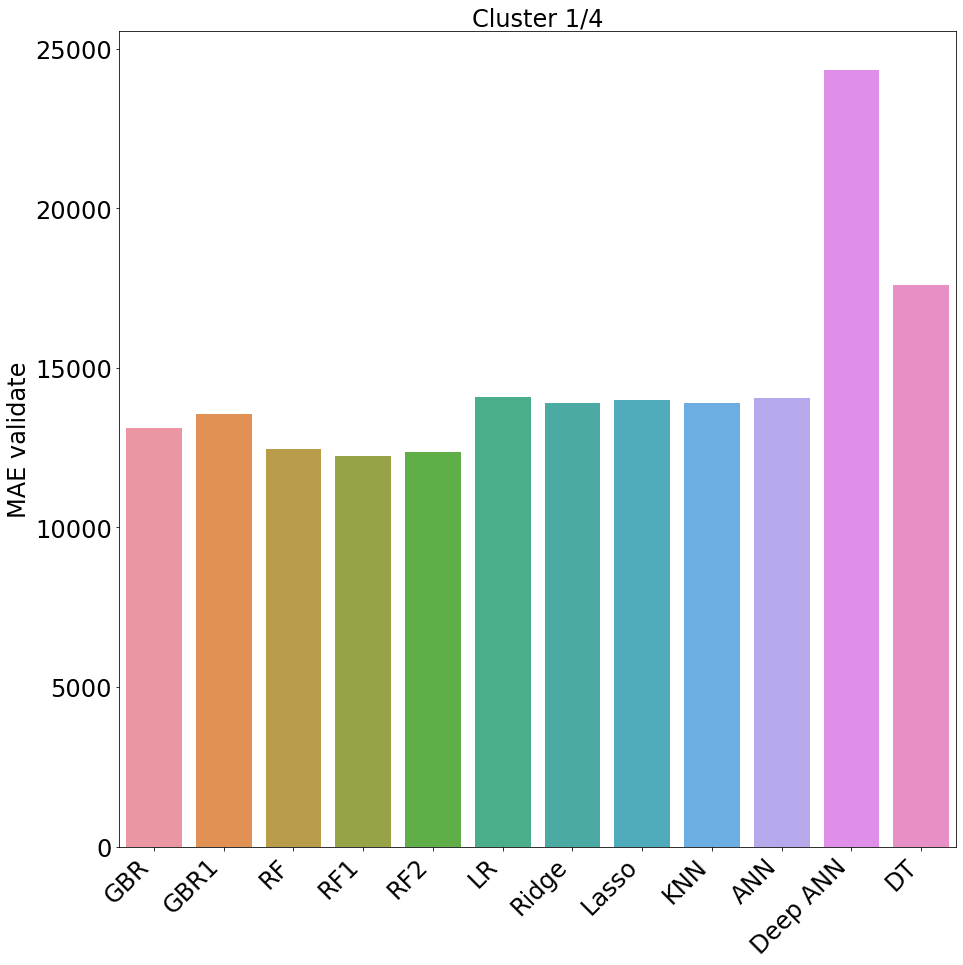

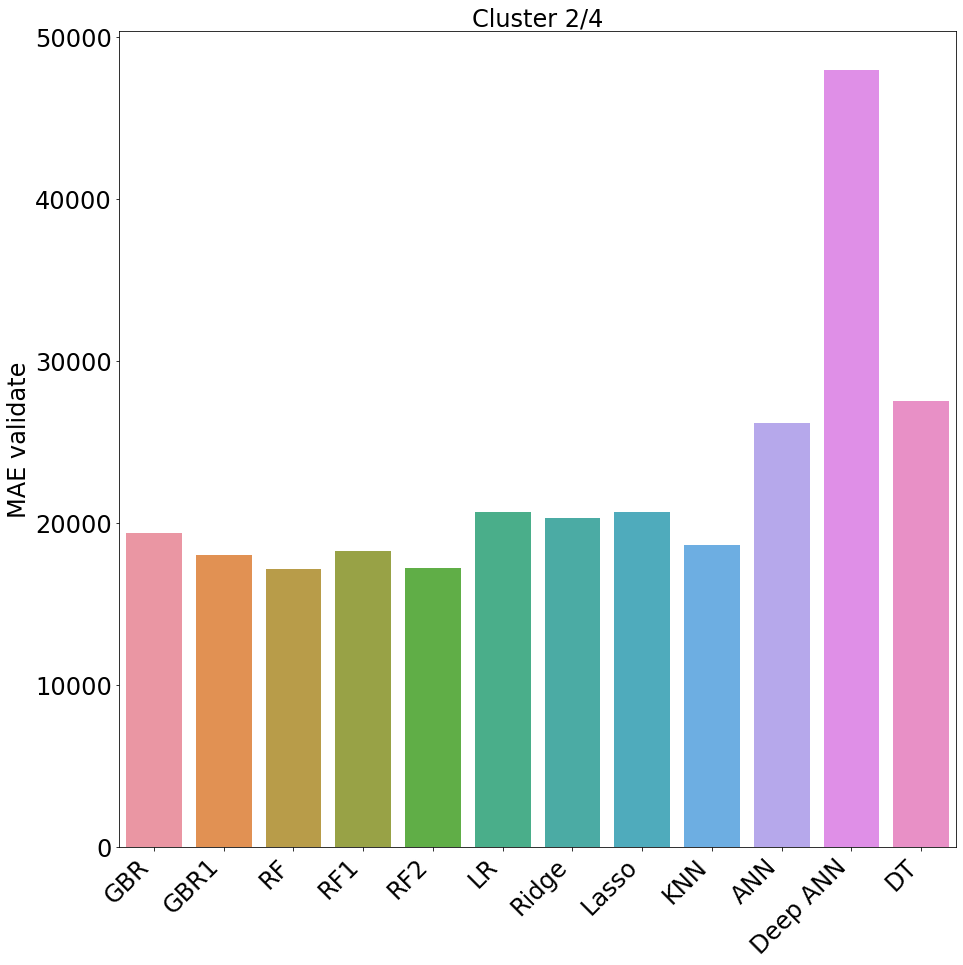

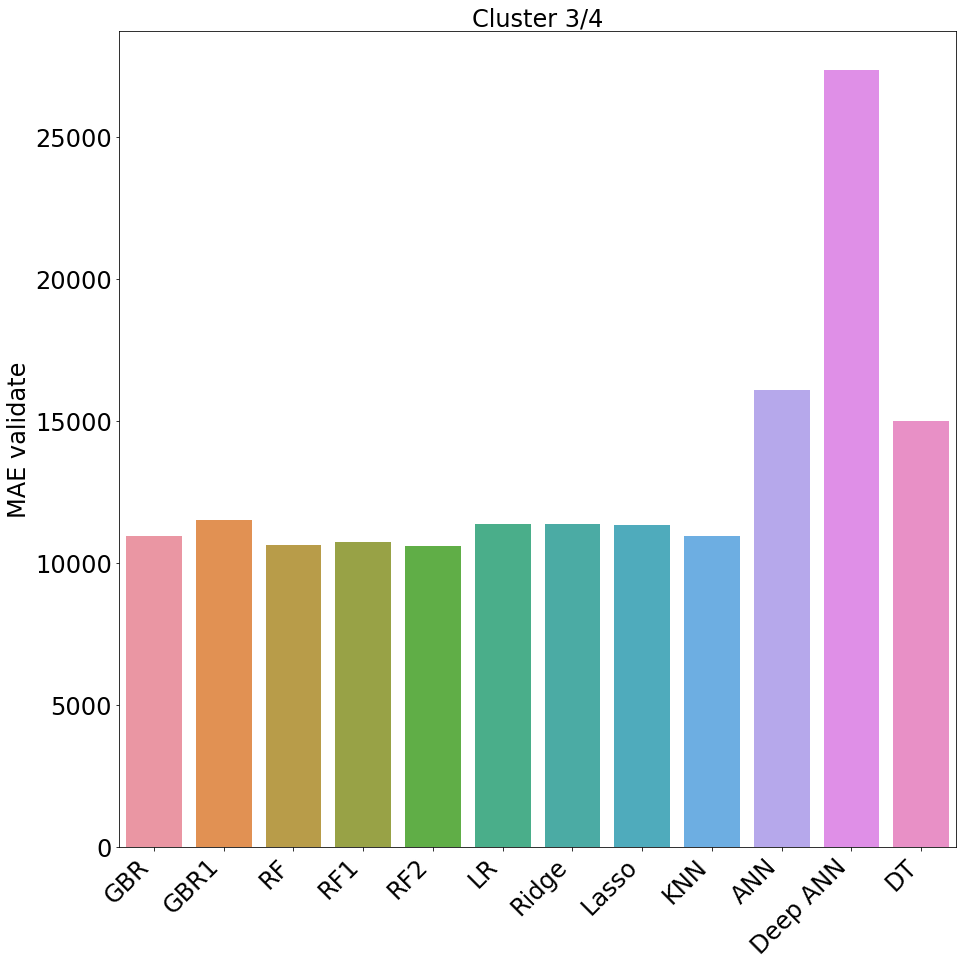

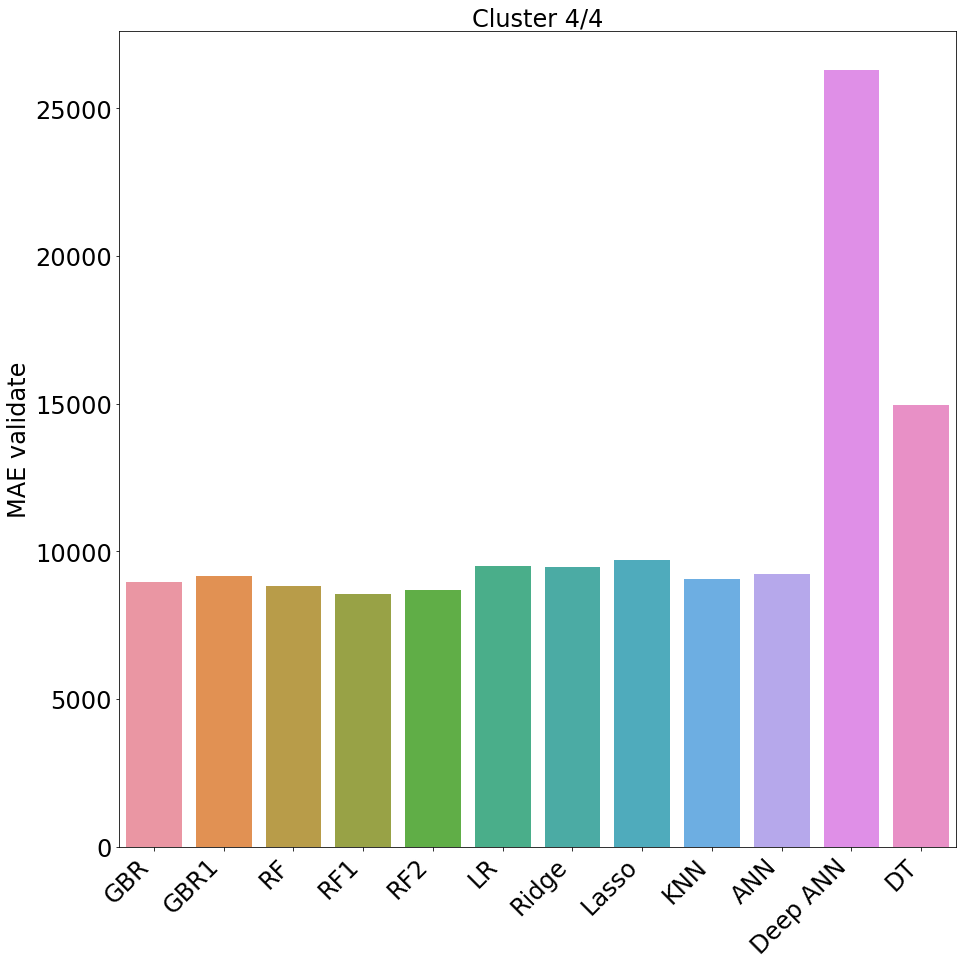

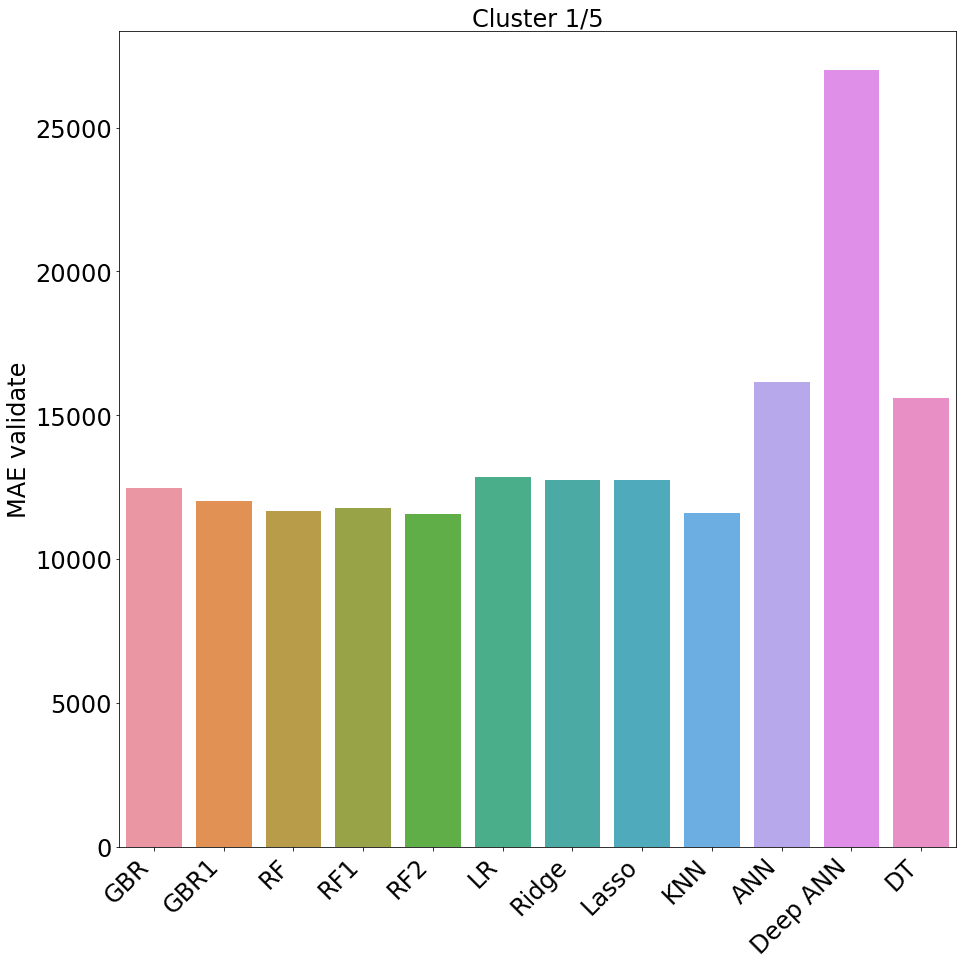

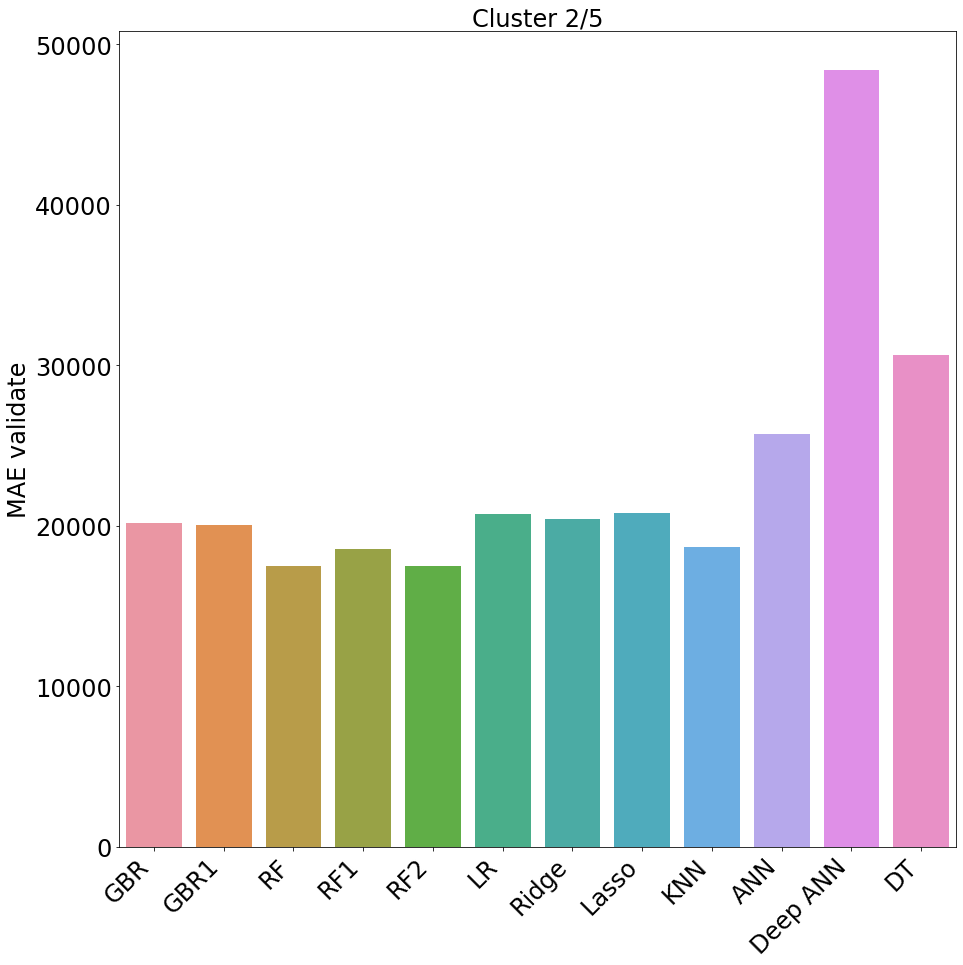

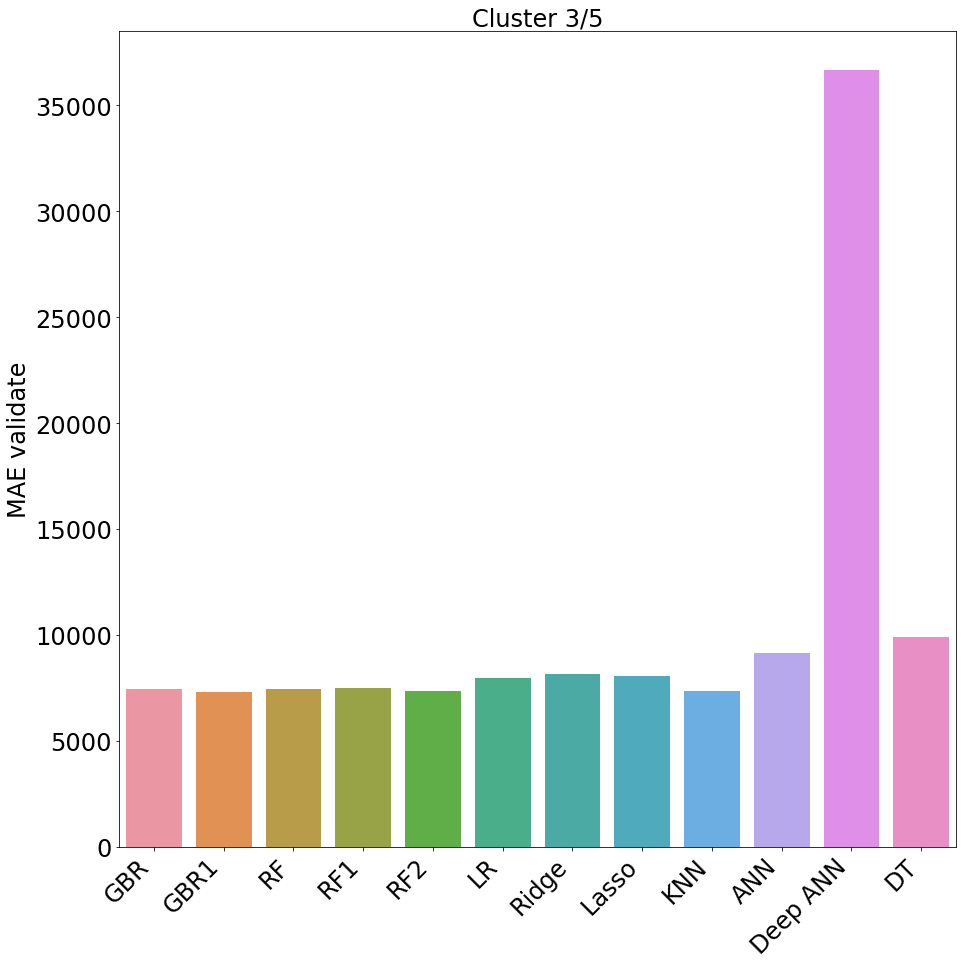

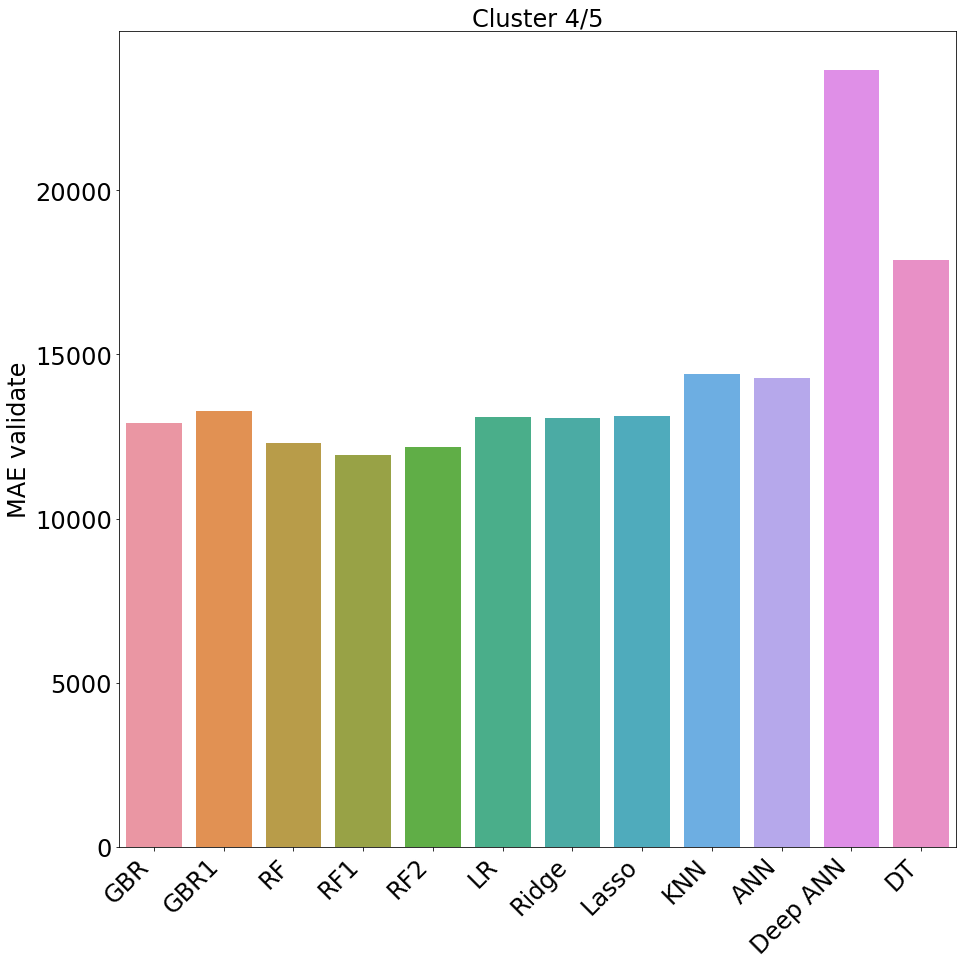

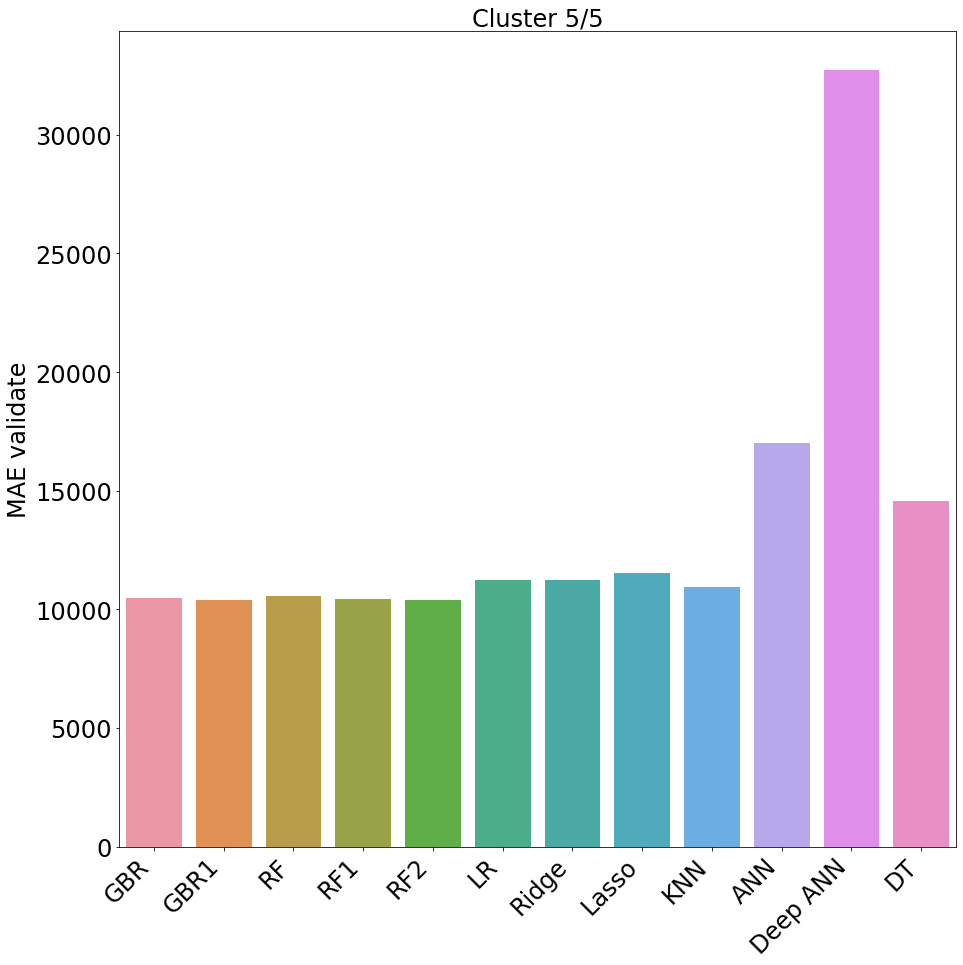

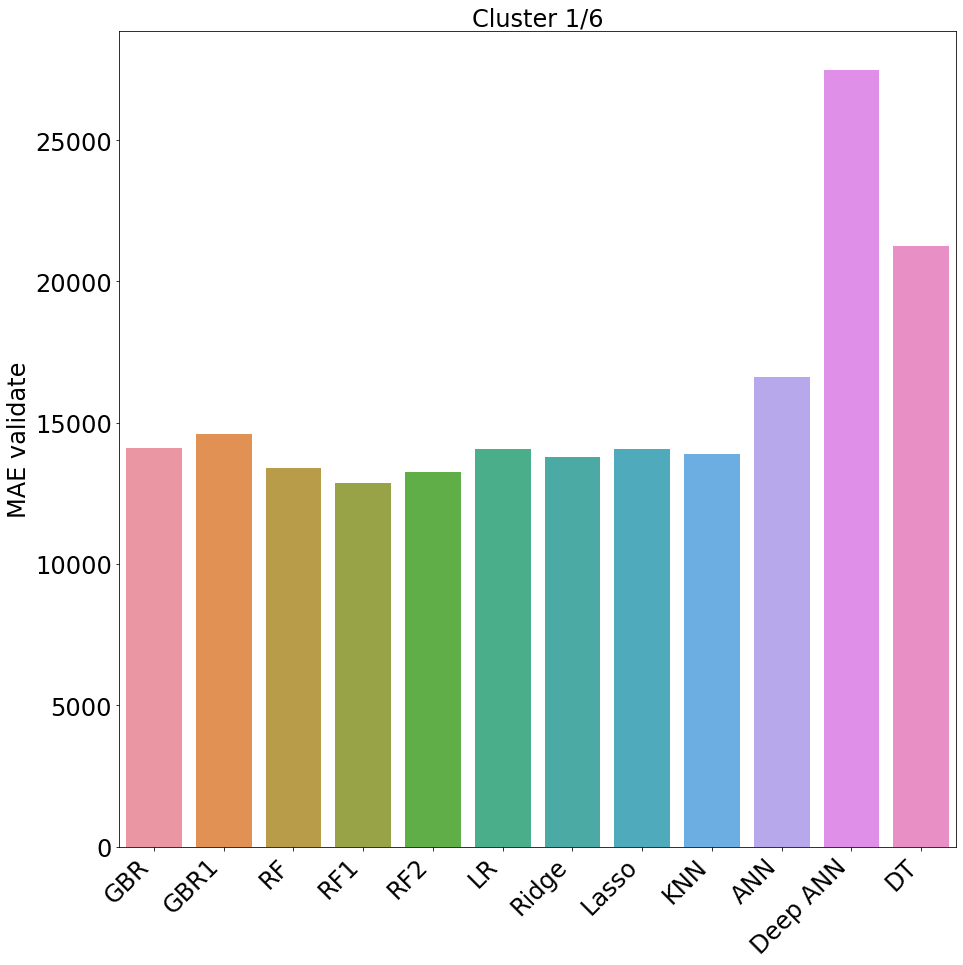

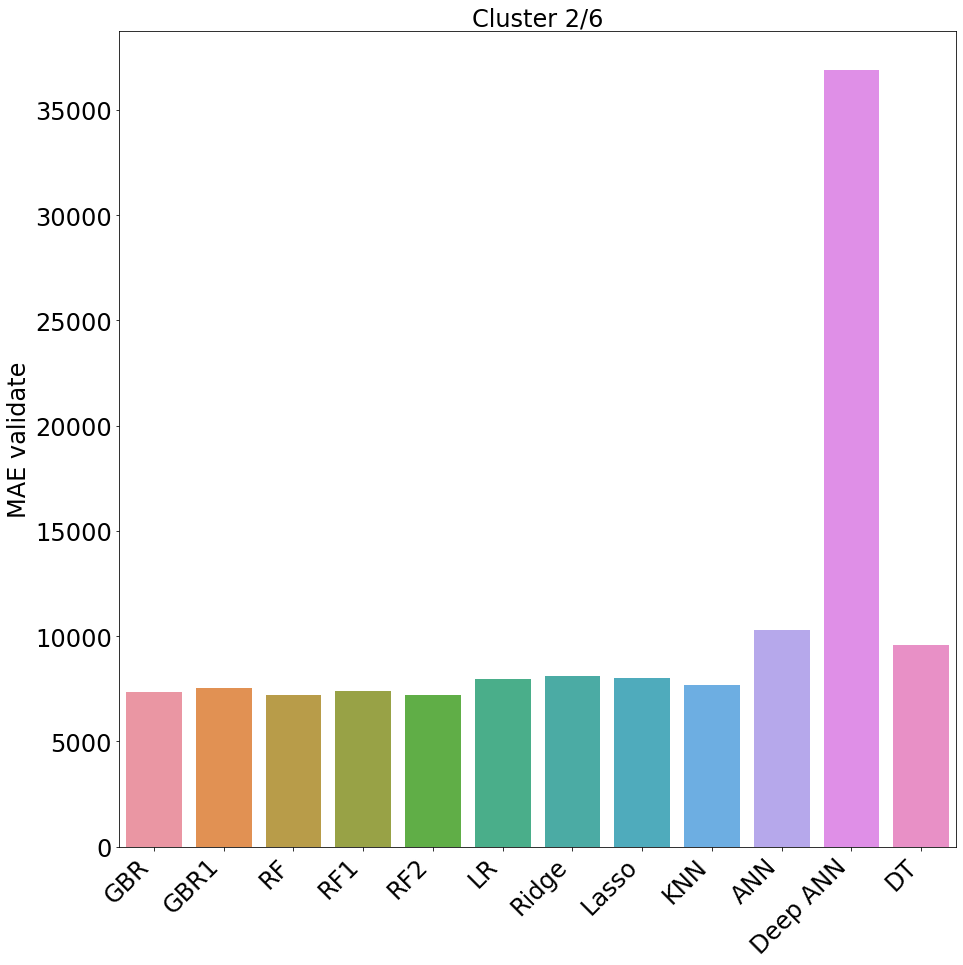

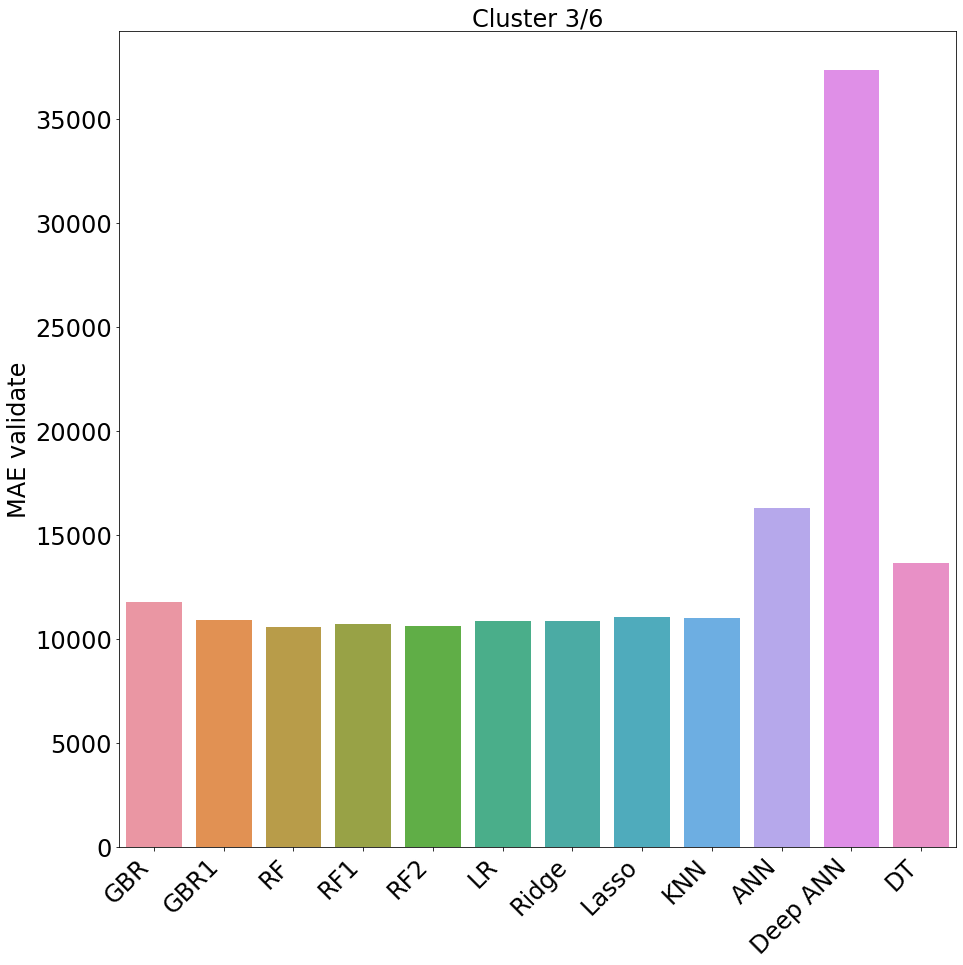

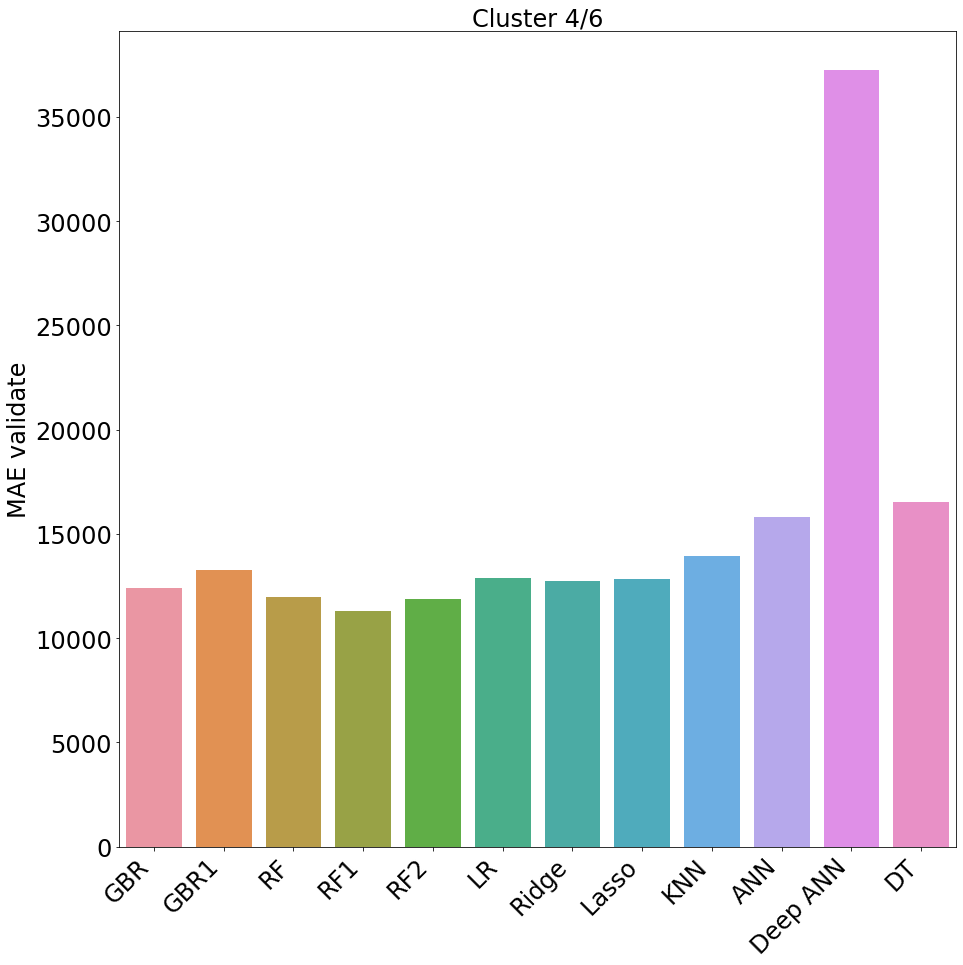

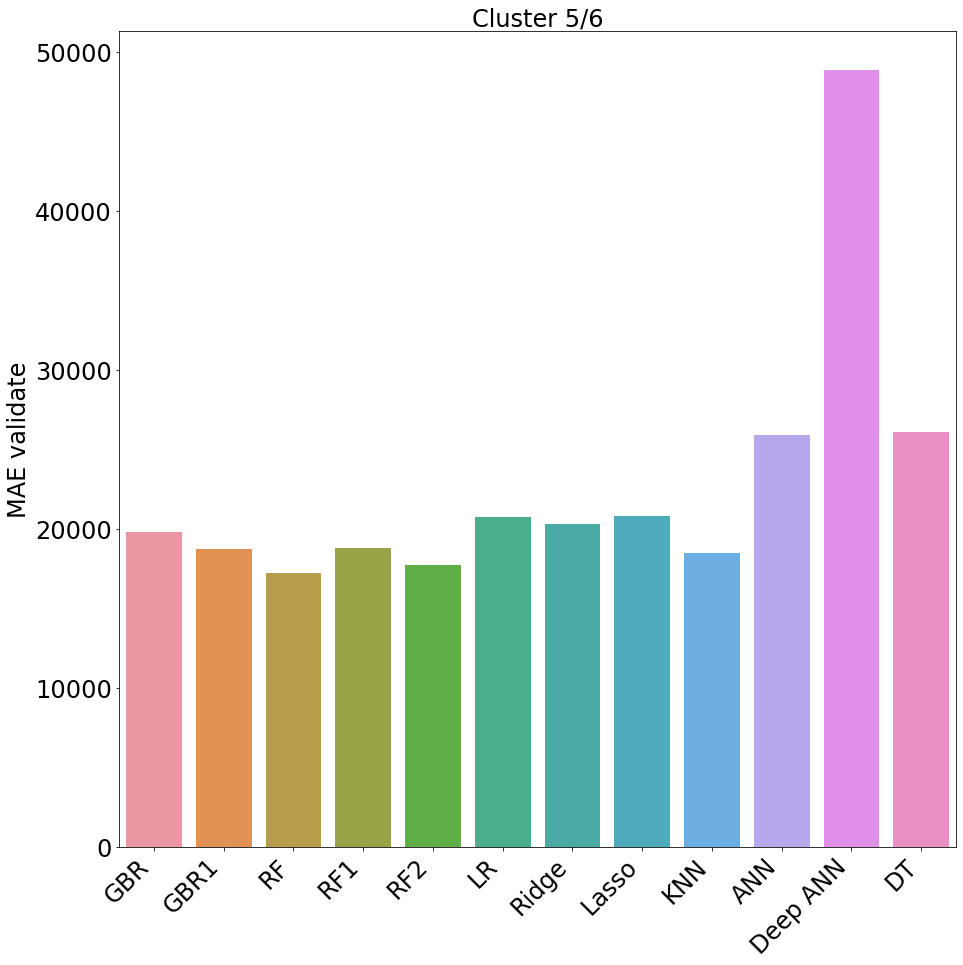

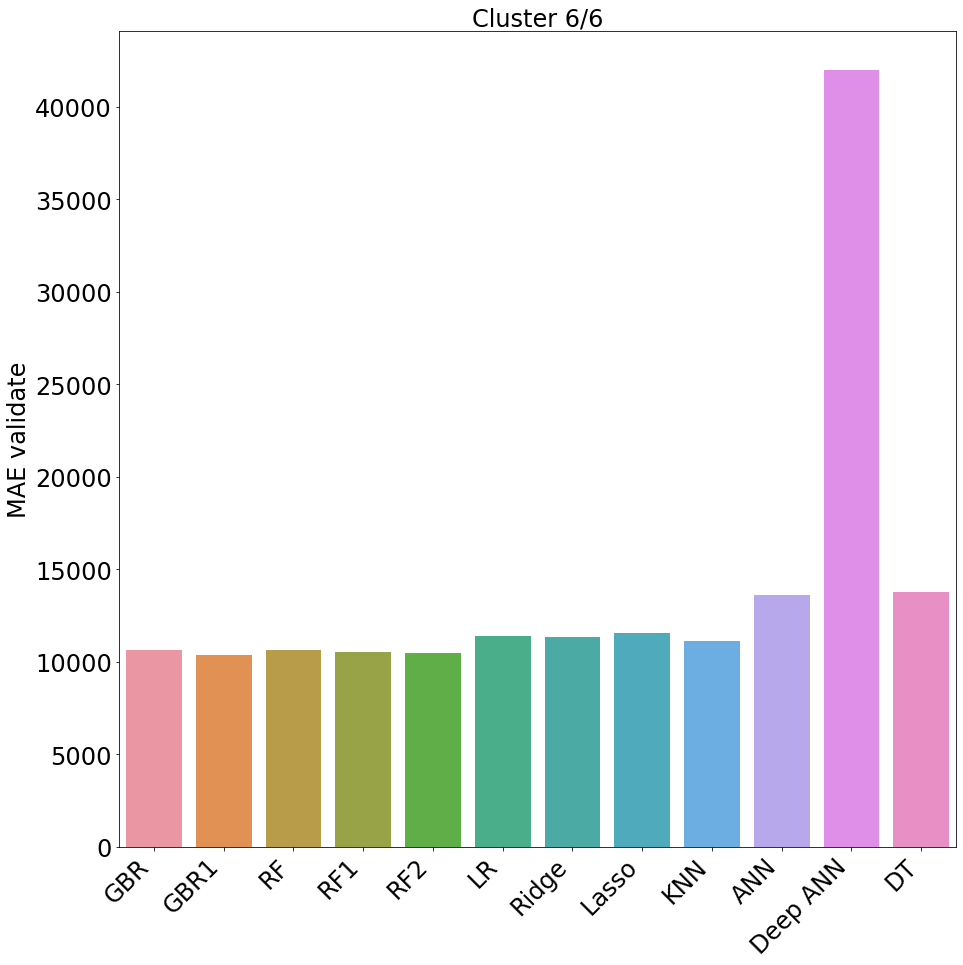

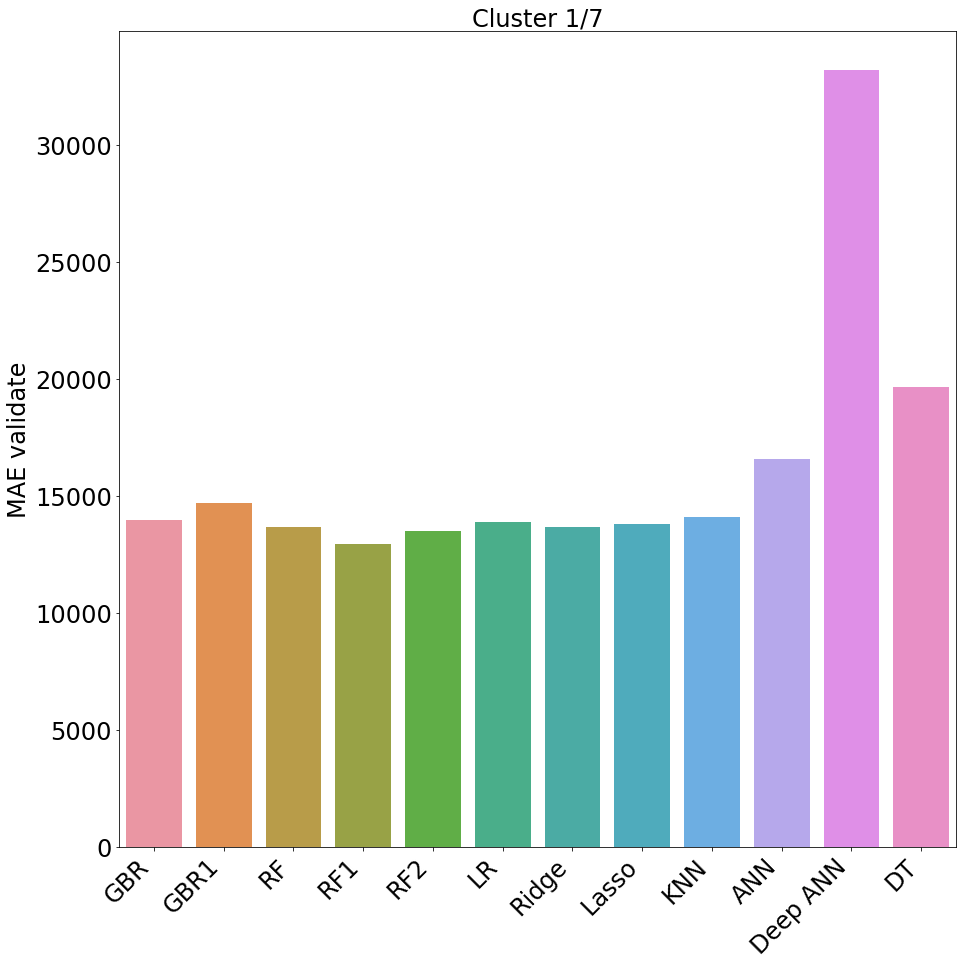

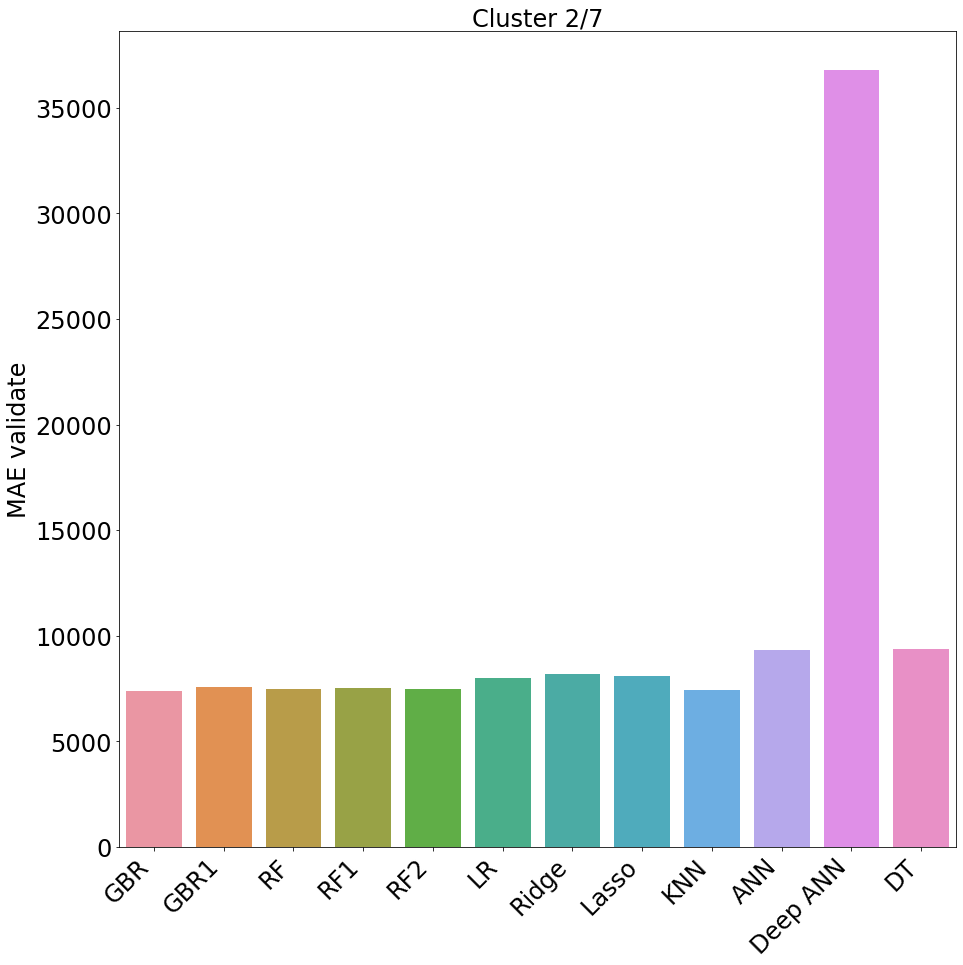

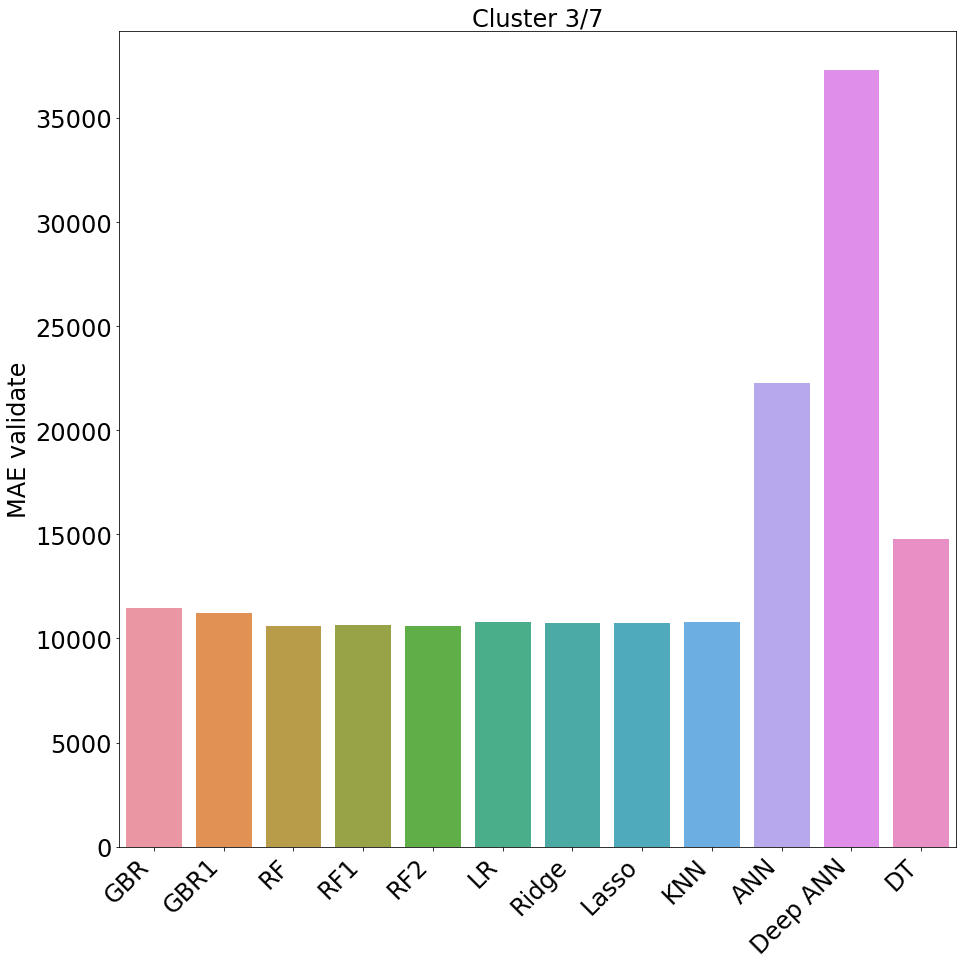

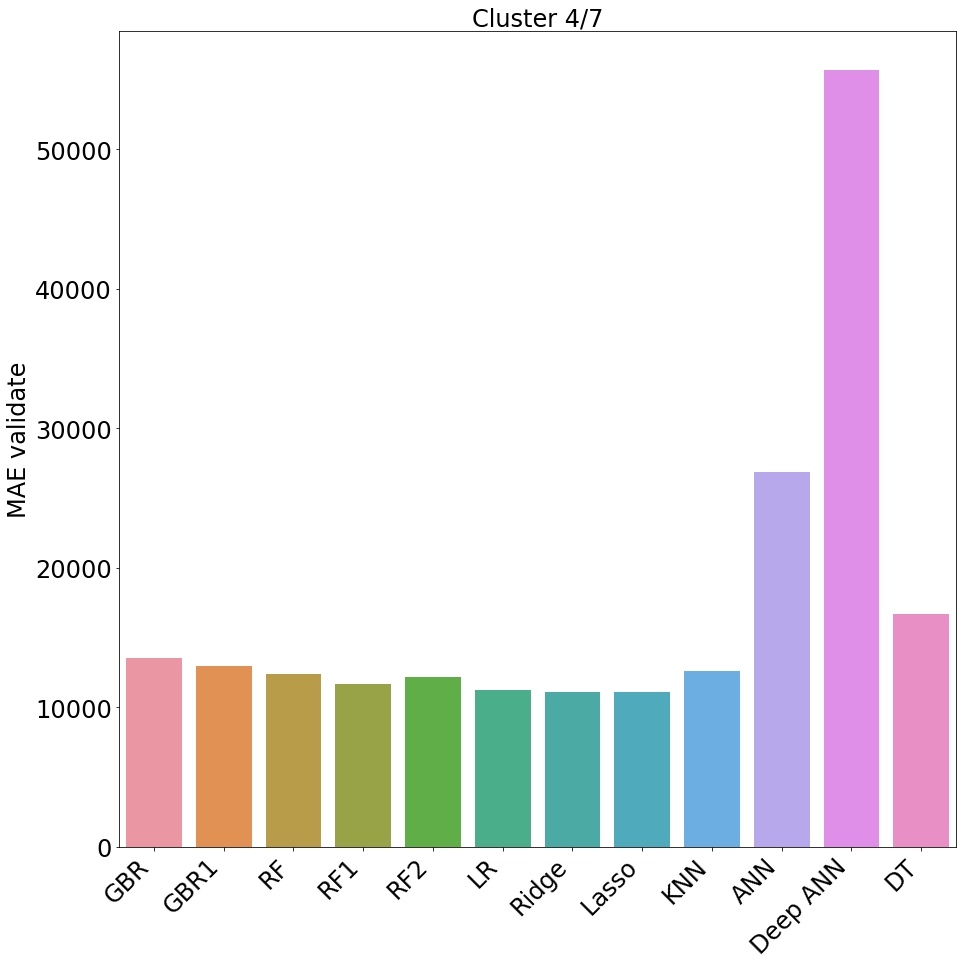

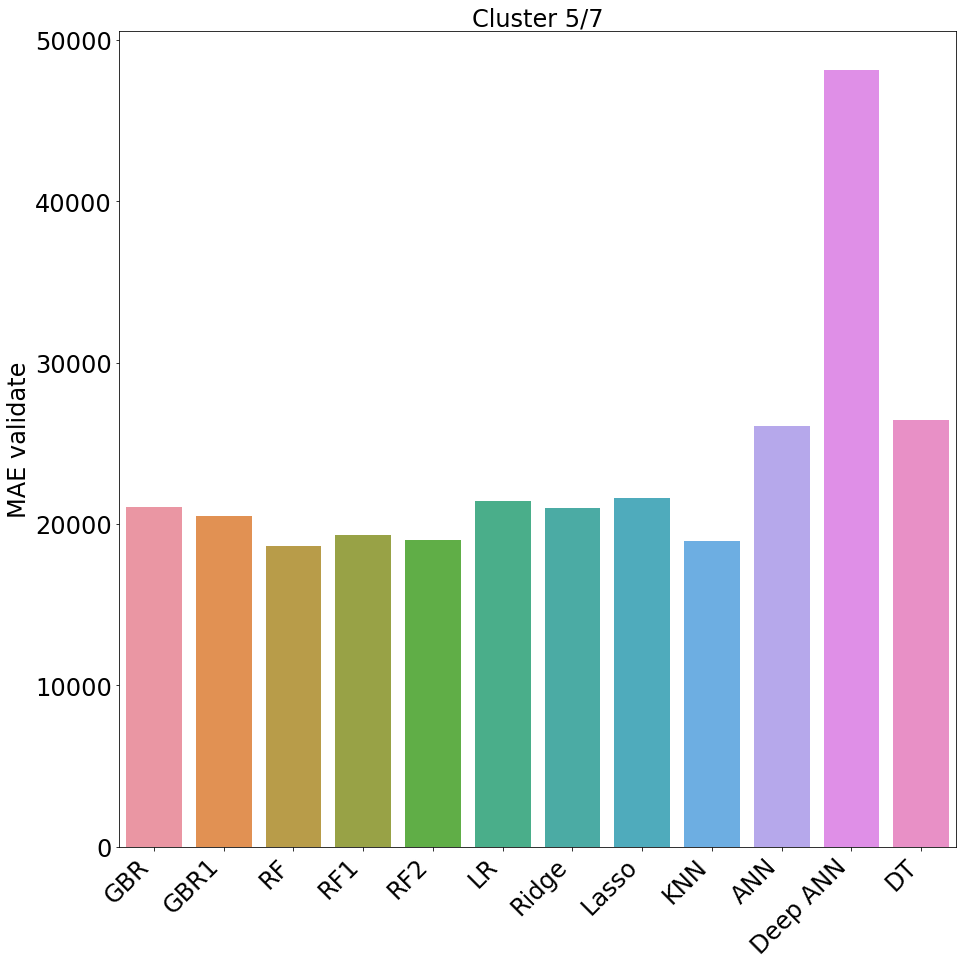

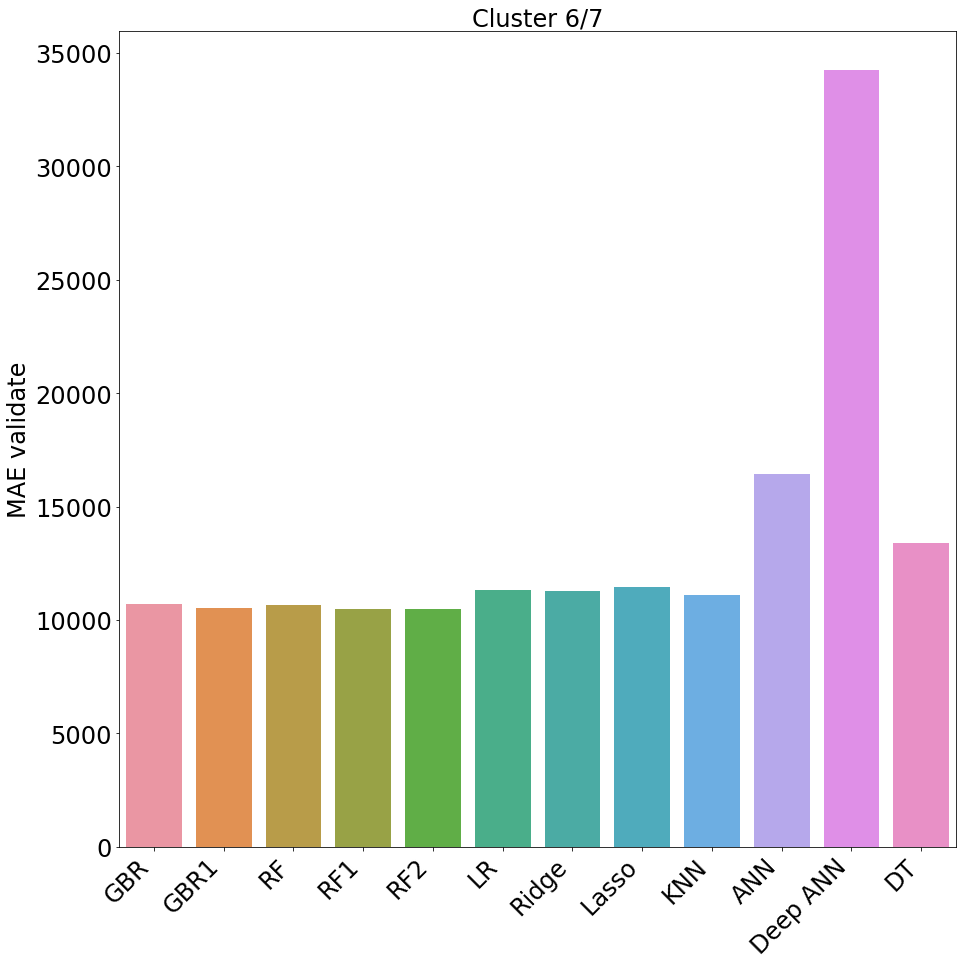

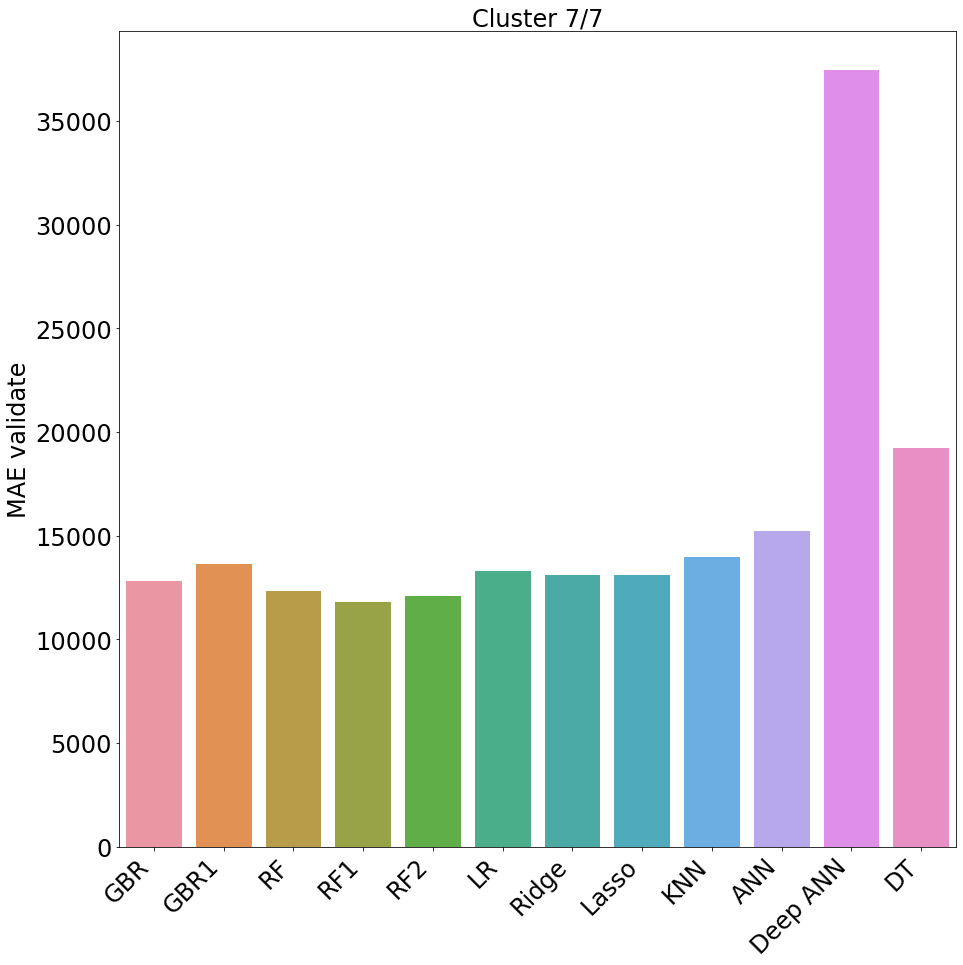

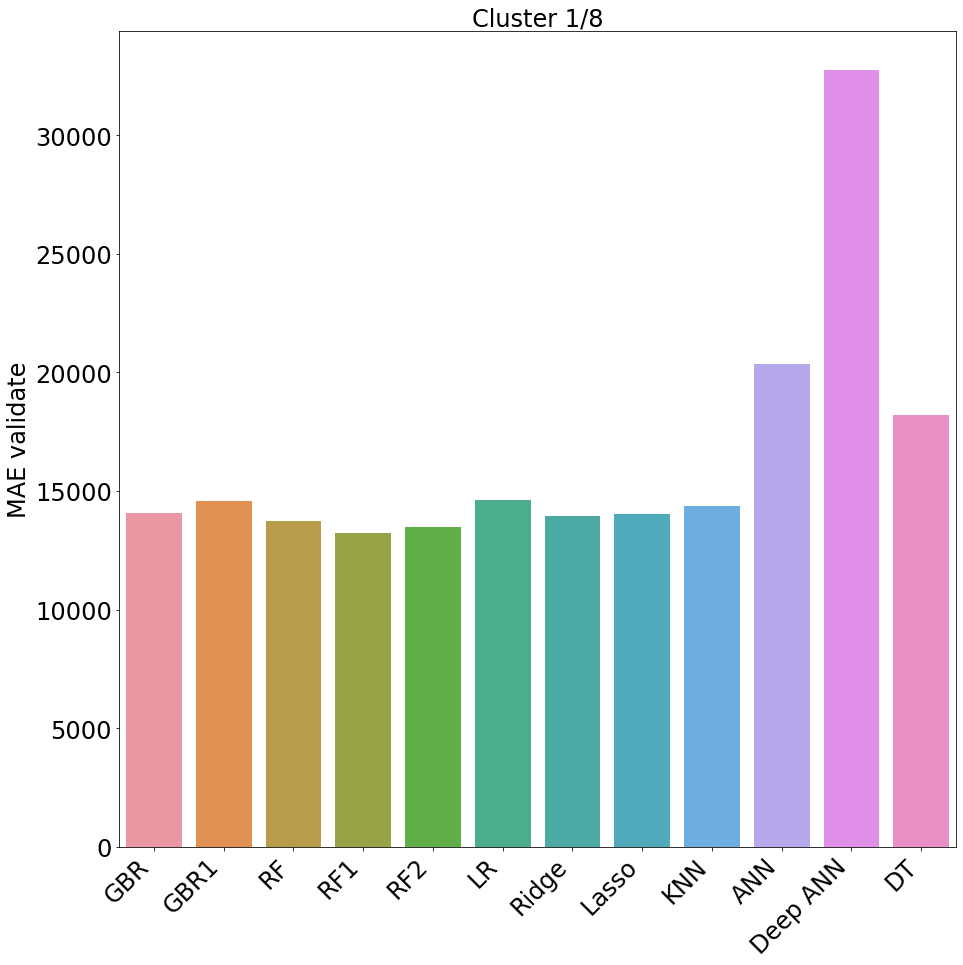

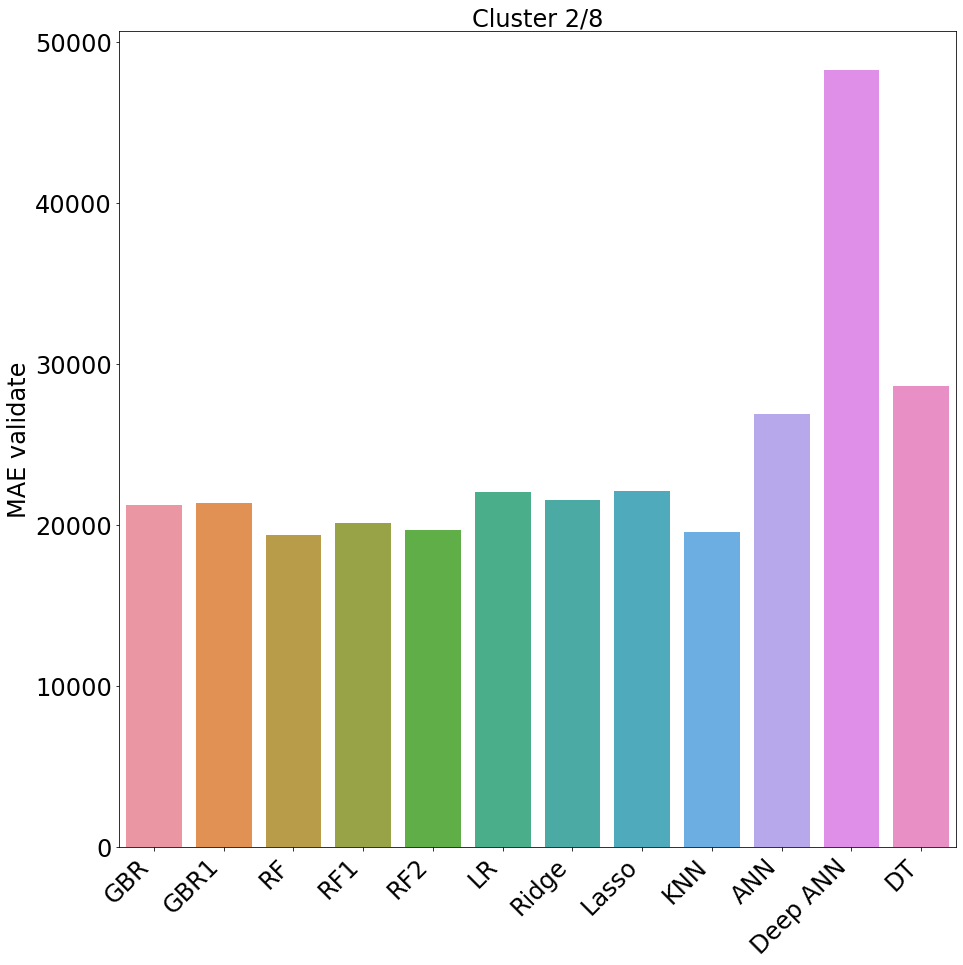

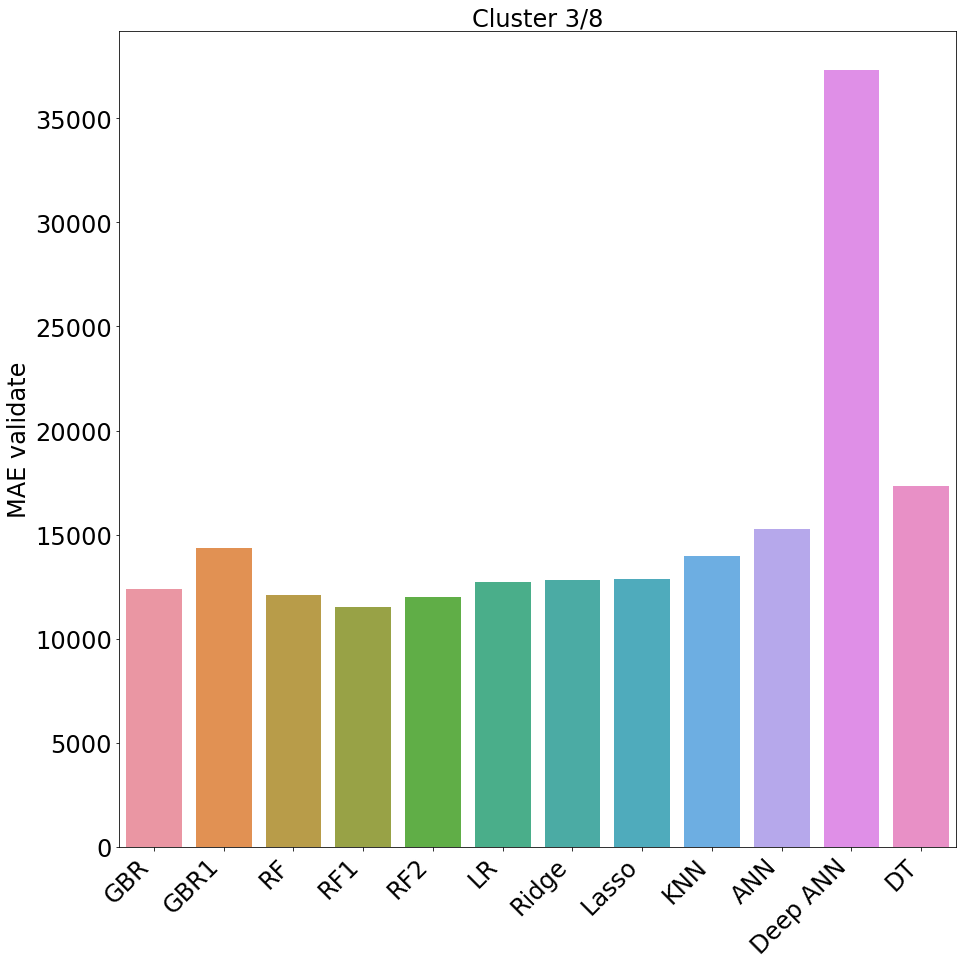

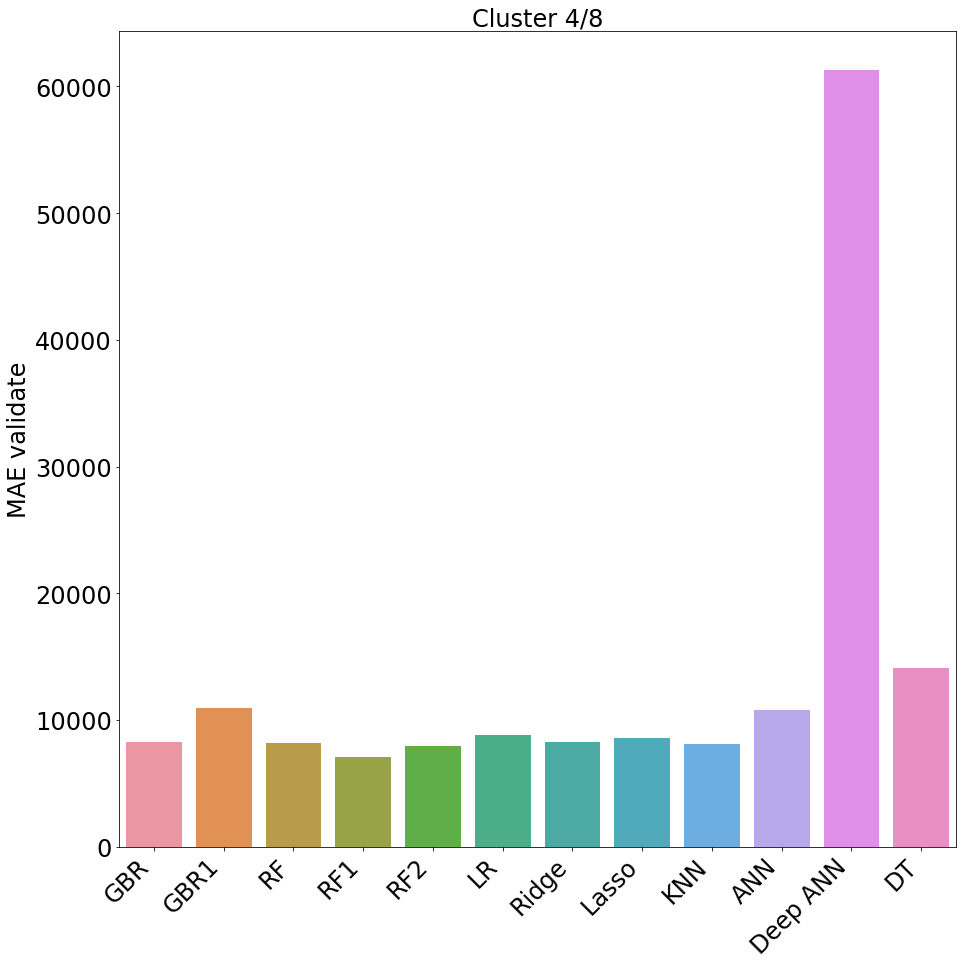

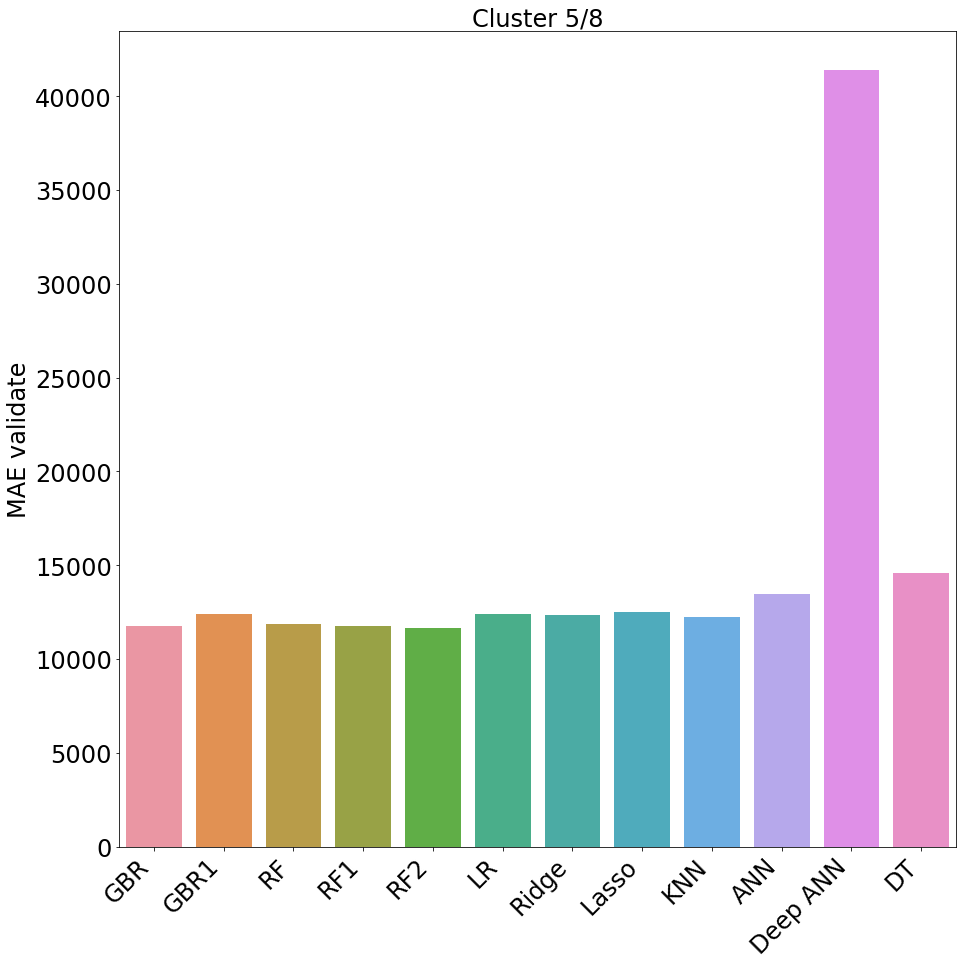

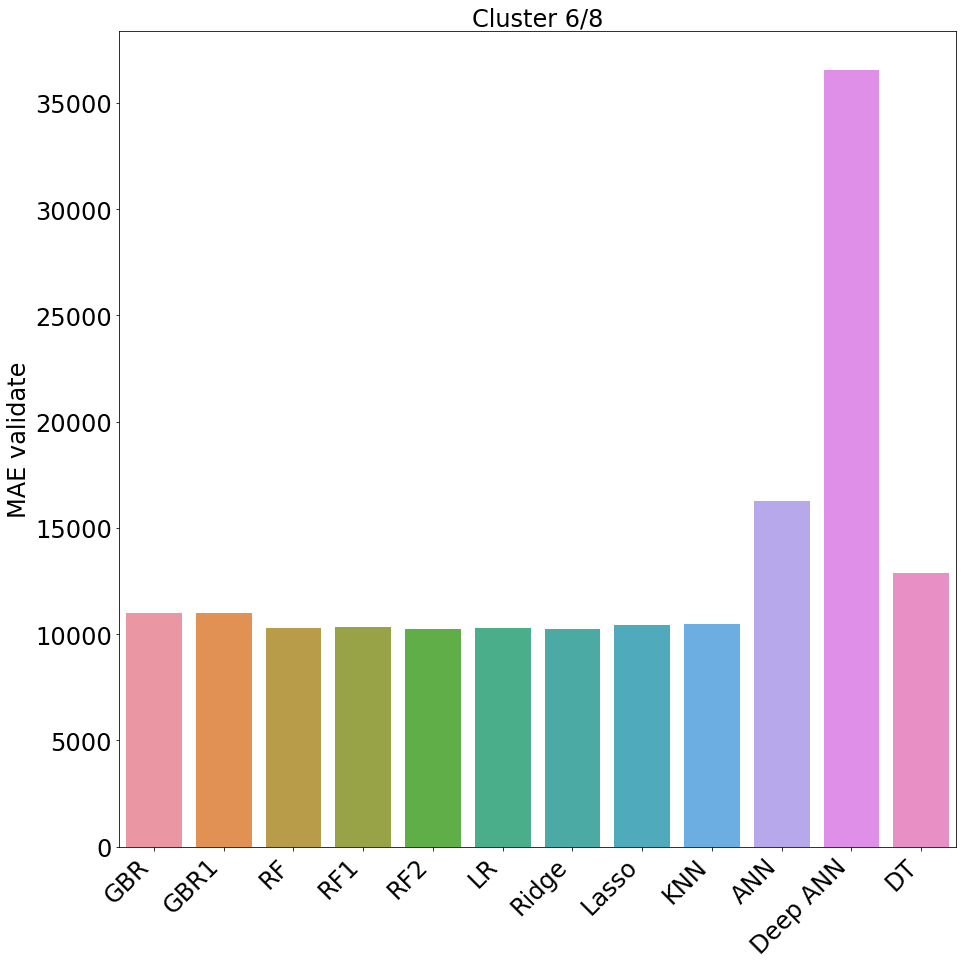

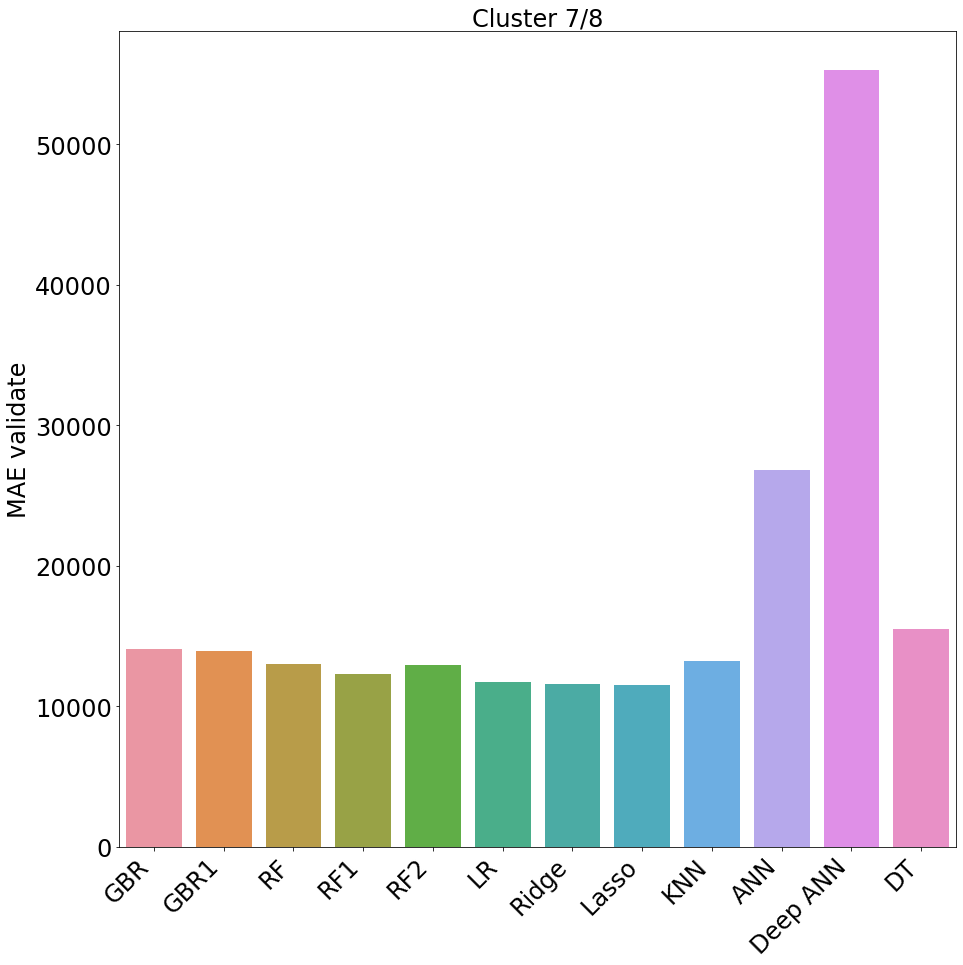

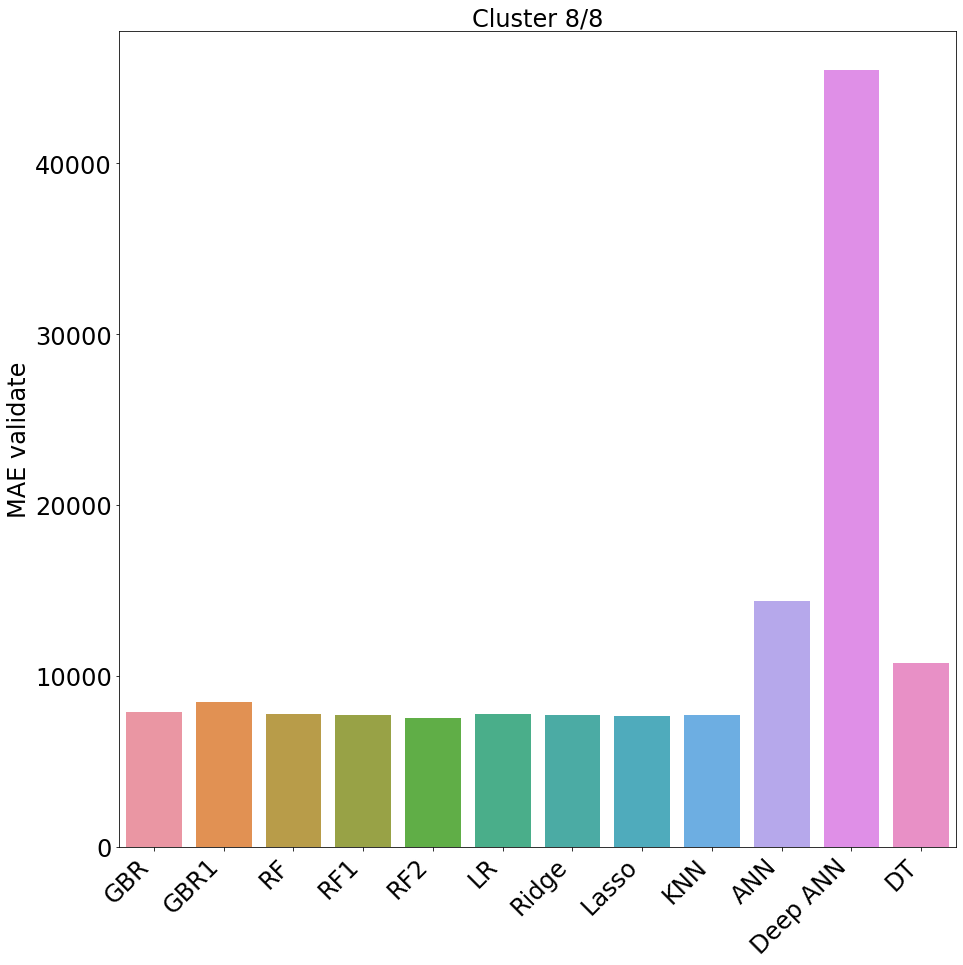

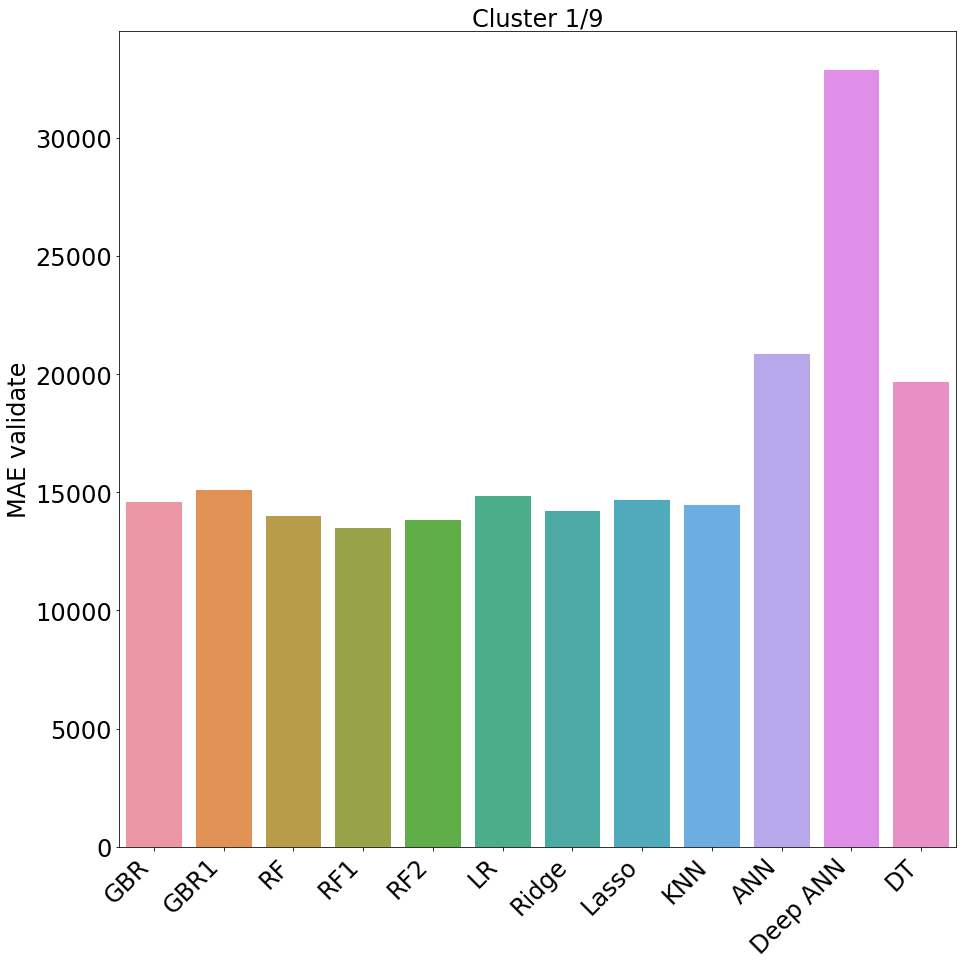

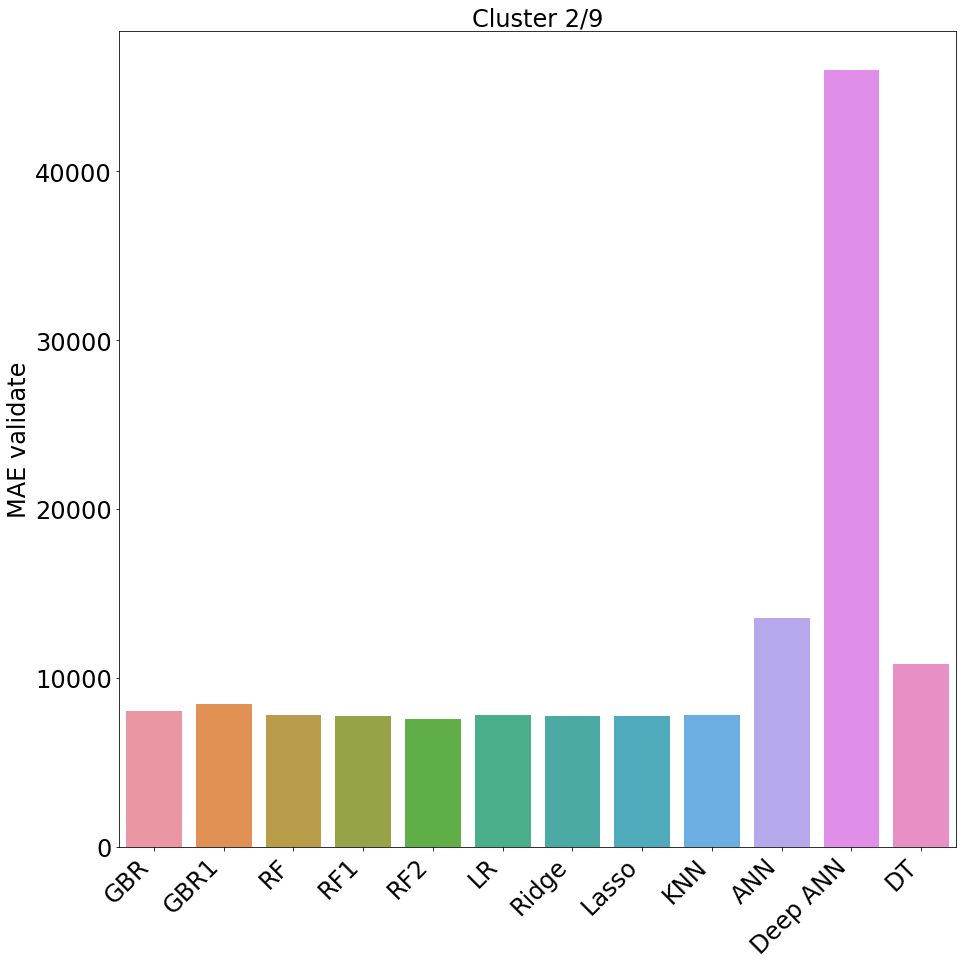

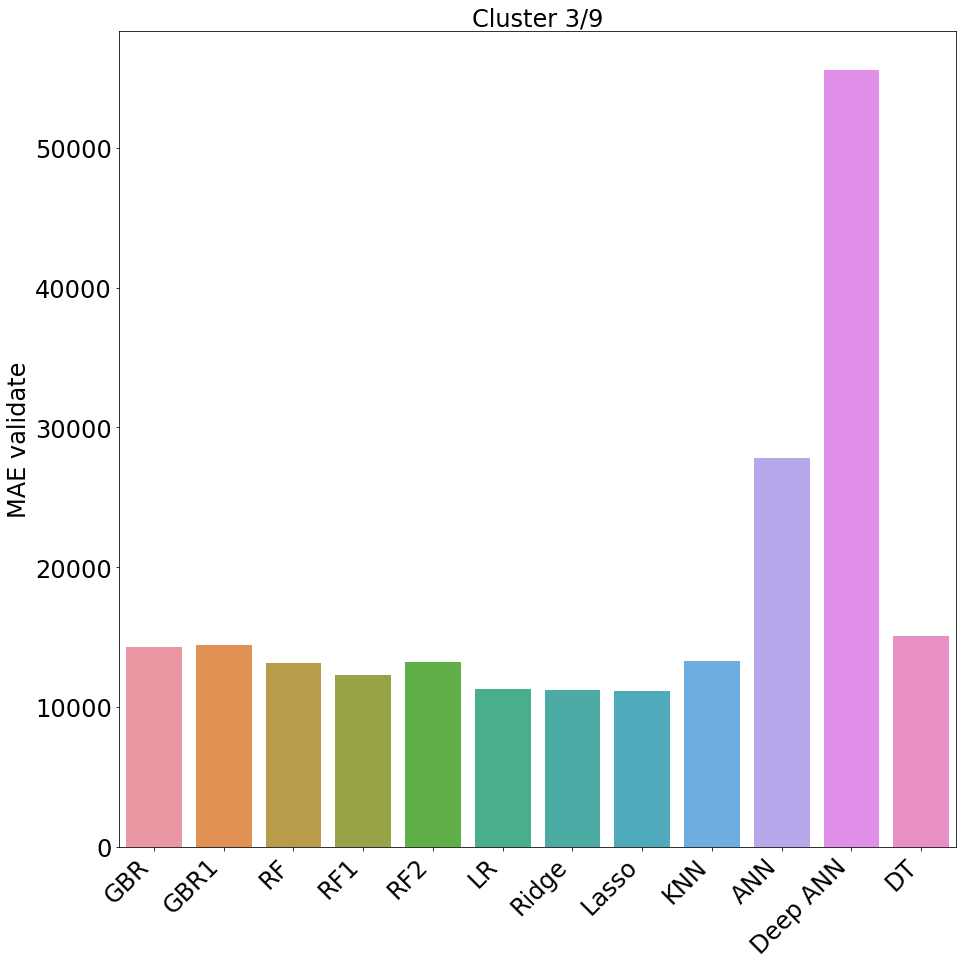

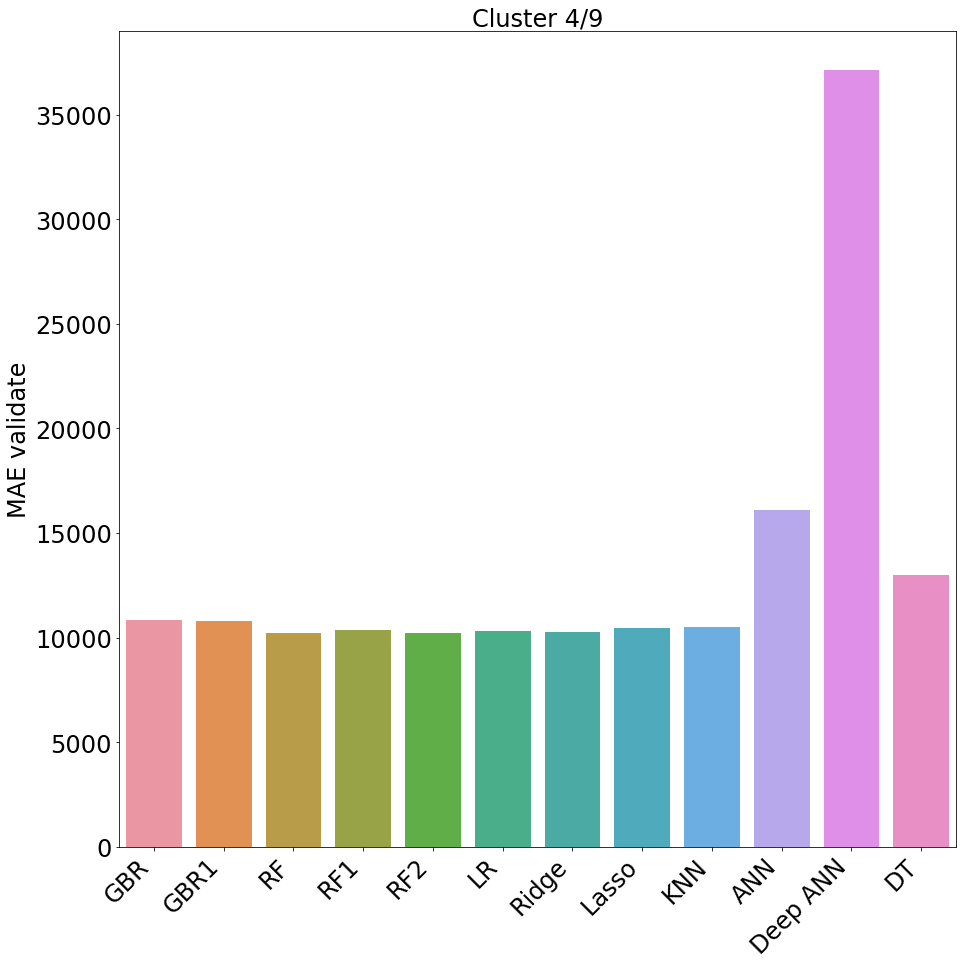

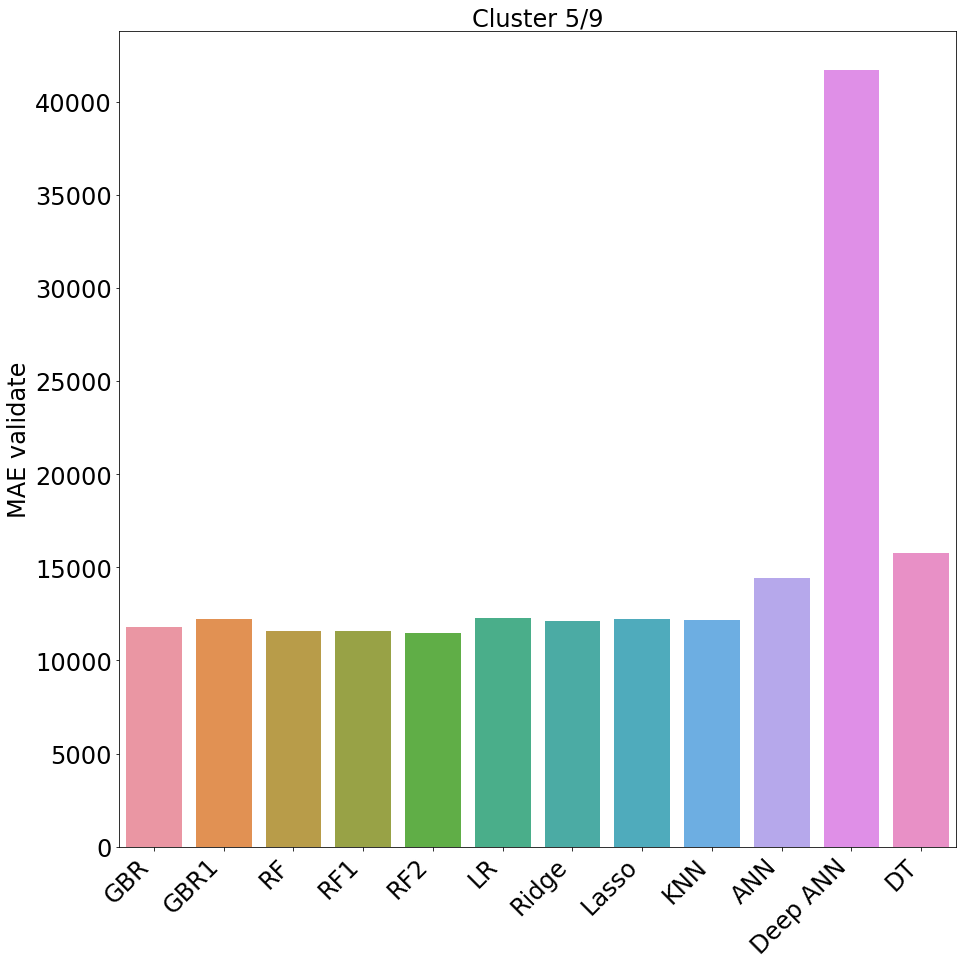

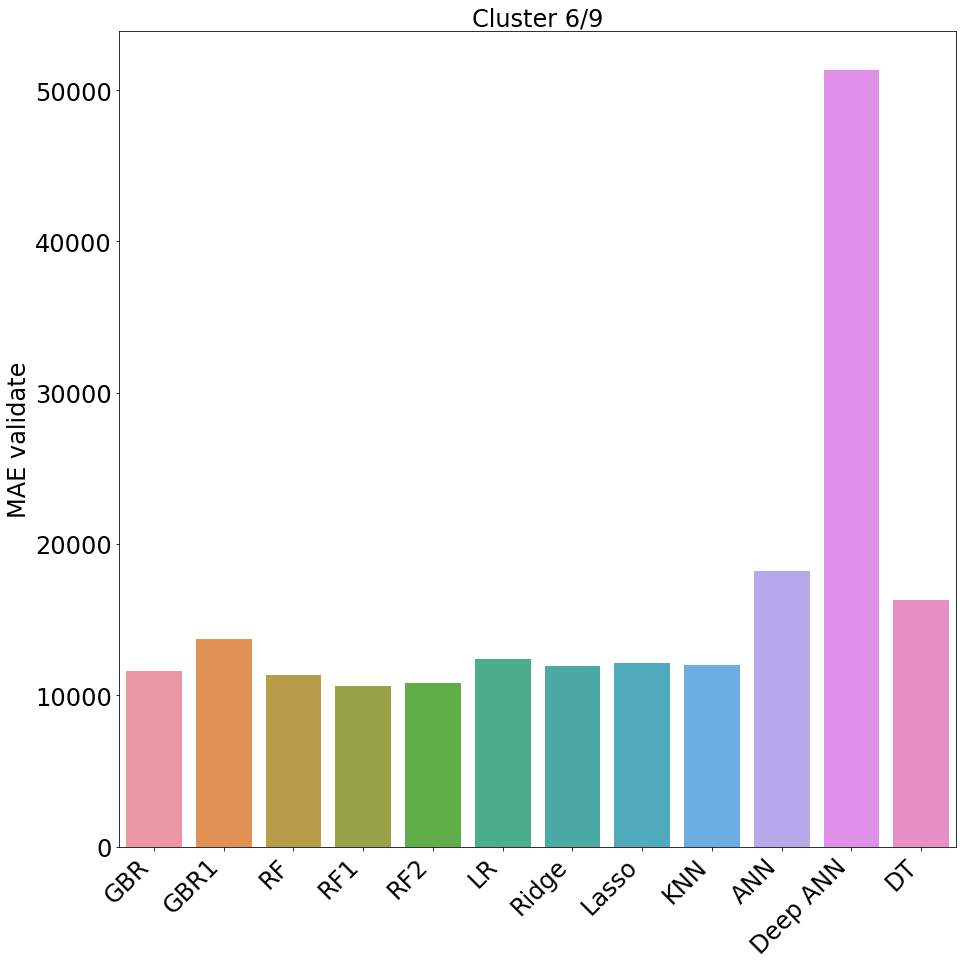

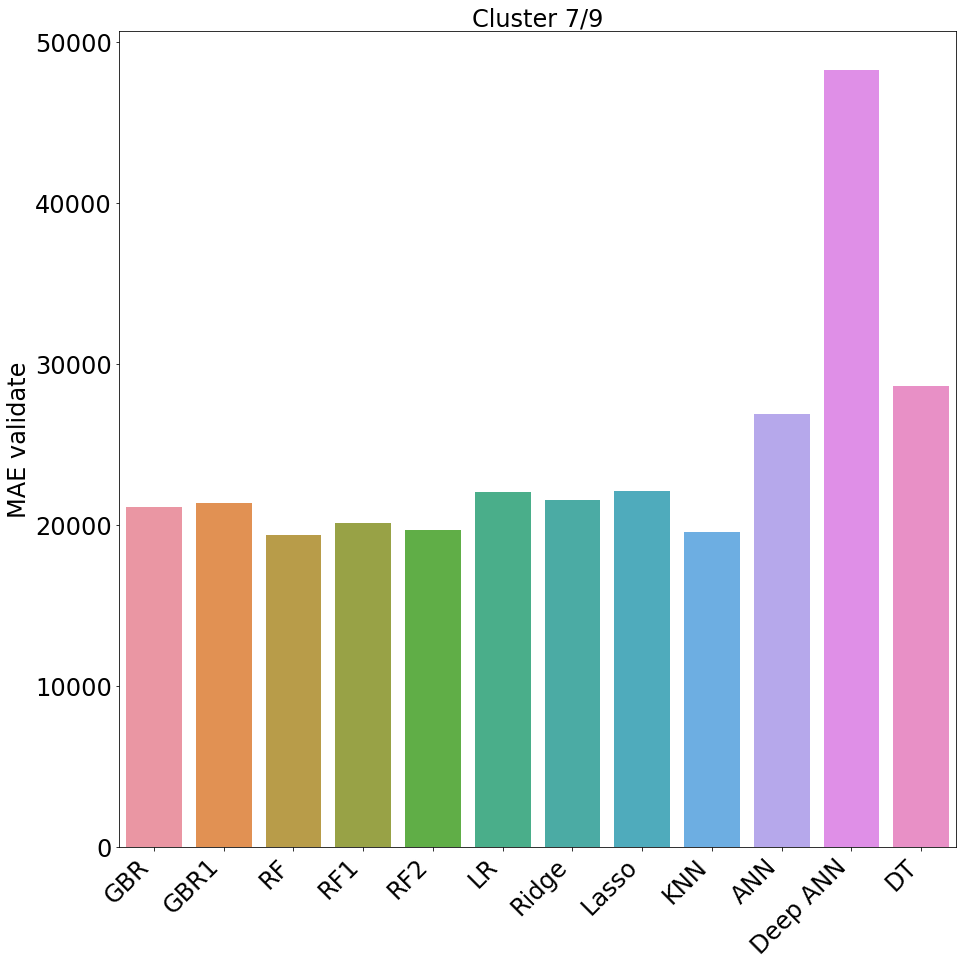

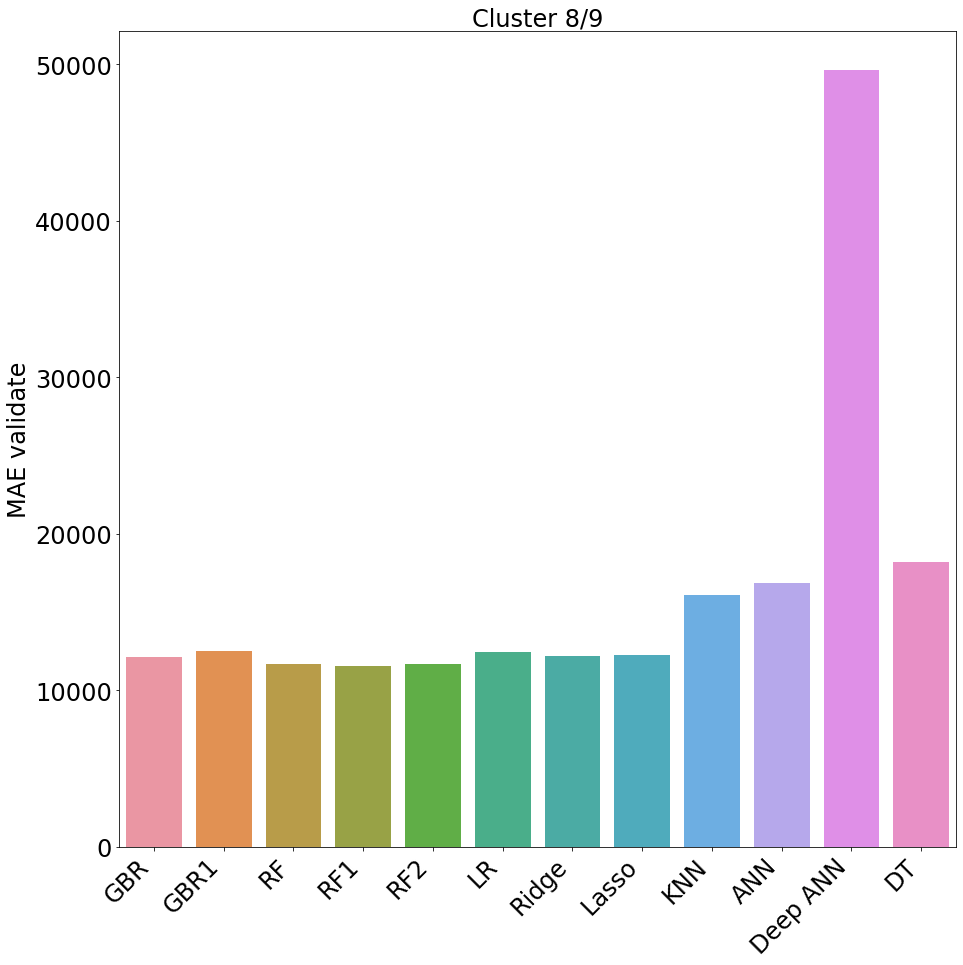

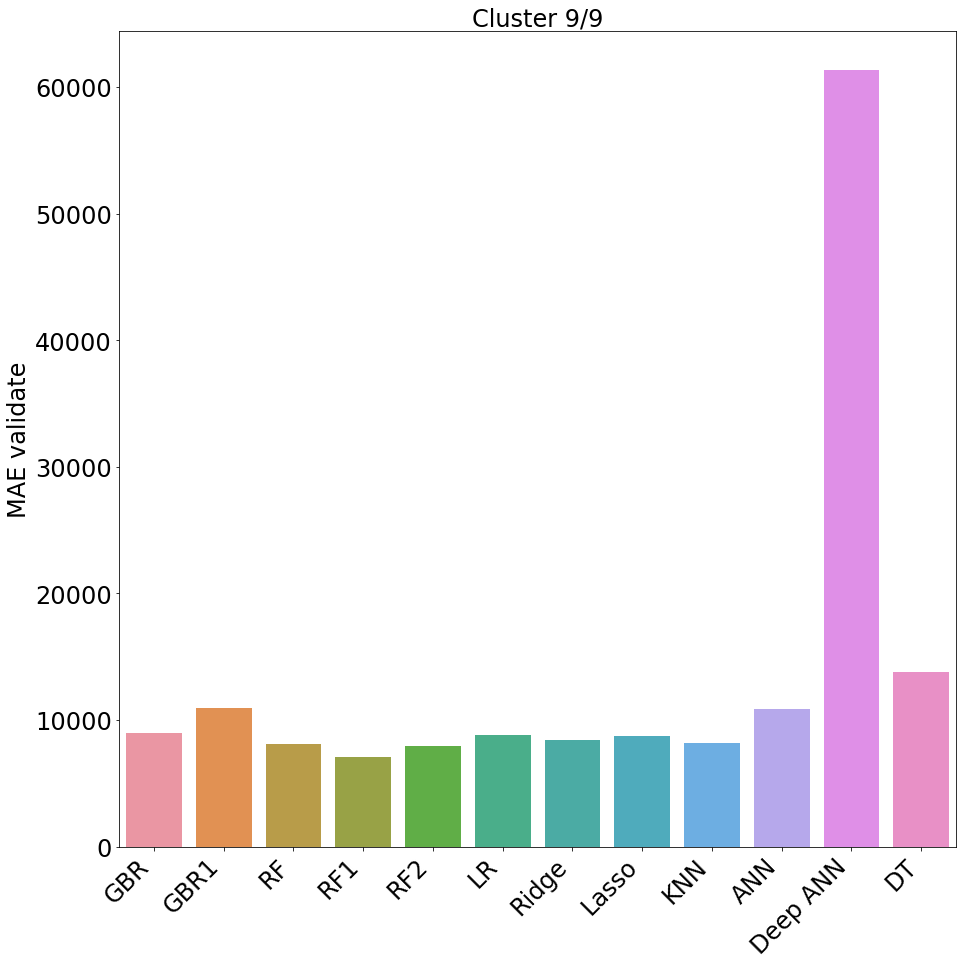

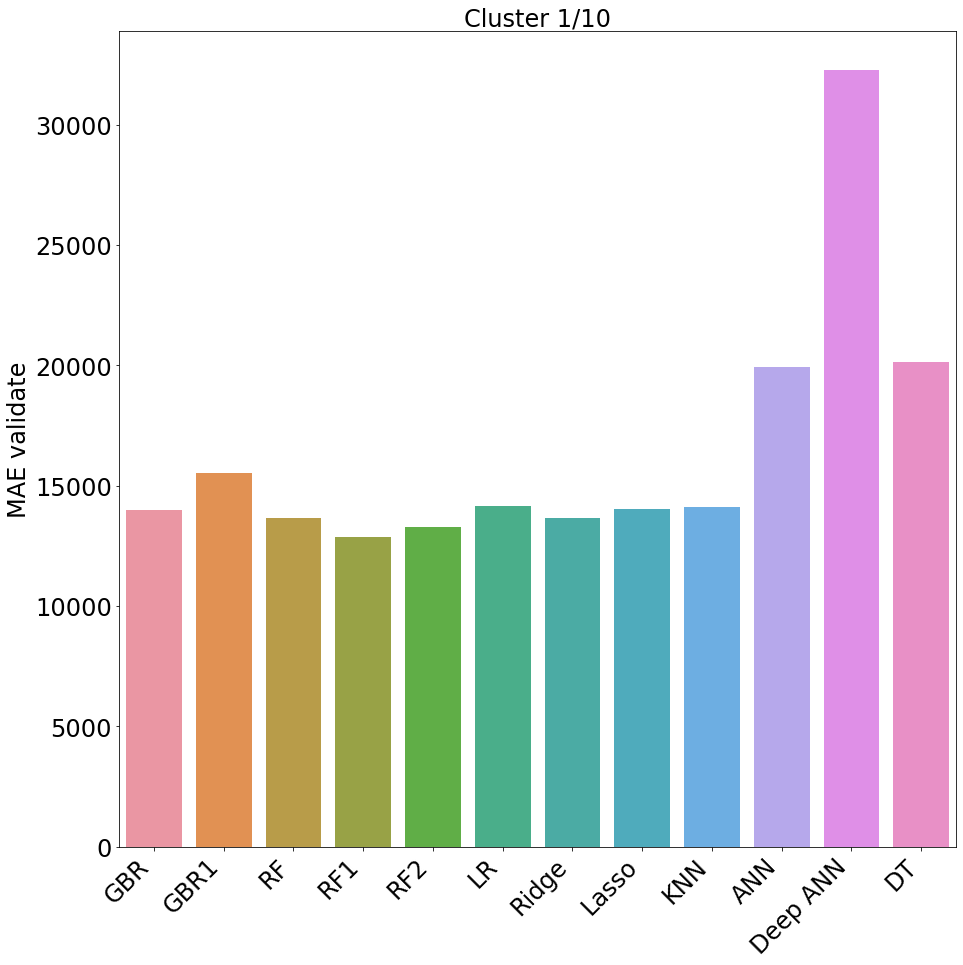

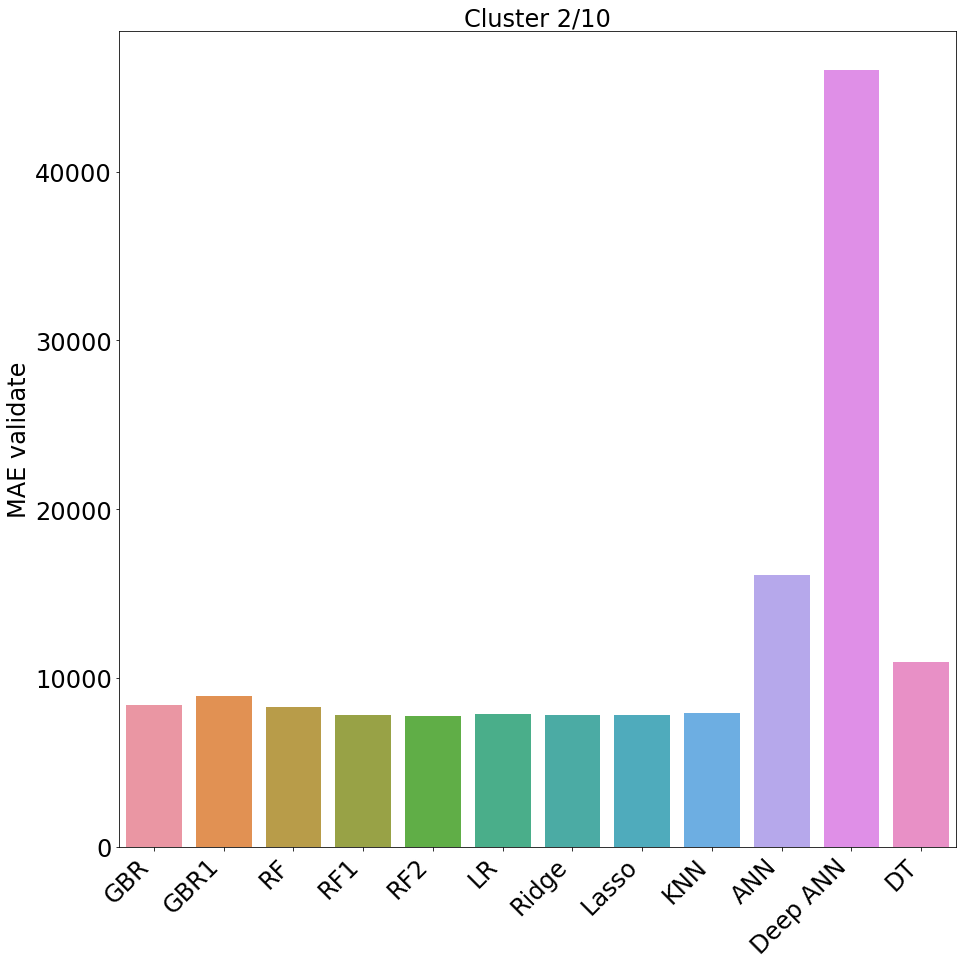

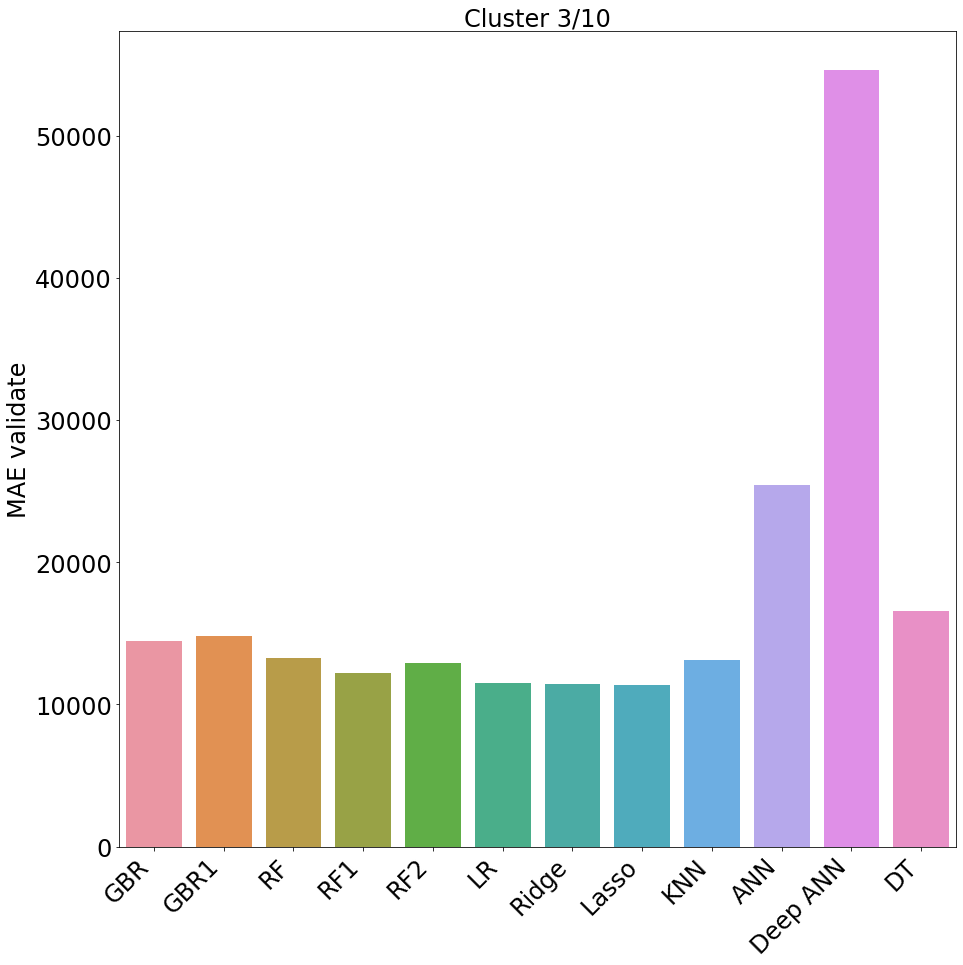

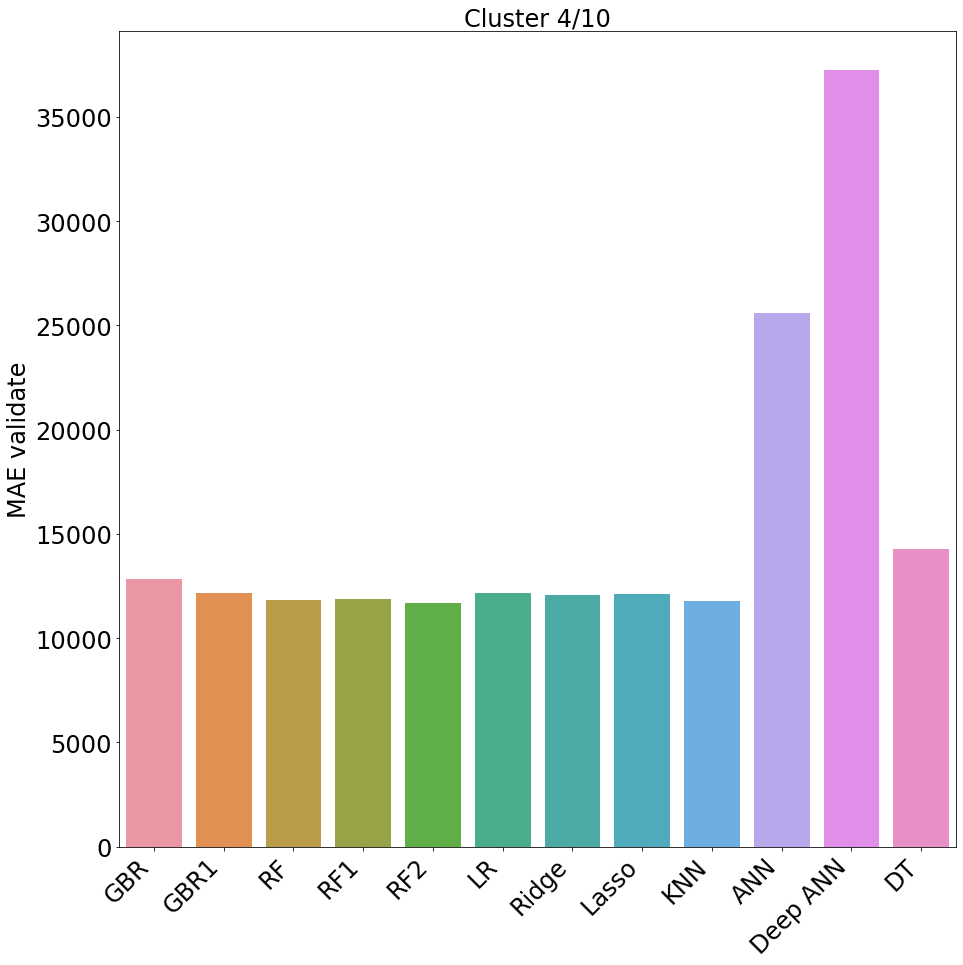

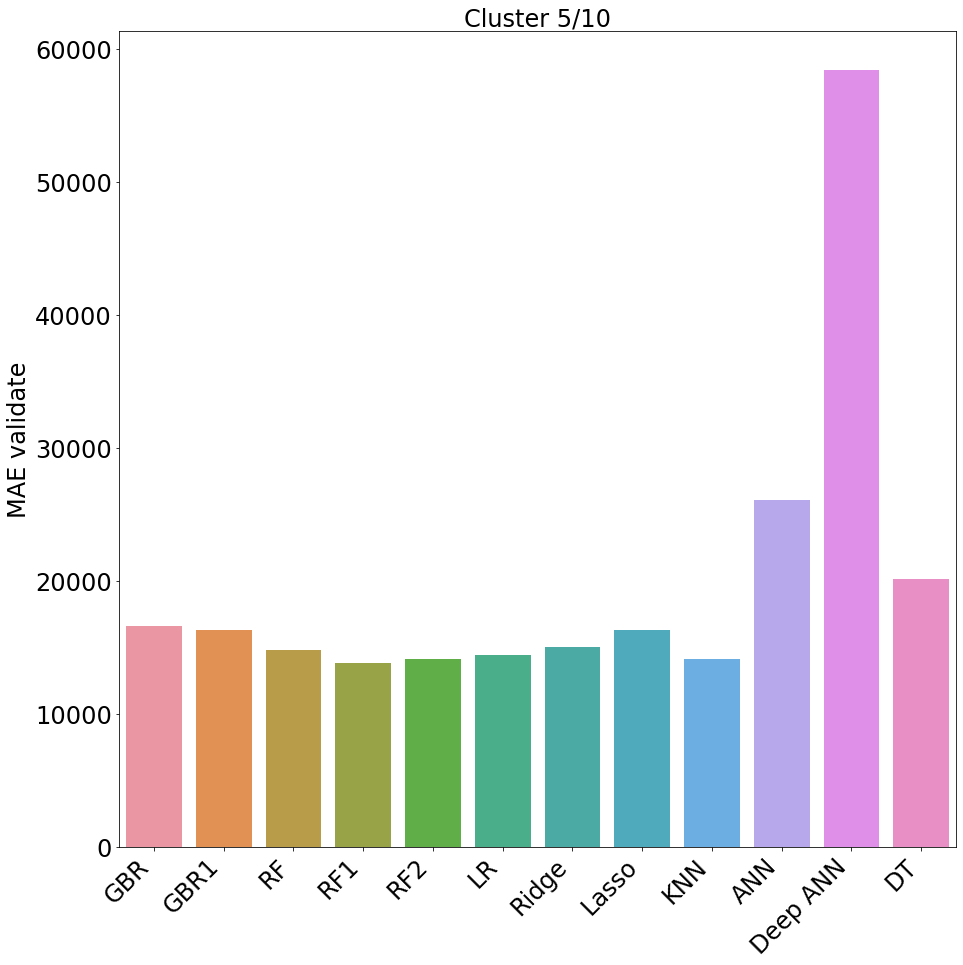

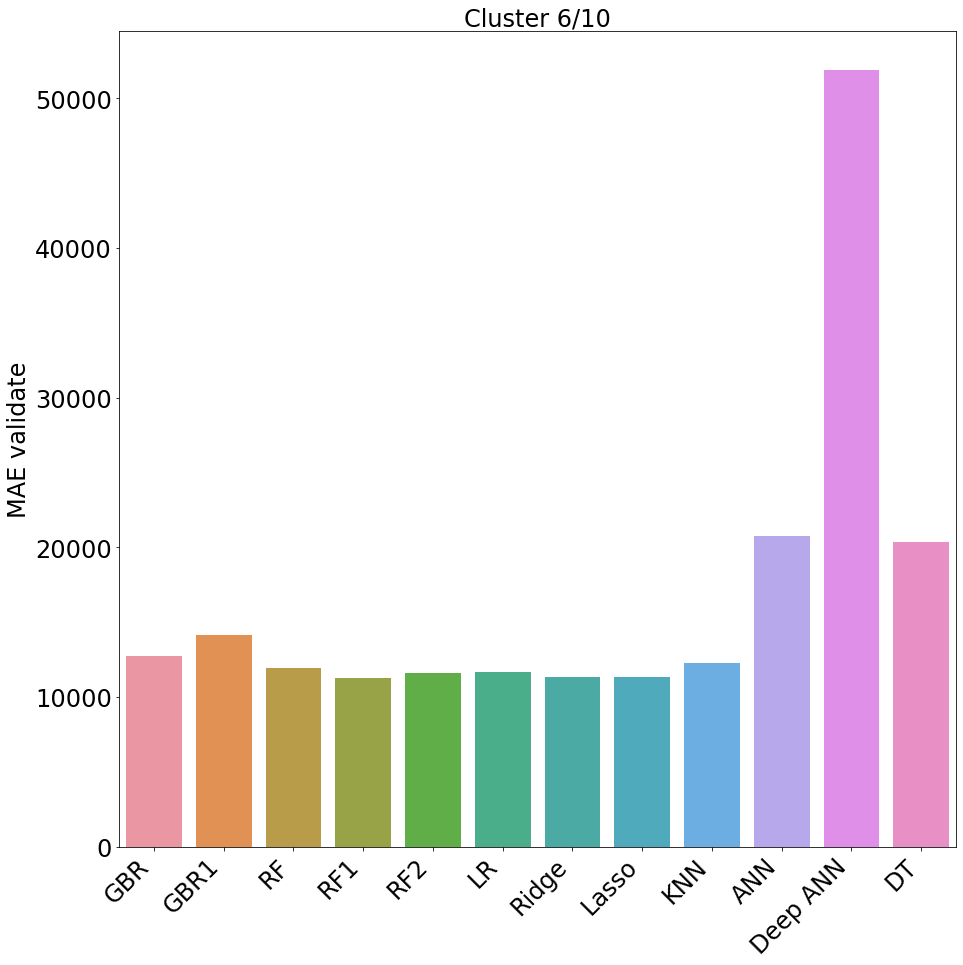

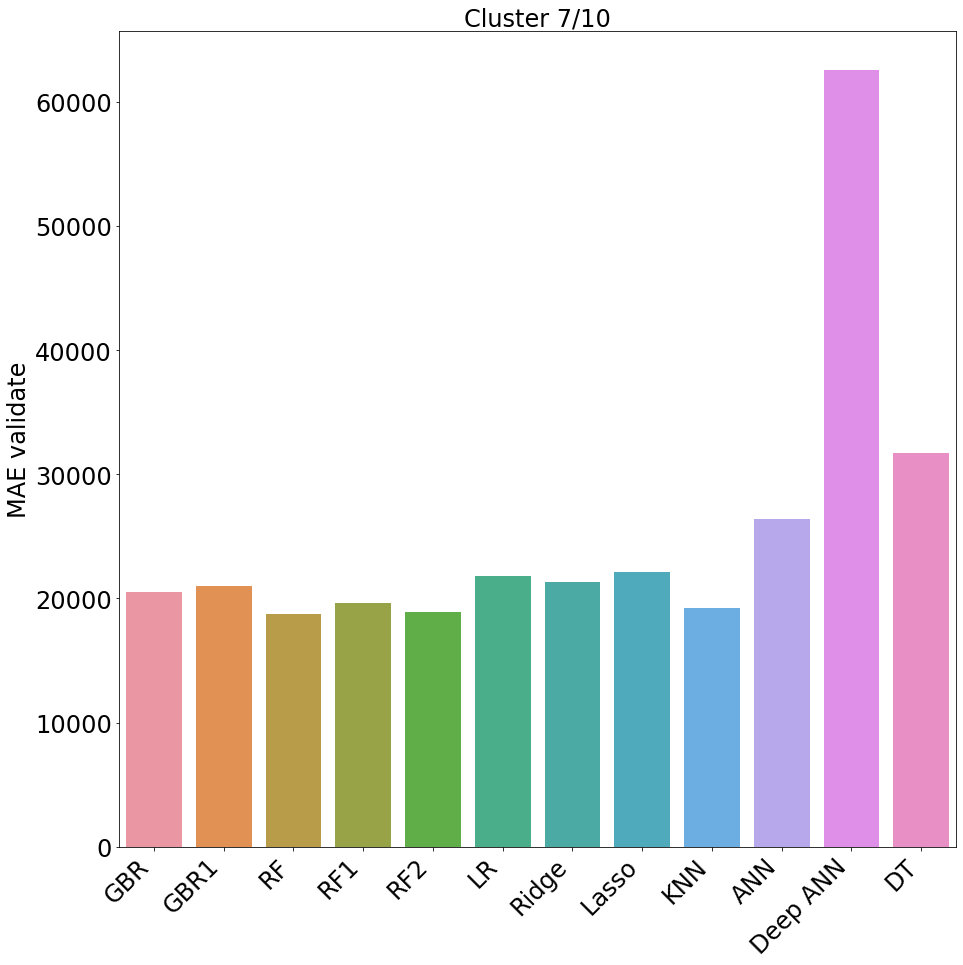

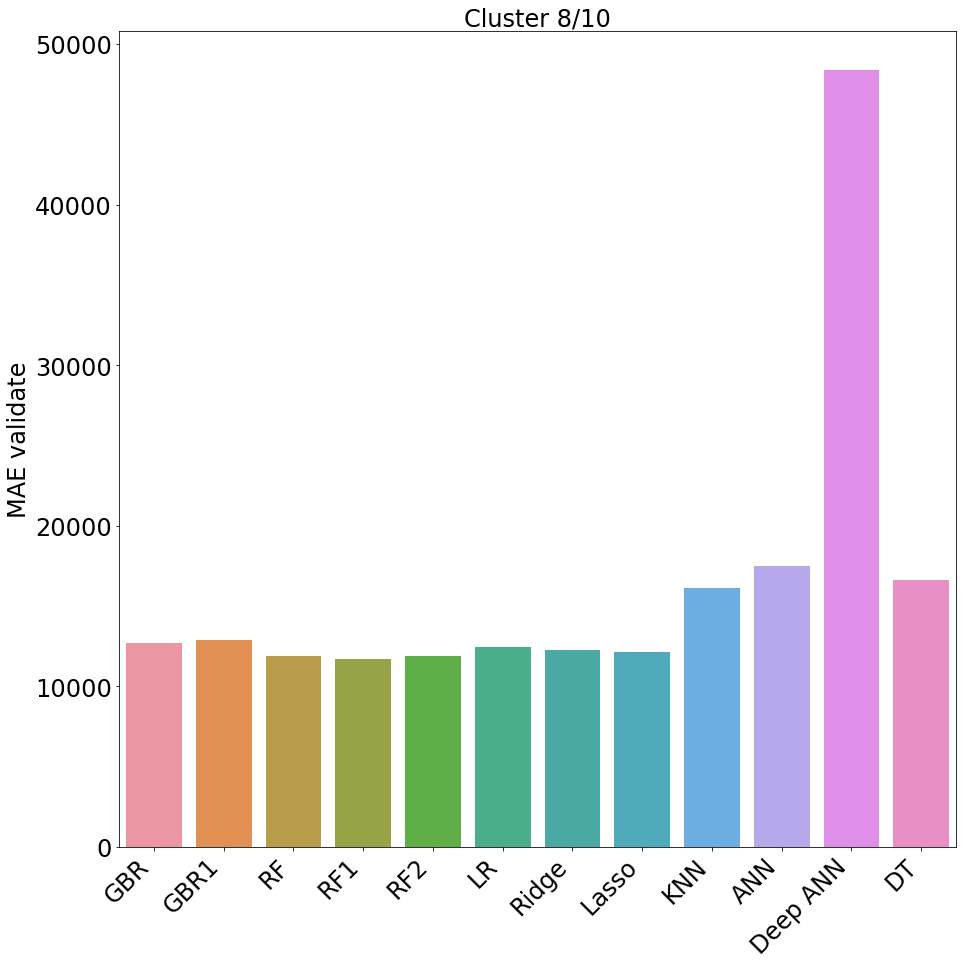

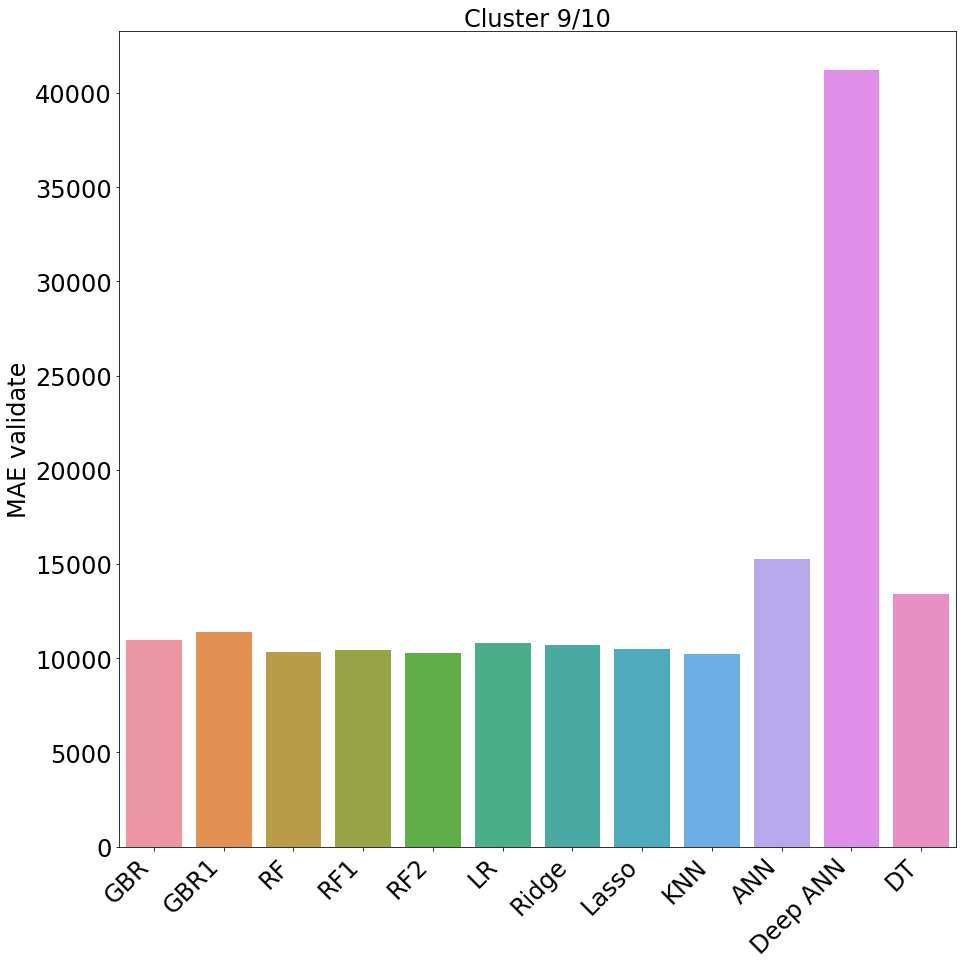

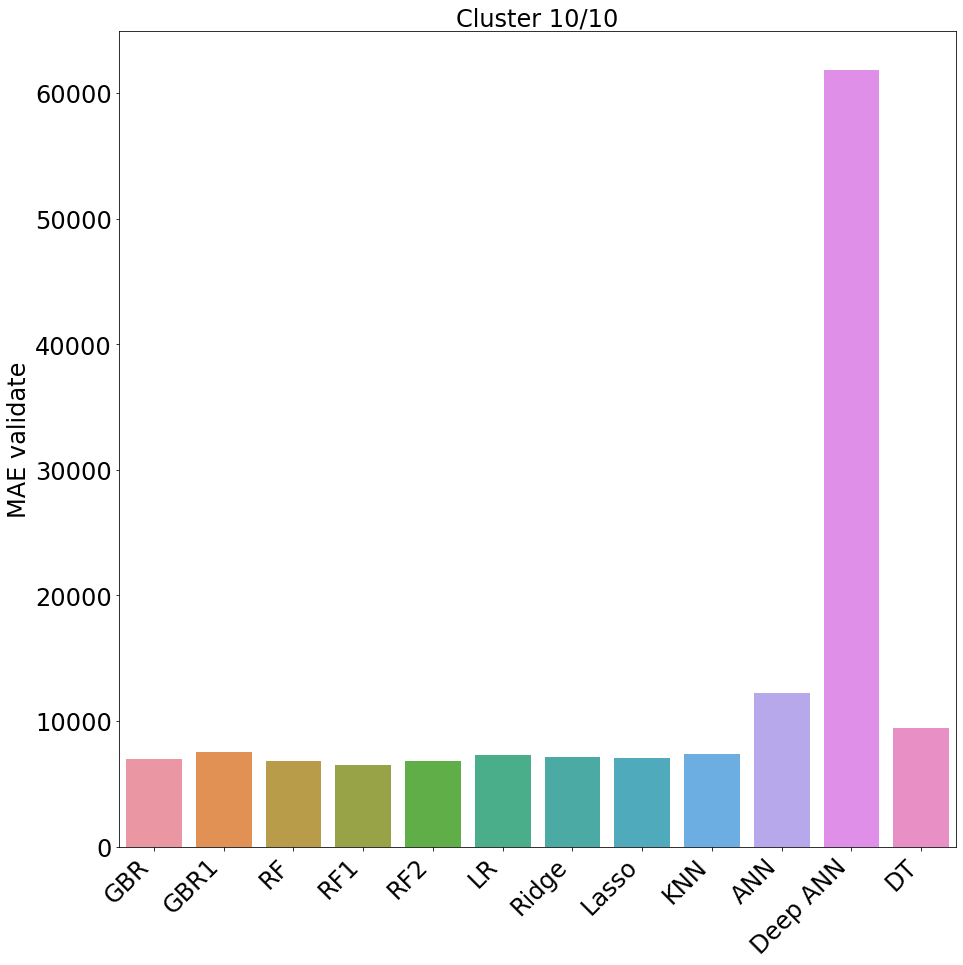

<Figure size 1080x1080 with 0 Axes>

In [28]:
for num_clusters in num_clusters_list:
    ##Create clusterer
    cluster = KMeans(n_clusters=num_clusters,random_state =2)
    
    ##Get predicted clusters for validate observations
    train["cluster"] = cluster.fit_predict(train[predictors])
    validate["cluster"] = cluster.predict(validate[predictors])
    2
    ##Create a variety of models
    gbr = GradientBoostingRegressor()
    gbr1 = GradientBoostingRegressor( n_estimators = 700, random_state =2, max_features = 9, max_depth = 10, min_samples_split =8)
    rf = RandomForestRegressor(n_estimators = 700, random_state =4)
    rf1 = RandomForestRegressor(n_estimators = 700, random_state =2, max_features = 3, min_samples_split = 16)
    rf2 = RandomForestRegressor(n_estimators = 700, random_state =2, max_features = 7)
    lr = LinearRegression()
    ridge = RidgeCV(cv = 5)
    lasso = LassoCV(cv = 5)
    knn = KNeighborsRegressor()
    ann = MLPRegressor(max_iter=10000, random_state =2)
    deep_ann = MLPRegressor(hidden_layer_sizes = (30, 2), max_iter=10000, random_state =40)
    dt = DecisionTreeRegressor(random_state =21)
    
    mse = []
    all_names = []
    names = ["GBR", "GBR1","RF", "RF1","RF2", "LR","Ridge","Lasso", "KNN", "ANN", "Deep ANN", "DT"]
    
    ##Start with max possible MSE validate
    best_mse = [np.inf for x in range(num_clusters)]
    models = [gbr, gbr1, rf, rf1,rf2, lr,ridge,lasso, knn, ann, deep_ann, dt]
 
    best_models = [None for x in range(num_clusters)]
    best_names = [None for x in range(num_clusters)]
    
    for cluster in range(num_clusters):
        mse.append([])
        all_names.append([])
        ##Subset data into validate and train for this cluster
        train_cluster = train[train["cluster"] == cluster]
        validate_cluster = validate[validate["cluster"] == cluster]
        
        ##If we are not clustering, just train on validate and train
        if num_clusters == 1:
            train_cluster = train
            validate_cluster = validate
            
        ##Fit each model on training set, predict validate, and unscale
        for i in range(len(models)):
            model = models[i]
            model.fit(train_cluster[predictors], train_cluster[target_name])
            predictions = model.predict(validate_cluster[predictors])
            predictions = y_scale.inverse_transform([predictions])
            actual = y_scale.inverse_transform([validate_cluster[target_name]])
            
            ##Get MSE validate (unscaled)
            error = mean_absolute_error( actual, predictions)
            mse[cluster].append(error)
            all_names[cluster].append(names[i])
            
            ##If below minium, save model to best models
            if error < best_mse[cluster]:
                best_mse[cluster] = error
                best_models[cluster] = model
                best_names[cluster] = names[i]
    
    ##Store best models, names, and bests for this cluster
    all_best_models.append(best_models)
    all_best_names.append(best_names)
    mse_store.append(best_mse)
    
    ##Make bar plot for cluster MSEs for algorithms
    for cluster in range(num_clusters):
        ax=sns.barplot(all_names[cluster], mse[cluster])
        ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
        )
        plt.ylabel("MAE validate")
        plt.title("Cluster " + str(cluster+1) + '/' + str(num_clusters))
        plt.show()
        plt.clf()
        ##Get weighted average MSE
        
    ##Find weighted average MSE of all clusters and store
    number_of_records = len(validate)
    weights = [len(validate[validate["cluster"] == c])/number_of_records for c in range(num_clusters)]
    weighted_MSE = sum([best_mse[i] * weights[i] for i in range(num_clusters) ])
    cluster_mse.append(weighted_MSE)

## Compare overall validate MSE on differnet number of Clusters

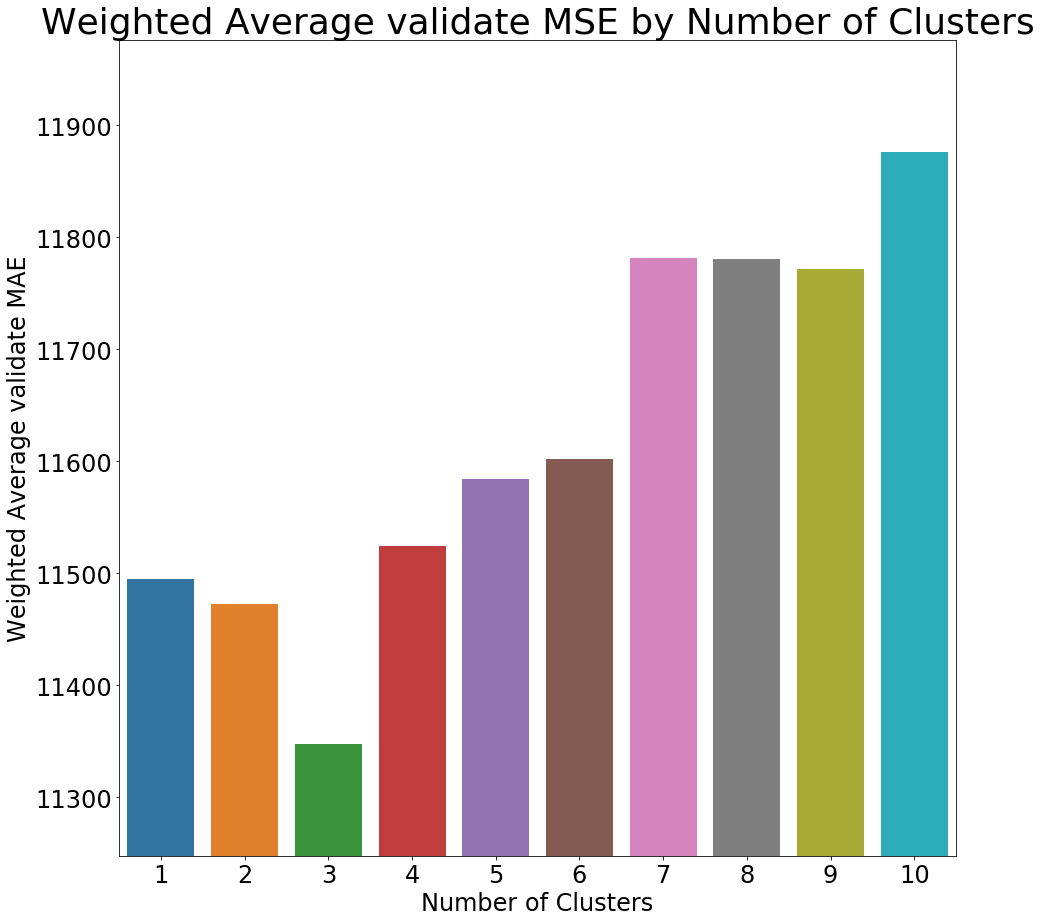

<Figure size 1080x1080 with 0 Axes>

In [29]:
##Compare different numbers of clusters and impact on MSE validate
sns.barplot(list(num_clusters_list), cluster_mse)
plt.xlabel("Number of Clusters")
plt.ylabel("Weighted Average validate MAE")
plt.ylim(min(cluster_mse) - 100,max(cluster_mse) + 100)
plt.title("Weighted Average validate MSE by Number of Clusters",fontsize=36)
plt.show()
plt.clf()

## Store the Best Model

In [30]:
## Get range of clusters we tested as list
clusters = list(num_clusters_list)

##Get index representing which number of clusters had the minimum weighted average MSE 
optimal_cluster_index = cluster_mse.index(min(cluster_mse))

##Translate this index into a optimal number of clusters
optimal_cluster_num = clusters[optimal_cluster_index]

##Get optimal models
models_list = all_best_models[optimal_cluster_index]

# Part 3: Make Predictions with a Separate Test Set Using Model From Part 2

## Load and Prep Trainning Set

In [31]:
##Create copy
train = data.copy()

x_scale, y_scale = prep_data(train, drop_correlated = True)

## Load and Prep Test Set

In [32]:
test_initial = pd.read_csv('CensusCanada2016Test.csv')

final_test = test_initial.copy()

prep_data(final_test, x_scale, test = True, drop_correlated = True)

final_test.describe()

Total Population  \
count        721.000000   
mean           0.157407   
std            0.082739   
min           -0.001920   
25%            0.106313   
50%            0.148389   
75%            0.202896   
max            0.865148   

       Total Households For Period Of Construction Built Before 1961  \
count                                         721.000000               
mean                                            0.223081               
std                                             0.236622               
min                                             0.000000               
25%                                             0.027213               
50%                                             0.131623               
75%                                             0.348480               
max                                             0.912758               

       Total Households For Period Of Construction Built Between 1961 And 1980  \
count                                         721.000000                         
mean                                            0.309784                         
std                                             0.215183                         
min                                             0.000000                         
25%                                             0.150011                         
50%                                             0.278655                         
75%                                             0.445173                         
max                                             0.943399                         

       Total Households For Period Of Construction Built Between 1981 And 190  \
count                                         721.000000                        
mean                                            0.154053                        
std                                             0.141813                        
min                                             0.000000                        
25%                                             0.062939                        
50%                                             0.115087                        
75%                                             0.197717                        
max                                             0.907065                        

       Total Households For Period Of Construction Built Between 1991 And 2000  \
count                                         721.000000                         
mean                                            0.140117                         
std                                             0.147056                         
min                                             0.000000                         
25%                                             0.044368                         
50%                                             0.089049                         
75%                                             0.182048                         
max                                             0.940128                         

       Total Households For Period Of Construction Built Between 2001 And 2005  \
count                                         721.000000                         
mean                                            0.083566                         
std                                             0.123673                         
min                                             0.000000                         
25%                                             0.013505                         
50%                                             0.037266                         
75%                                             0.102222                         
max                                             0.938586                         

       Total Households For Structure Type Houses  Dwellings by Tenure Owner  \
count                                  721.000000                 721.000000   
mean   

## Fit on train and Predict CLUSTER on test

In [33]:
## Create final clusterer
cluster_final = KMeans(n_clusters=optimal_cluster_num, random_state =123)

##Fit clusterer to training set
train["cluster"] =cluster_final.fit_predict(train[predictors])

##Get predicted clusters for test data set
final_test["cluster"] =cluster_final.predict(final_test[predictors])

## Put Trainning and Testing sets into List by Clusters

In [34]:
##Create list of training sets by cluster
training_sets = [train[train["cluster"] == i] for i in range(optimal_cluster_num)]

##Create list of testing sets by cluster
testing_sets = [final_test[final_test["cluster"] == i] for i in range(optimal_cluster_num)]

## Train with optimal model for each cluster 

In [35]:
##Fit all models with appropriate training data -> models_list stores our optimal models, training_sets stores the training sets stored by cluster
fit_models = [models_list[i].fit(training_sets[i][predictors], training_sets[i][target_name]) for i in range(optimal_cluster_num)]

## Predict with optimal model for each cluster

In [36]:
##Make all final predictions by cluster number, testing_sets stores the test set in lists by cluster
new_final_predictions = [models_list[i].predict(testing_sets[i][predictors]) for i in range(optimal_cluster_num)]

## Put all clusters back into DataFrame

In [37]:
## Add predictions back into dataframes by cluster (needed to retain proper index)
for i in range(optimal_cluster_num):
    testing_sets[i]["predictions"] = new_final_predictions[i]

In [38]:
##Join all testing sets filled with predictions together again
final_joined_predictors = pd.concat(testing_sets)

##Sort by index
final_sorted_predictions = final_joined_predictors.sort_index()

## Another way to make final predictions and check with the previous way for consistency

In [39]:
##Another way to Make final prediction
final_predictions = []
for i in range(len(final_test)):
    if final_test.iloc[i,:]["cluster"] == 0:
        final_predictions.append(models_list[0].predict([final_test.iloc[i, :][predictors]])[0])
    elif final_test.iloc[i,:]["cluster"] == 1:
        final_predictions.append(models_list[1].predict([final_test.iloc[i, :][predictors]])[0])
    else:
        final_predictions.append(models_list[2].predict([final_test.iloc[i, :][predictors]])[0])
##Check for consistency
predictions = list(final_sorted_predictions["predictions"])
for i in range(max(len(predictions), len(final_predictions))):
    if round(predictions[i], 7) != round(final_predictions[i], 7):
        raise Exception("Not Equal: " +str(predictions[i]) + str(final_predictions[i]))

## Unscale and Final Check

In [40]:
##Unscale predictions
unscaled_final = y_scale.inverse_transform([final_sorted_predictions["predictions"]])[0]
##Check
check = pd.DataFrame(unscaled_final)

if len(test_initial) != len(unscaled_final):
    raise Exception("You are missing predictions")
'''
save.iloc[test_initial.index[test_initial["Total Population"] == 0]] = 0
'''

'\nsave.iloc[test_initial.index[test_initial["Total Population"] == 0]] = 0\n'

## Summary Graphs for each single Characteristic across clusters

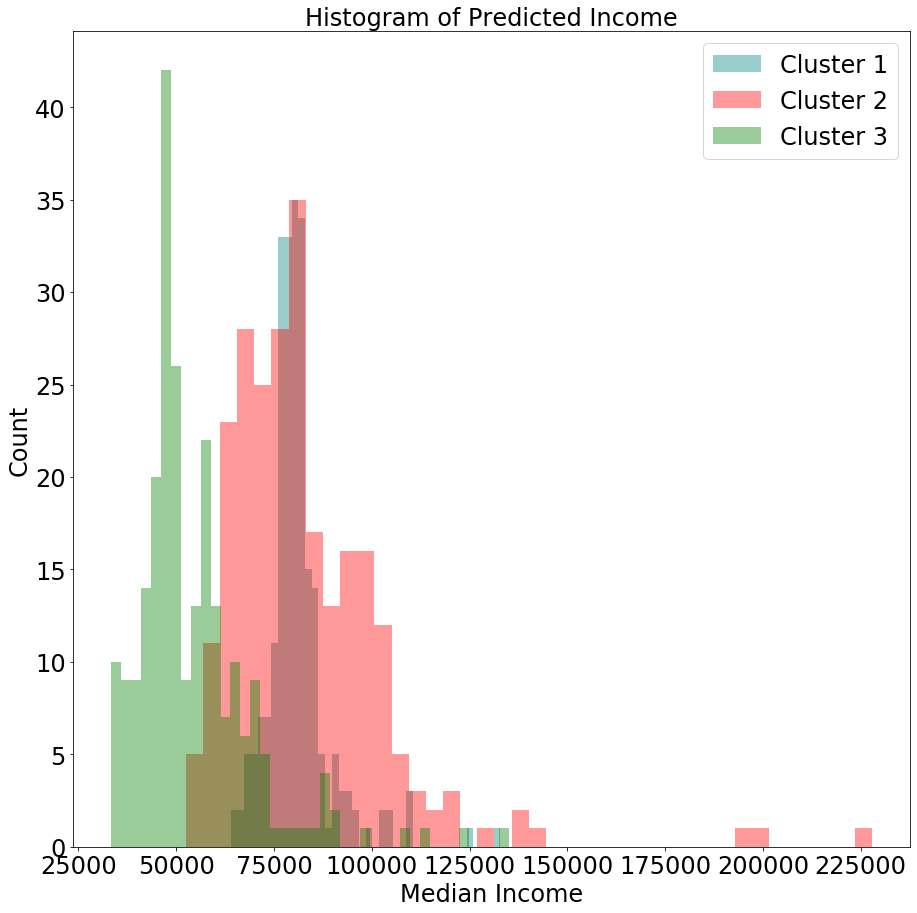

In [41]:
##Make histogram of predictions by cluster
test_initial["Predictions"]= unscaled_final
final_sorted_predictions["TransformedPredictions"] = unscaled_final

##Divide predictions into sets
final_c0 = final_sorted_predictions[final_sorted_predictions["cluster"] == 0]
final_c1 = final_sorted_predictions[final_sorted_predictions["cluster"] == 1]
final_c2 = final_sorted_predictions[final_sorted_predictions["cluster"] == 2]

plt.title("Histogram of Predicted Income")
plt.hist(final_c0["TransformedPredictions"], bins=40, color = 'teal', alpha=.4, label = 'Cluster 1')
plt.hist(final_c1["TransformedPredictions"], bins=40, color = 'red', alpha=.4, label = 'Cluster 2')
plt.hist(final_c2["TransformedPredictions"], bins=40, color = 'green', alpha=.4, label = 'Cluster 3')
plt.legend(loc='upper right')
plt.xlabel("Median Income")
plt.ylabel("Count")
plt.show()


## Scatter Plot of clusters, indicating which tract would be suitable for a 'Premium shop' or 'Basic Shop'

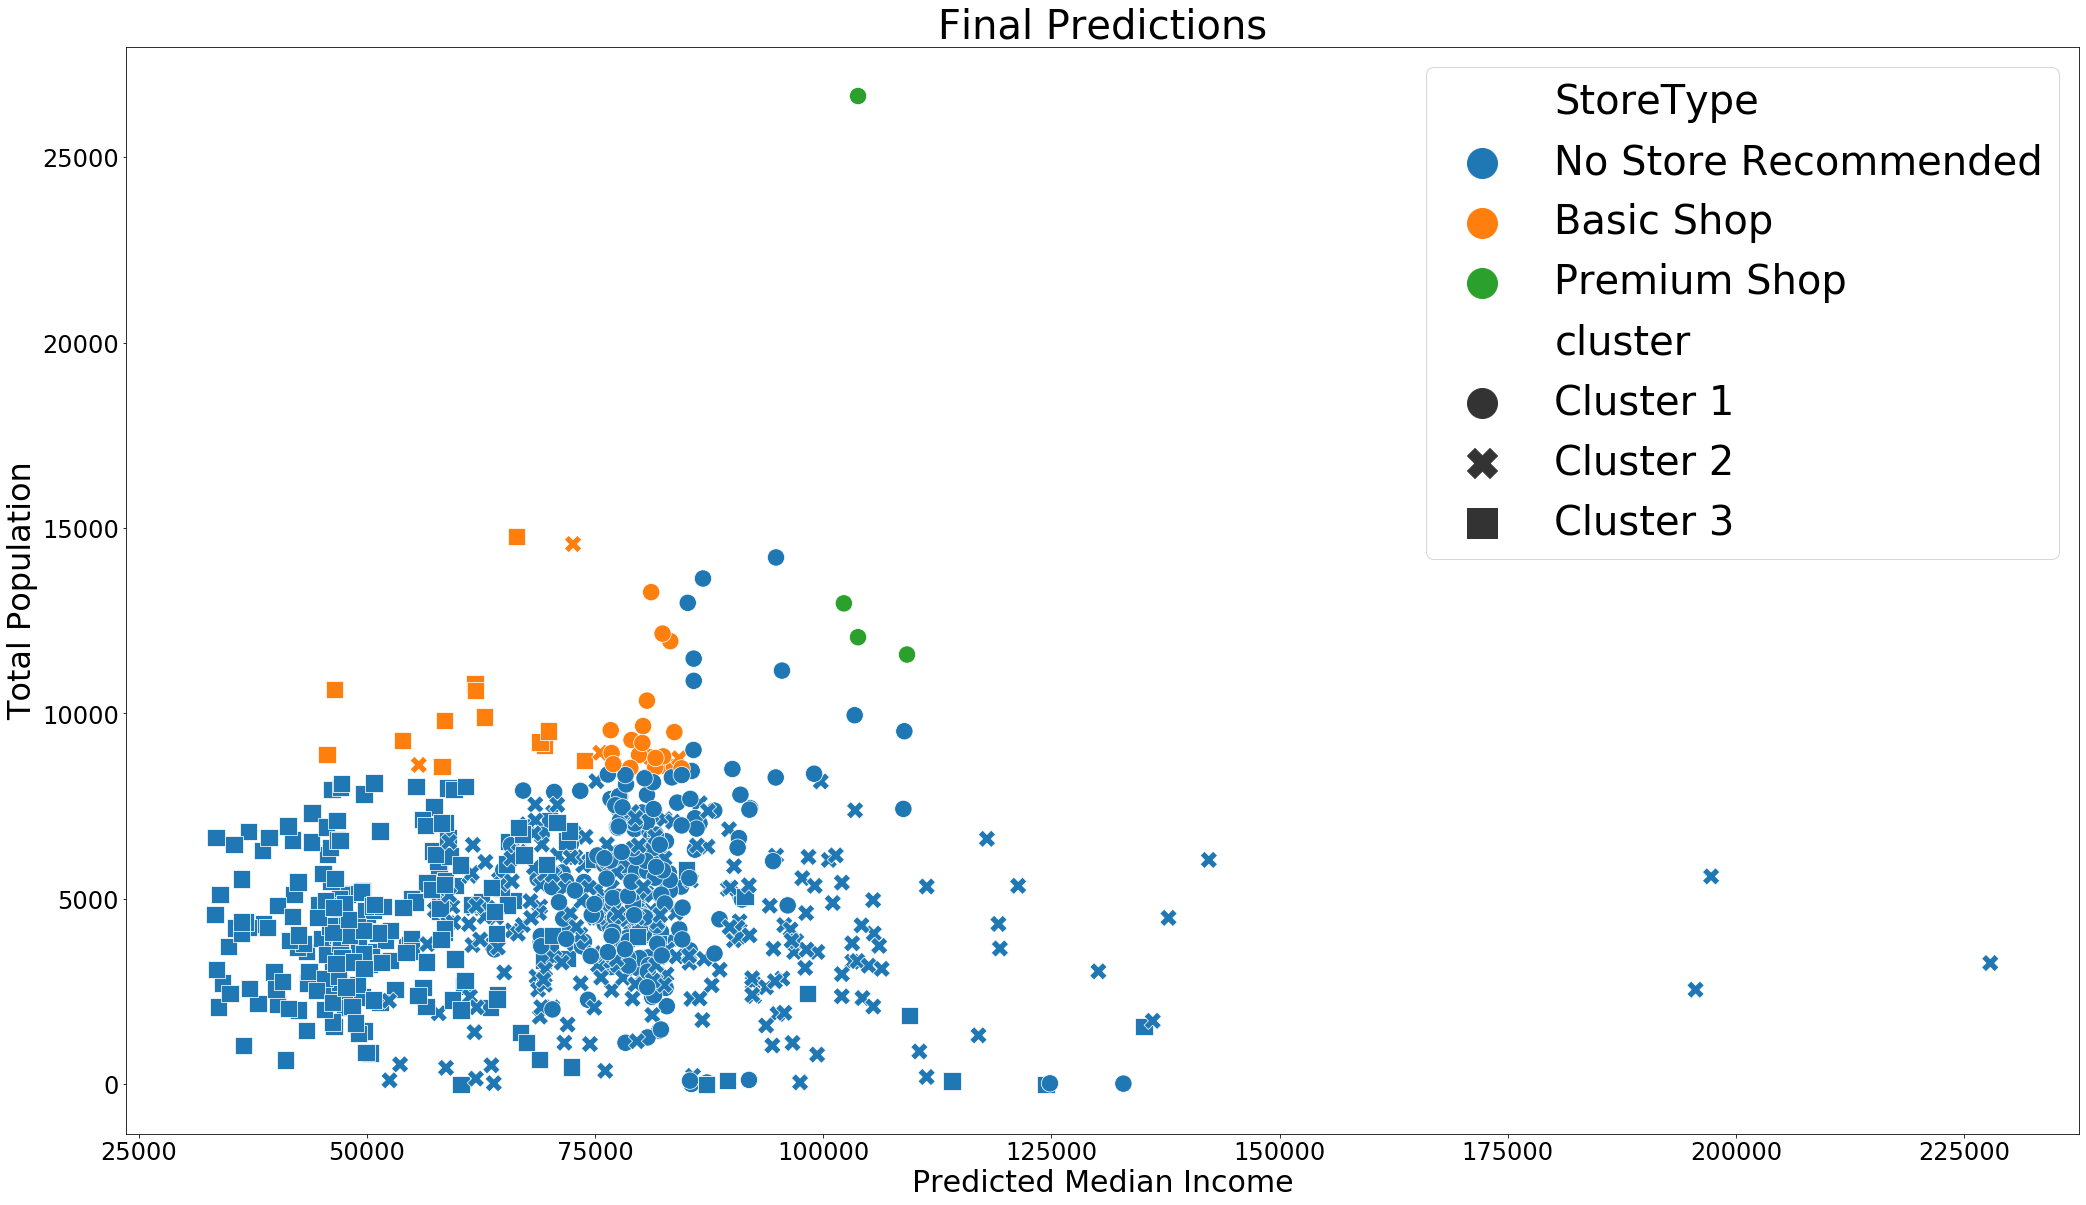

In [42]:
test_initial["StoreType"] = ["Premium Shop" if test_initial["Predictions"][i] > 97000 and test_initial["Total Population"][i] > 10000 else "Basic Shop" if test_initial["Predictions"][i] < 85000 and test_initial["Total Population"][i] > 8500 else "No Store Recommended" for i in range(len(test_initial))]
test_initial["cluster"] = ["Cluster 1" if final_test["cluster"][i] == 0 else "Cluster 2" if final_test["cluster"][i] == 1 else "Cluster 3"  for i in range(len(test_initial))]

plt.figure(figsize=(35,20))
sns.scatterplot(x ="Predictions", y = "Total Population", data= test_initial, hue="StoreType", s=300, style = "cluster", markers = ["o","X","s"])
plt.title("Final Predictions", fontsize=40)
plt.xlabel("Predicted Median Income", fontsize=30)
plt.ylabel("Total Population", fontsize=32)
plt.legend(fontsize = 40, markerscale=5.)